In [379]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from natsort import natsorted
import matplotlib.pyplot as plt

In [380]:
gm_data = [os.path.basename(file) for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
k5_data = [os.path.basename(file) for file in (glob.glob("data/trained_models/2025-07-25-10/*.csv") + glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

In [381]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [382]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [383]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [384]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        plt.clf()

        return signal_index, only_0s_index

In [385]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for dir in ["data/trained_models/2025-07-23-11", "data/trained_models/2025-07-25-10", "data/trained_models/2025-07-25-14"]:
    for file in data:
        try:
            df = pd.read_csv(f"{dir}/{file}")
        except FileNotFoundError:
            pass
        if "GM12878" in file:
            results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
        else:
            results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 85071
Num Rows (K562): 170142


In [386]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.491487
2     0.471093
3     0.458778
4     0.426490
5     0.497957
6     0.479129
7     0.486898
8     0.498286
9     0.469190
10    0.510193
11    0.465784
12    0.482274
Name: Error, dtype: float64

Max Error Fold: 0.5101927026762714 at Fold 10

Min Error Fold: 0.4264899641109209 at Fold 4

Mean Error: 0.48077935973464014

Max Error: 4.873539416

Min Error: 7.3658302e-06 

K562: 
Mean Error per Fold:
fold_idx
1     0.491487
2     0.471093
3     0.458778
4     0.426490
5     0.497957
6     0.479129
7     0.486898
8     0.498286
9     0.469190
10    0.510193
11    0.465784
12    0.494602
Name: Error, dtype: float64

Max Error Fold: 0.5101927026762714 at Fold 10

Min Error Fold: 0.4264899641109209 at Fold 4

Mean Error: 0.4819532078715494

Max Error: 4.873539416

Min Error: 7.3658302e-06 



Negative Predictions

GM12878: 
Threshold: 0
Genes per Fold: 
1: 197
2: 87
3: 114
4: 28
5: 13
6: 207
7: 2
8: 1
10: 261
11: 10
12: 3
Total Number of Matches: 922
Total Matches with >= 1 Non-Zero Value: 327
Percentage of TSSs with No Signal: 64.53%
Genes w/ Signal: ['ENSG00000198744', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187961', 'ENSG00000188290', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000067606', 'ENSG00000067606_1', 'ENSG00000157933_1', 'ENSG00000116151', 'ENSG00000116151_1', 'ENSG00000149527_1', 'ENSG00000197921', 'ENSG00000157873', 'ENSG00000158109', 'ENSG00000078900', 'ENSG0000023516

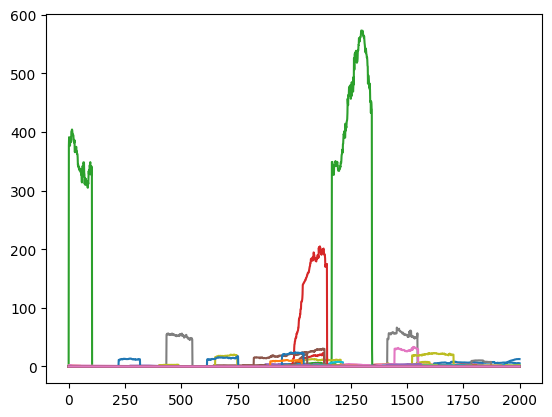

K562: 
Threshold: 0
Genes per Fold: 
1: 394
2: 174
3: 228
4: 56
5: 26
6: 414
7: 4
8: 2
10: 522
11: 20
12: 6
Total Number of Matches: 922
Total Matches with >= 1 Non-Zero Value: 272
Percentage of TSSs with No Signal: 70.50%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187961', 'ENSG00000304119', 'ENSG00000162571_1', 'ENSG00000078808', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000242485', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160075_1', 'ENSG00000272106', 'ENSG00000197530_2', 'ENSG00000078369', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000067606', 'ENSG00000157933_1', 'ENSG00000157911', 'ENSG00000149527_1', 'ENSG00000157881', 'ENSG00000197921', 'ENSG00000157873', 'ENSG00000162591', 'ENSG00000238260', 'ENSG00000235169', 'ENSG00000116198', 'ENSG00000169598_1', 'ENSG00000131697', 'ENSG00000116237', 'ENSG00000158292', 'E

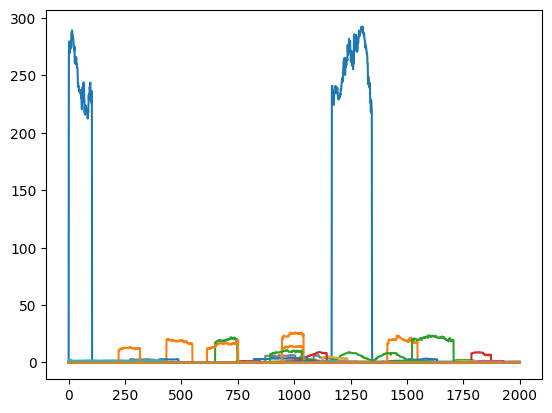

<Figure size 640x480 with 0 Axes>

In [387]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/neg_preds", "K562")

Low Errors

In [388]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.006096
0.05    0.029281
0.10    0.055920
Name: Error, dtype: float64

In [389]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.006138
0.05    0.029390
0.10    0.055856
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 13
2: 30
3: 10
4: 10
5: 9
6: 22
7: 7
8: 7
9: 4
10: 12
11: 9
12: 8
Total Number of Matches: 138
Total Matches with >= 1 Non-Zero Value: 74
Percentage of TSSs with No Signal: 46.38%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634_2', 'ENSG00000187583', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000272106', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000142609_1', 'ENSG00000187730', 

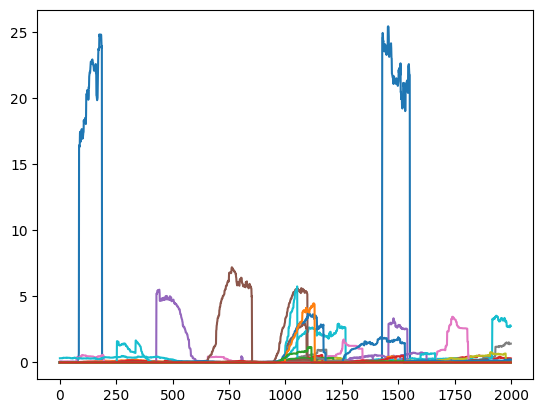

K562: 
Threshold: 0.001
Genes per Fold: 
1: 26
2: 60
3: 20
4: 20
5: 18
6: 44
7: 14
8: 14
9: 8
10: 24
11: 18
12: 14
Total Number of Matches: 140
Total Matches with >= 1 Non-Zero Value: 70
Percentage of TSSs with No Signal: 50.00%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530_1', 'ENSG00000008128', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609_1', 'ENSG00000067606', 'ENSG00000067606_2', 'ENSG000000

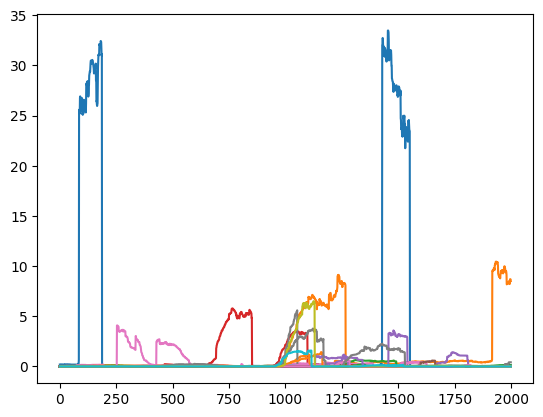

<Figure size 640x480 with 0 Axes>

In [390]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/low_errors", "K562")

High Errors

In [391]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.106531
0.95    1.539093
0.99    2.344526
Name: Error, dtype: float64

In [392]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.111491
0.95    1.548538
0.99    2.346714
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 1080
2: 940
3: 689
4: 484
5: 863
6: 745
7: 692
8: 992
9: 911
10: 1236
11: 760
12: 915
Total Number of Matches: 6320
Total Matches with >= 1 Non-Zero Value: 5104
Percentage of TSSs with No Signal: 19.24%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'E

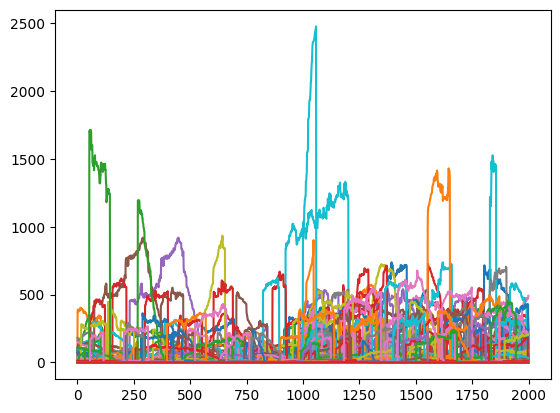

K562: 
Threshold: 1
Genes per Fold: 
1: 2160
2: 1880
3: 1378
4: 968
5: 1726
6: 1490
7: 1384
8: 1984
9: 1822
10: 2472
11: 1520
12: 1986
Total Number of Matches: 6387
Total Matches with >= 1 Non-Zero Value: 5147
Percentage of TSSs with No Signal: 19.41%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000175756'

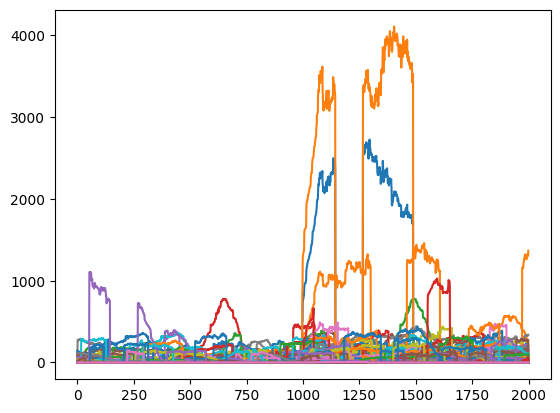

<Figure size 640x480 with 0 Axes>

In [393]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/high_errors", "K562")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 3172
2: 3066
3: 2598
4: 1813
5: 2489
6: 2565
7: 2988
8: 3580
9: 2868
10: 4322
11: 2732
12: 3861
Total Number of Matches: 18095
Total Matches with >= 1 Non-Zero Value: 12024
Percentage of TSSs with No Signal: 33.55%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530_1', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008

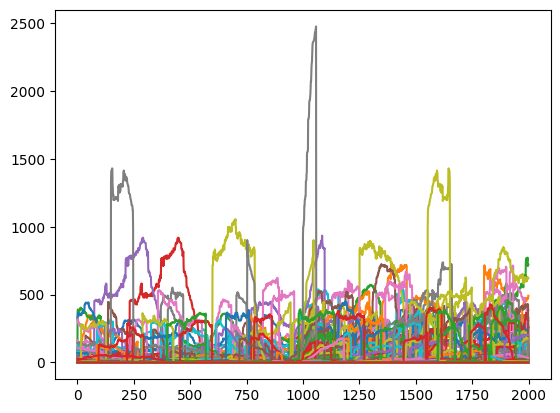

K562
Threshold: 0
Genes per Fold: 
1: 6344
2: 6132
3: 5196
4: 3626
5: 4978
6: 5130
7: 5976
8: 7160
9: 5736
10: 8644
11: 5464
12: 7392
Total Number of Matches: 18103
Total Matches with >= 1 Non-Zero Value: 12061
Percentage of TSSs with No Signal: 33.38%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_2', 'ENSG00000189409',

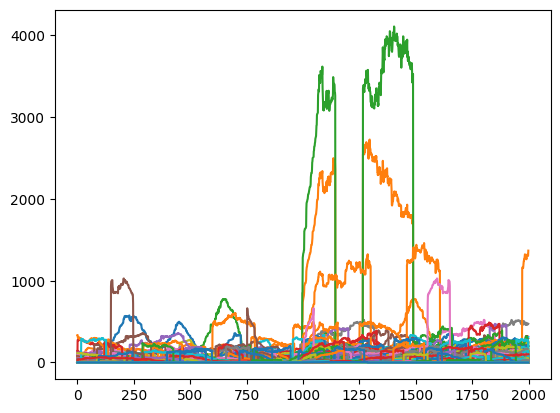

<Figure size 640x480 with 0 Axes>

In [394]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/overestimates", "K562")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 5186
2: 4713
3: 3213
4: 2954
5: 4480
6: 3402
7: 3279
8: 4226
9: 4626
10: 4654
11: 4045
12: 4239
Total Number of Matches: 21623
Total Matches with >= 1 Non-Zero Value: 12958
Percentage of TSSs with No Signal: 40.07%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000197530_2', 'ENSG00000189

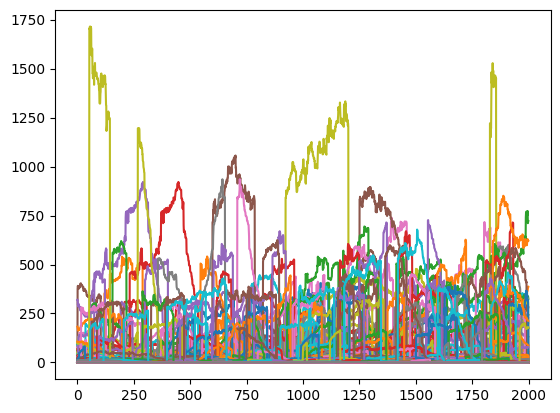

K562
Threshold: 0
Genes per Fold: 
1: 10372
2: 9426
3: 6426
4: 5908
5: 8960
6: 6804
7: 6558
8: 8452
9: 9252
10: 9308
11: 8090
12: 8808
Total Number of Matches: 21686
Total Matches with >= 1 Non-Zero Value: 13114
Percentage of TSSs with No Signal: 39.53%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000188157', 'ENSG00000304119', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000160075', 'ENSG00000189409', 'ENSG00000248333'

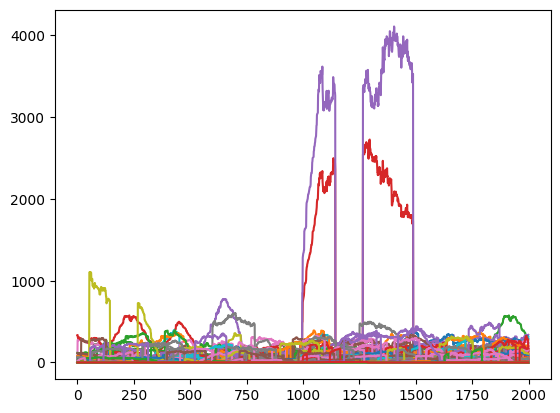

<Figure size 640x480 with 0 Axes>

In [395]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/underestimates", "K562")

In [417]:
n = 40

Worst Errors (Over Expressed)

In [405]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
10600    ENSG00000100804  3.837597     0.0         5                     NaN   
59490    ENSG00000266472  3.727168     0.0         1                1100.910   
60612    ENSG00000162851  3.562582     0.0         1                 541.599   
3152     ENSG00000143947  3.492248     0.0         2                     NaN   
49553    ENSG00000111639  3.394502     0.0         9                1619.830   
59453    ENSG00000143106  3.359196     0.0         1                2220.680   
74907    ENSG00000255135  3.348294     0.0         8                 180.878   
816      ENSG00000176261  3.259053     0.0         1                     NaN   
2405     ENSG00000126067  3.257822     0.0         1                     NaN   
49499  ENSG00000140264_1  3.251933     0.0         9                 624.160   
49121    ENSG00000166797  3.223828     0.0         9                1666.320   
60539    ENSG00000117697  3.195888     0.0         1                 461.646   
32847    ENSG00000143106  3.125894     0.0         1                2220.680   
64437  ENSG00000236859_1  3.119059     0.0         2                     NaN   
33637    ENSG00000291072  3.108010     0.0         1                  67.989   
21846    ENSG00000077312  3.097393     0.0        10                     NaN   
75068    ENSG00000276788  3.083116     0.0         8                  24.971   
61218    ENSG00000031698  3.078306     0.0         1                 191.944   
64692    ENSG00000114956  3.077728     0.0         2                 656.572   
2427     ENSG00000160049  3.074574     0.0         1                     NaN   

          Error  Signed Error  
10600  3.837597      3.837597  
59490  3.727168      3.727168  
60612  3.562582      3.562582  
3152   3.492248      3.492248  
49553  3.394502      3.394502  
59453  3.359196      3.359196  
74907  3.348294      3.348294  
816    3.259053      3.259053  
2405   3.257822      3.257822  
49499  3.251933      3.251933  
49121  3.223828      3.223828  
60539  3.195888      3.195888  
32847  3.125894      3.125894  
64437  3.119059      3.119059  
33637  3.108010      3.108010  
21846  3.097393      3.097393  
75068  3.083116      3.083116  
61218  3.078306      3.078306  
64692  3.077728      3.077728  
2427   3.074574      3.074574

K562: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
18380     ENSG00000092199  3.925557     0.0         5                     NaN   
20703     ENSG00000092199  3.925557     0.0         5                     NaN   
113504    ENSG00000266472  3.727168     0.0         1                1100.910   
116290    ENSG00000266472  3.727168     0.0         1                1100.910   
114626    ENSG00000162851  3.562582     0.0         1                 541.599   
117412    ENSG00000162851  3.562582     0.0         1                 541.599   
5938      ENSG00000143947  3.492248     0.0         2                     NaN   
8531      ENSG00000143947  3.492248     0.0         2                     NaN   
93118     ENSG00000111639  3.394502     0.0         9                1619.830   
95616     ENSG00000111639  3.394502     0.0         9                1619.830   
113467    ENSG00000143106  3.359196     0.0         1                2220.680   
116253    ENSG00000143106  3.359196     0.0         1                2220.680   
144227    ENSG00000255135  3.348294     0.0         8                 180.878   
146829    ENSG00000255135  3.348294     0.0         8                 180.878   
816       ENSG00000176261  3.259053     0.0         1                     NaN   
3602      ENSG00000176261  3.259053     0.0         1                     NaN   
2405      ENSG00000126067  3.257822     0.0         1                     NaN   
5191      ENSG00000126067  3.257822     0.0         1                     NaN   
93064   ENSG00000140264_1  3.251933     0.0         9                 624.160   
95562   ENSG00000140264_1  3.251933     0.0         9                 624.160   

           Error  Signed Error  
18380   3.925557      3.925557  
20703   3.925557      3.925557  
113504  3.727168      3.727168  
116290  3.727168      3.727168  
114626  3.562582      3.562582  
117412  3.562582      3.562582  
5938    3.492248      3.492248  
8531    3.492248      3.492248  
93118   3.394502      3.394502  
95616   3.394502      3.394502  
113467  3.359196      3.359196  
116253  3.359196      3.359196  
144227  3.348294      3.348294  
146829  3.348294      3.348294  
816     3.259053      3.259053  
3602    3.259053      3.259053  
2405    3.257822      3.257822  
5191    3.257822      3.257822  
93064   3.251933      3.251933  
95562   3.251933      3.251933

GM12878: 


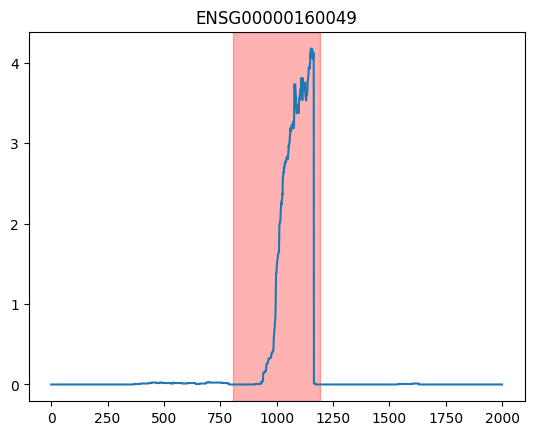

Pred: 3.074574
Actual: 0.0


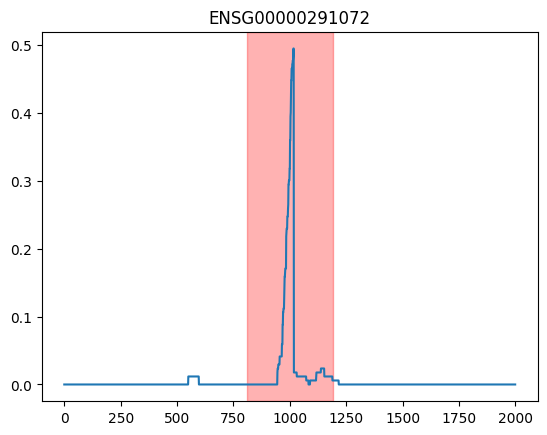

Pred: 3.1080105
Actual: 0.0


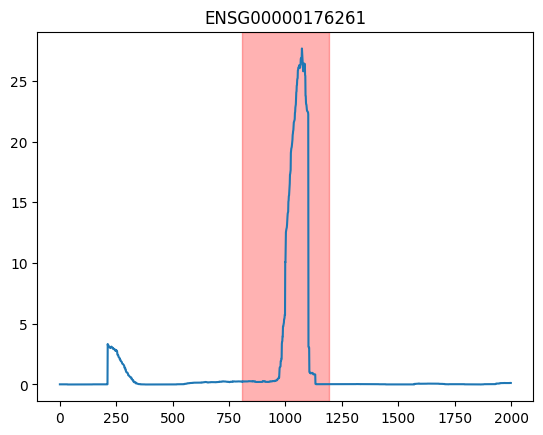

Pred: 3.2590528
Actual: 0.0


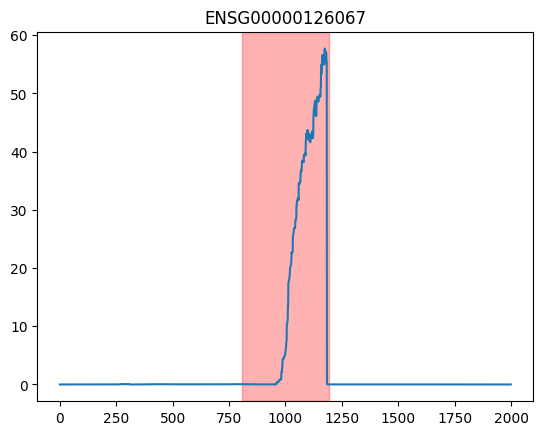

Pred: 3.2578223
Actual: 0.0


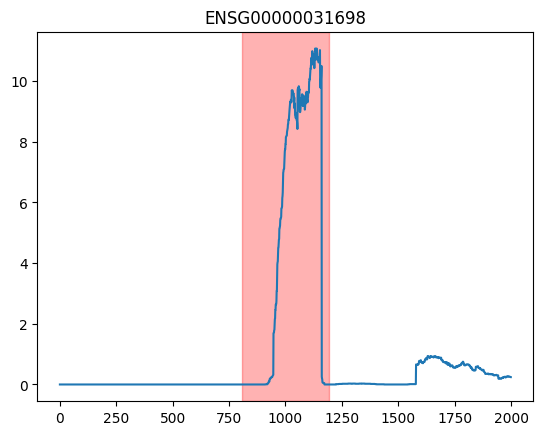

Pred: 3.078306
Actual: 0.0


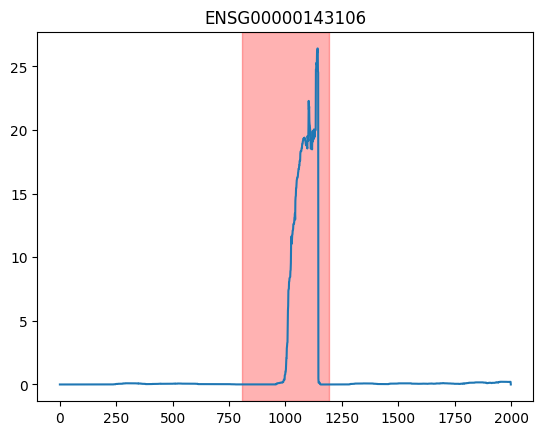

Pred: 3.359196
Actual: 0.0


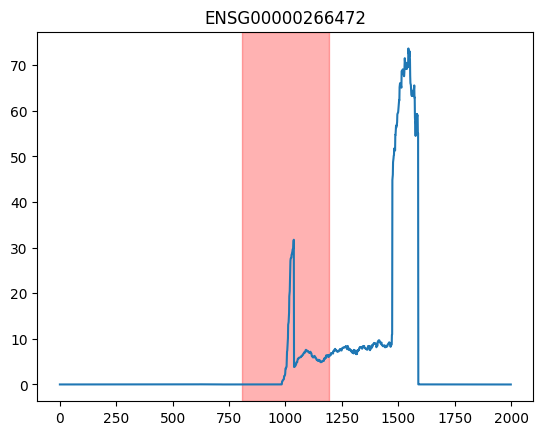

Pred: 3.7271683
Actual: 0.0


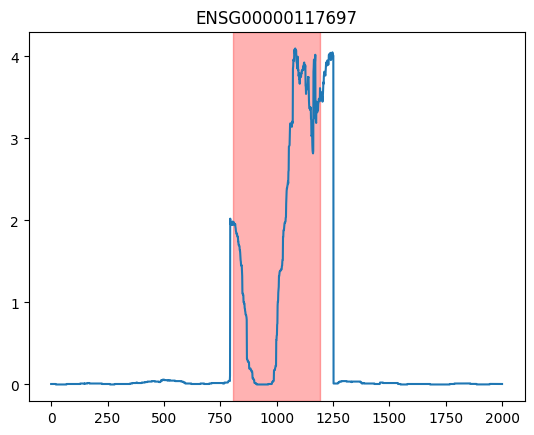

Pred: 3.1958876
Actual: 0.0


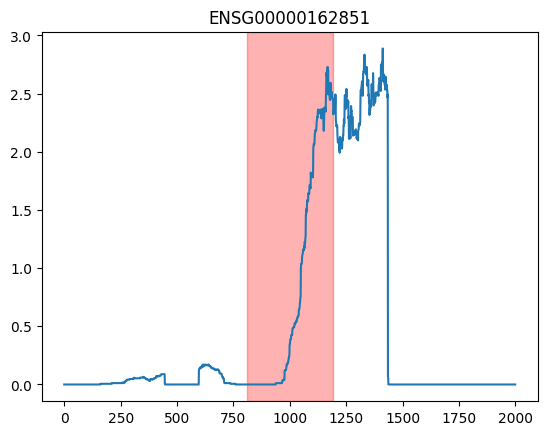

Pred: 3.5625825
Actual: 0.0


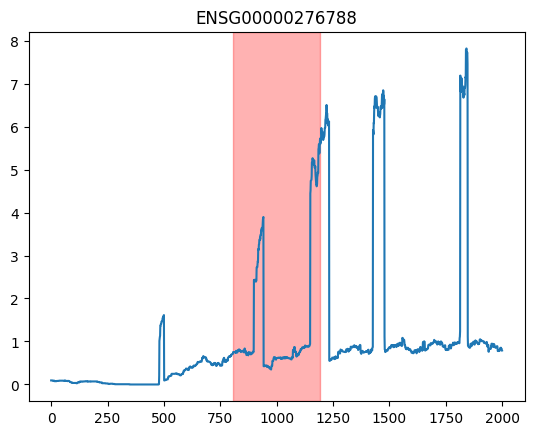

Pred: 3.0831156
Actual: 0.0


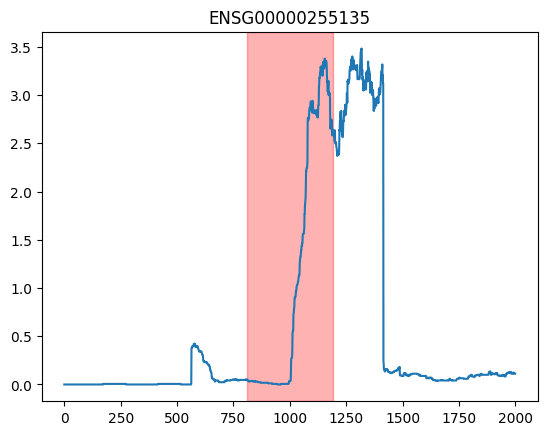

Pred: 3.3482938
Actual: 0.0


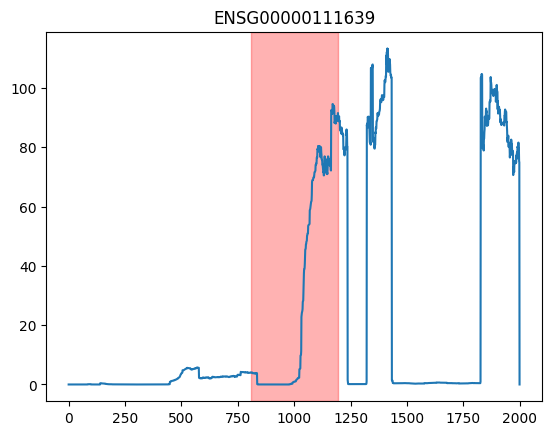

Pred: 3.3945022
Actual: 0.0


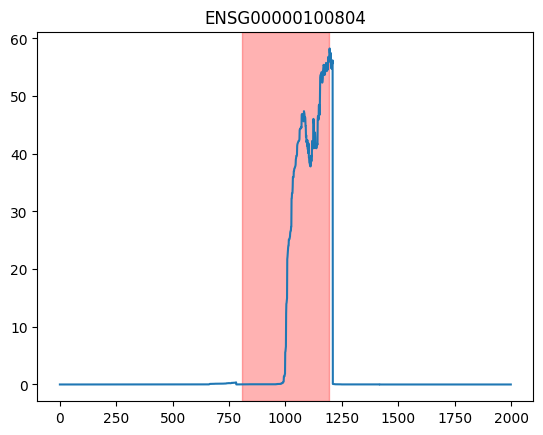

Pred: 3.837597
Actual: 0.0


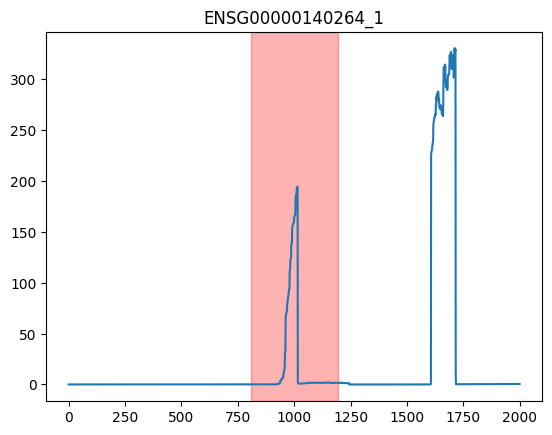

Pred: 3.2519333
Actual: 0.0


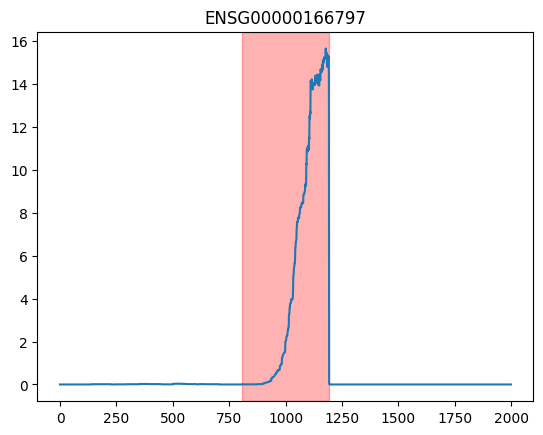

Pred: 3.223828
Actual: 0.0


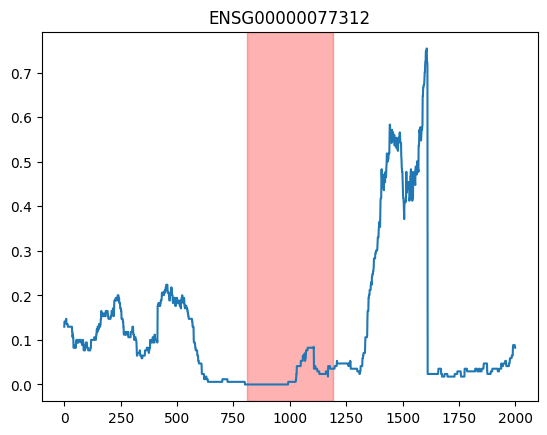

Pred: 3.0973926
Actual: 0.0


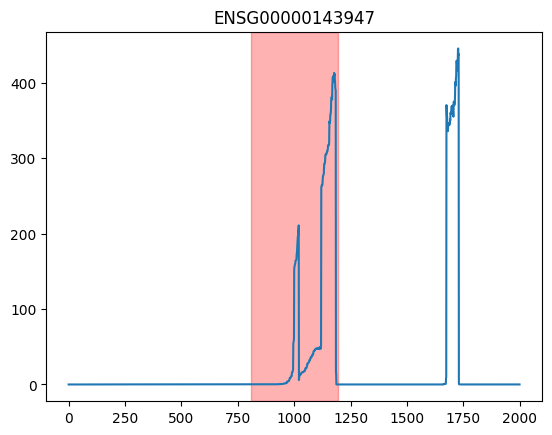

Pred: 3.4922478
Actual: 0.0


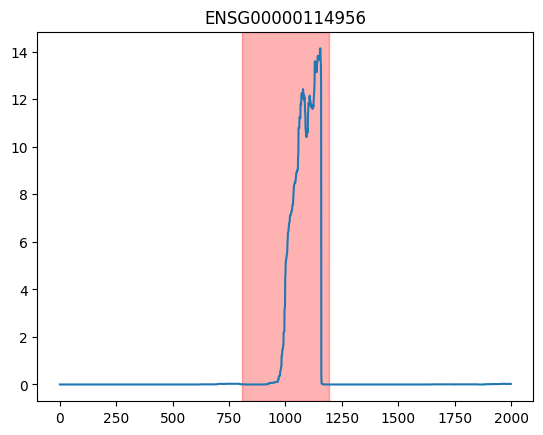

Pred: 3.077728
Actual: 0.0


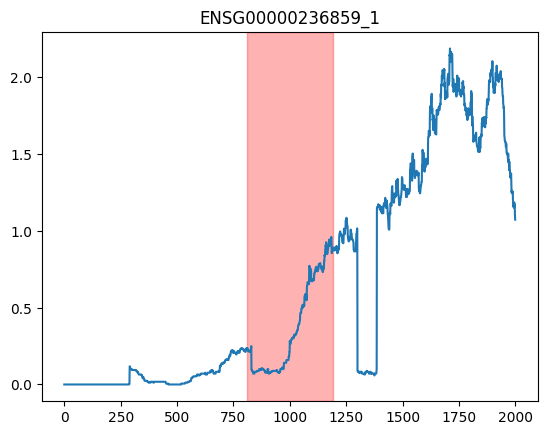

Pred: 3.1190586
Actual: 0.0

K562: 


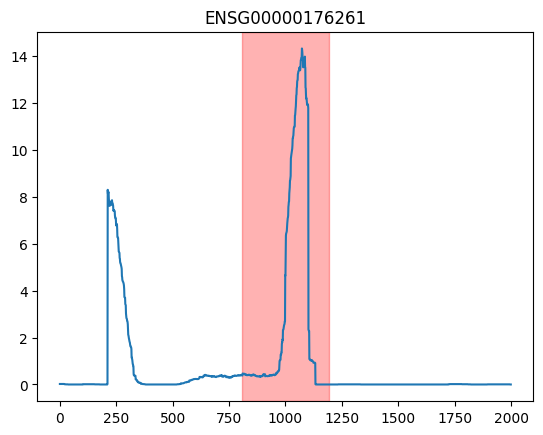

Pred: 3.2590528
Actual: 0.0


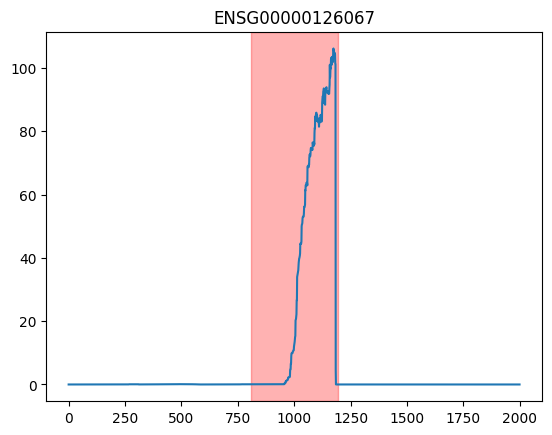

Pred: 3.2578223
Actual: 0.0


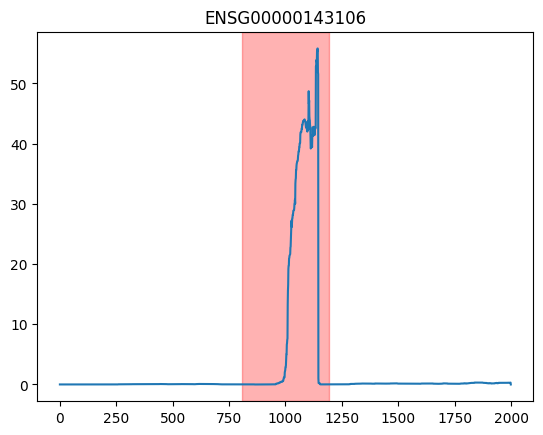

Pred: 3.359196
Actual: 0.0


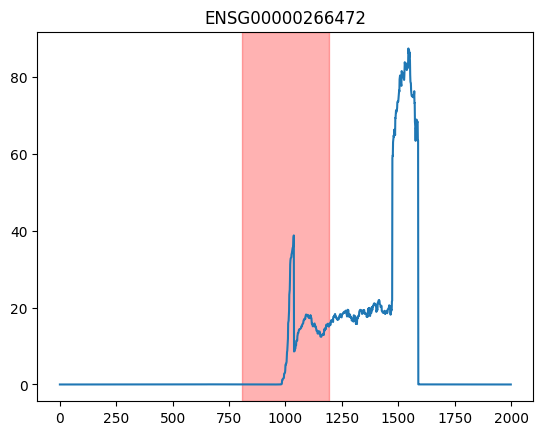

Pred: 3.7271683
Actual: 0.0


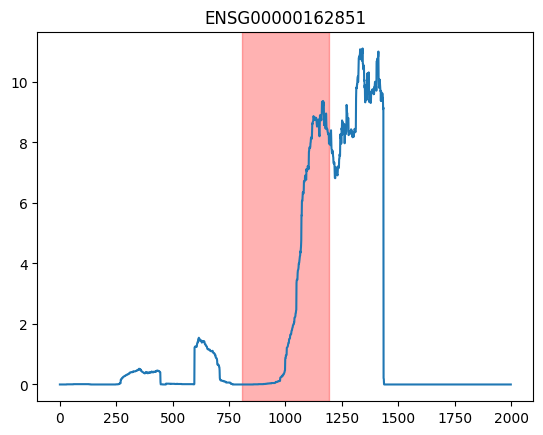

Pred: 3.5625825
Actual: 0.0


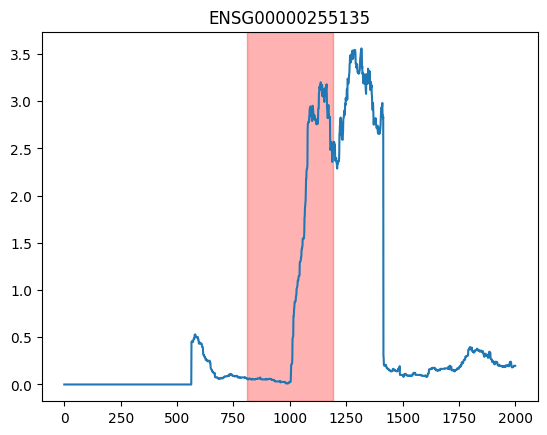

Pred: 3.3482938
Actual: 0.0


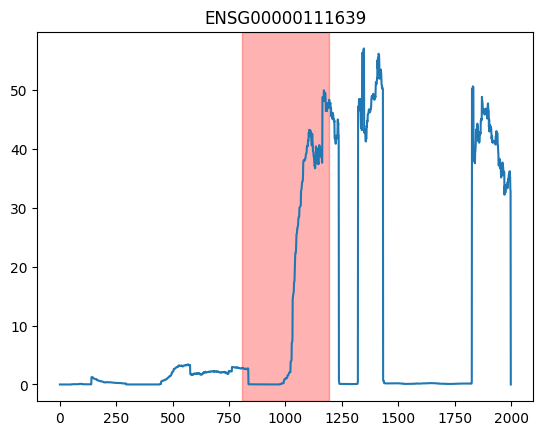

Pred: 3.3945022
Actual: 0.0


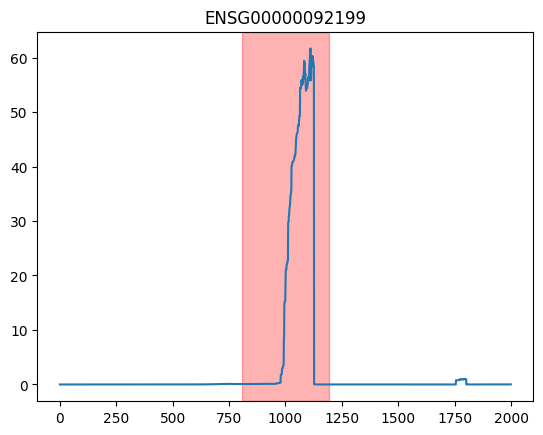

Pred: 3.9255574
Actual: 0.0


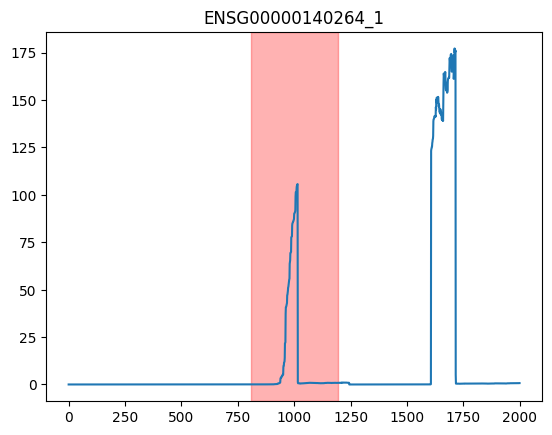

Pred: 3.2519333
Actual: 0.0


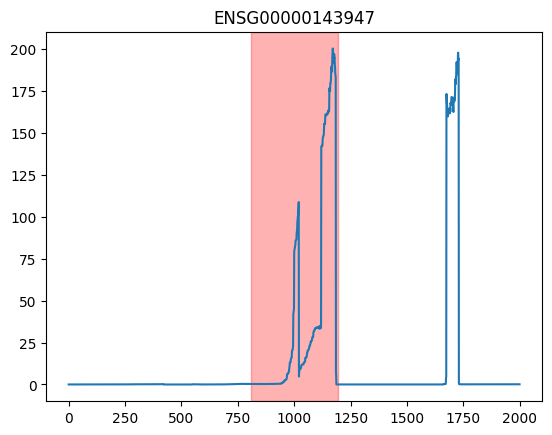

Pred: 3.4922478
Actual: 0.0


In [406]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [407]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
18043    ENSG00000202538  1.110486  5.662860         9   
19629    ENSG00000200795  0.957539  5.415317         9   
77939    ENSG00000200795  0.754349  5.147695         9   
49299    ENSG00000200795  1.276928  5.147695         9   
16694    ENSG00000199325  0.200666  3.754244         8   
2548     ENSG00000143185  0.367997  3.915335         1   
80697    ENSG00000142541  0.945669  4.377945        10   
38222    ENSG00000287398  0.460155  3.700608         3   
35458  ENSG00000003436_1  0.188475  3.424459         2   
83761    ENSG00000222177  0.057174  3.251373        11   
52604    ENSG00000142541  1.211855  4.377945        10   
42797    ENSG00000233440  0.114294  3.252559         6   
84451    ENSG00000122862  0.448682  3.565910        11   
56391    ENSG00000122862  0.448738  3.565910        11   
54759    ENSG00000222177  0.137201  3.251373        11   
64944    ENSG00000287398  0.627576  3.700608         3   
71206    ENSG00000233440  0.222033  3.252559         6   
25565    ENSG00000169715  0.538835  3.551557        11   
10746    ENSG00000232216  0.386016  3.394305         5   
66301    ENSG00000159131  0.382254  3.340085         3   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
18043             460107.0000  4.552374     -4.552374  
19629             260205.0000  4.457778     -4.457778  
77939             260205.0000  4.393346     -4.393346  
49299             260205.0000  3.870767     -3.870767  
16694               5677.6400  3.553579     -3.553579  
2548                8227.7600  3.547338     -3.547338  
80697                     NaN  3.432277     -3.432277  
38222               7016.4400  3.240452     -3.240452  
35458                 40.7504  3.235984     -3.235984  
83761                     NaN  3.194199     -3.194199  
52604                     NaN  3.166090     -3.166090  
42797                466.4000  3.138265     -3.138265  
84451              48321.6000  3.117228     -3.117228  
56391              48321.6000  3.117172     -3.117172  
54759                     NaN  3.114172     -3.114172  
64944               7016.4400  3.073032     -3.073032  
71206                466.4000  3.030527     -3.030527  
25565               3559.8800  3.012722     -3.012722  
10746               2478.1600  3.008289     -3.008289  
66301                     NaN  2.957831     -2.957831

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
35951     ENSG00000202538  1.110486  5.662860         9   
38449     ENSG00000202538  1.110486  5.662860         9   
37537     ENSG00000200795  0.957539  5.415317         9   
40035     ENSG00000200795  0.957539  5.415317         9   
149861    ENSG00000200795  0.754349  5.147695         9   
152359    ENSG00000200795  0.754349  5.147695         9   
92864     ENSG00000200795  1.276928  5.147695         9   
95362     ENSG00000200795  1.276928  5.147695         9   
32000     ENSG00000199325  0.200666  3.754244         8   
34602     ENSG00000199325  0.200666  3.754244         8   
2548      ENSG00000143185  0.367997  3.915335         1   
5334      ENSG00000143185  0.367997  3.915335         1   
63901   ENSG00000003436_1  0.188475  3.424459         2   
66494   ENSG00000003436_1  0.188475  3.424459         2   
79682     ENSG00000233440  0.114294  3.252559         6   
81671     ENSG00000233440  0.114294  3.252559         6   
161863    ENSG00000122862  0.448682  3.565910        11   
164122    ENSG00000122862  0.448682  3.565910        11   
105446    ENSG00000122862  0.448738  3.565910        11   
107705    ENSG00000122862  0.448738  3.565910        11   

        GM12878_CAGE_128*3_sum     Error  Signed Error  
35951              460107.0000  4.552374     -4.552374  
38449              460107.0000  4.552374     -4.552374  
37537              260205.0000  4.457778     -4.457778  
40035              260205.0000  4.457778     -4.457778  
149861             260205.0000  4.393346     -4.393346  
152359             260205.0000  4.393346     -4.393346  
92864              260205.0000  3.870767     -3.870767  
95362              260205.0000  3.870767     -3.870767  
32000                5677.6400  3.553579     -3.553579  
34602                5677.6400  3.553579     -3.553579  
2548                 8227.7600  3.547338     -3.547338  
5334                 8227.7600  3.547338     -3.547338  
63901                  40.7504  3.235984     -3.235984  
66494                  40.7504  3.235984     -3.235984  
79682                 466.4000  3.138265     -3.138265  
81671                 466.4000  3.138265     -3.138265  
161863              48321.6000  3.117228     -3.117228  
164122              48321.6000  3.117228     -3.117228  
105446              48321.6000  3.117172     -3.117172  
107705              48321.6000  3.117172     -3.117172

GM12878: 


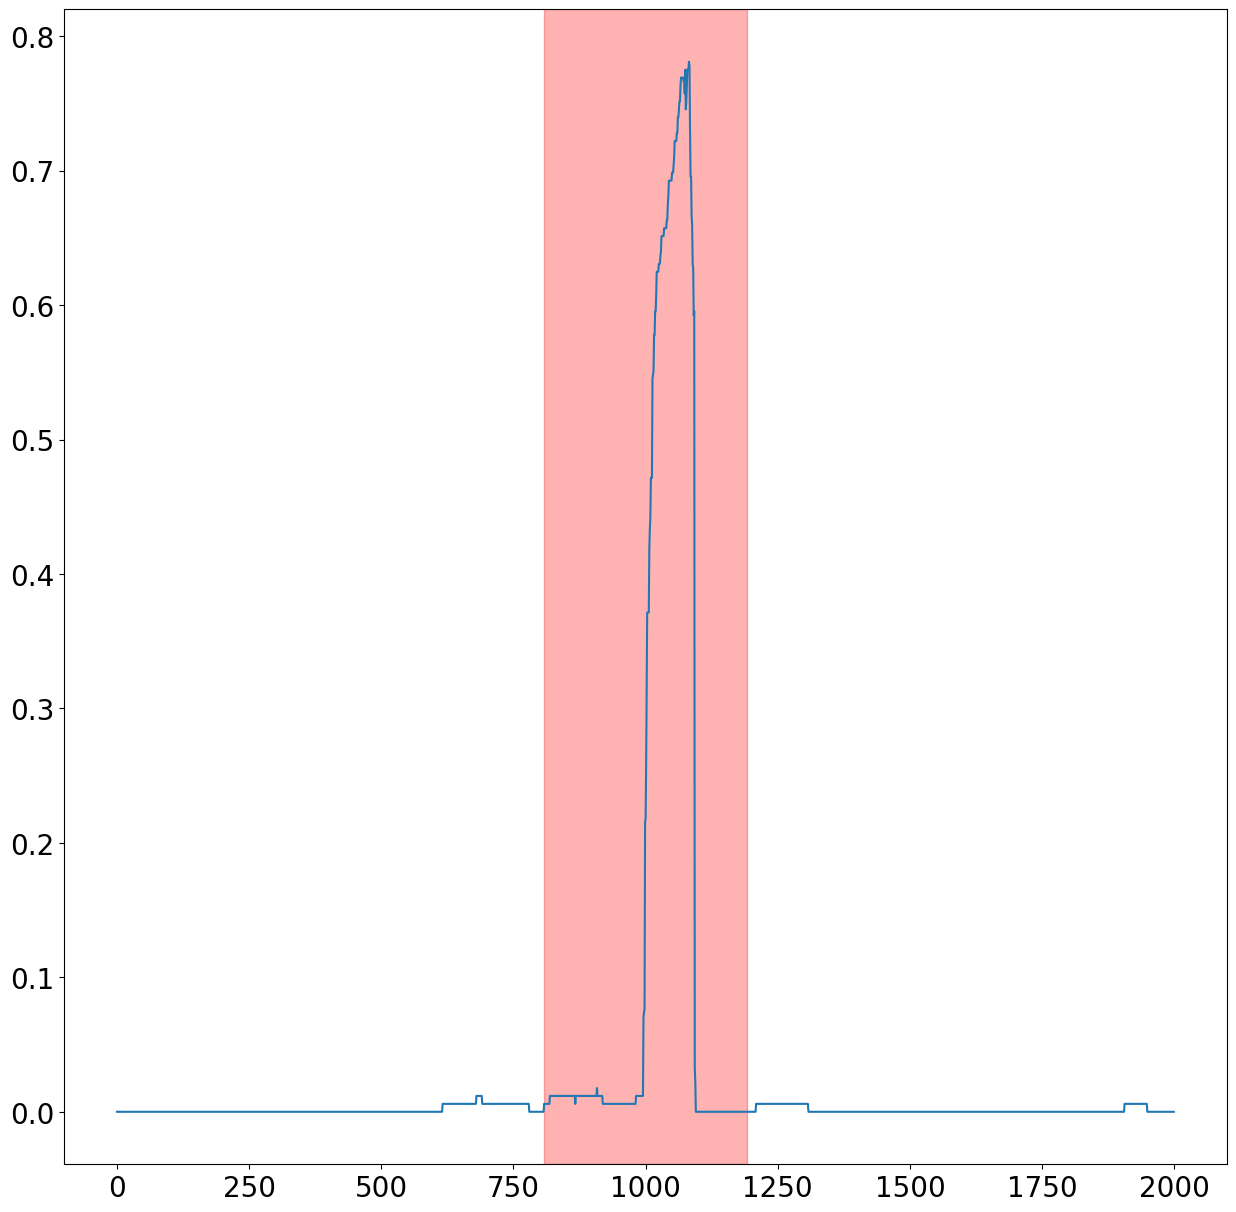

ENSG00000143185
Pred: 0.36799687
Actual: 3.9153345


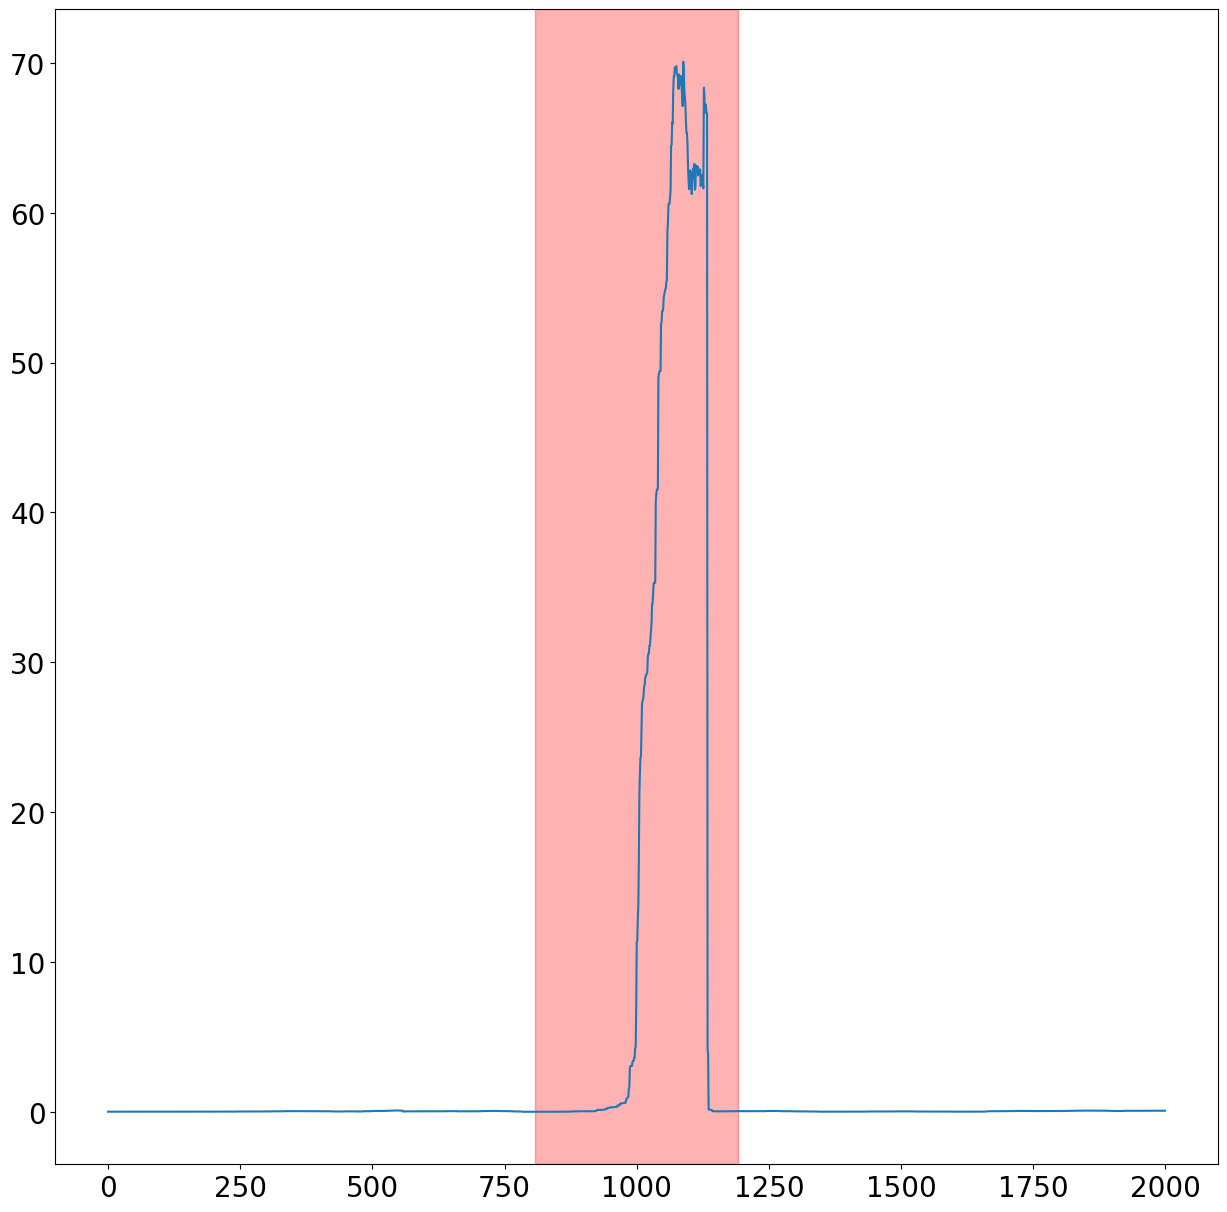

ENSG00000122862
Pred: 0.44868228
Actual: 3.5659103


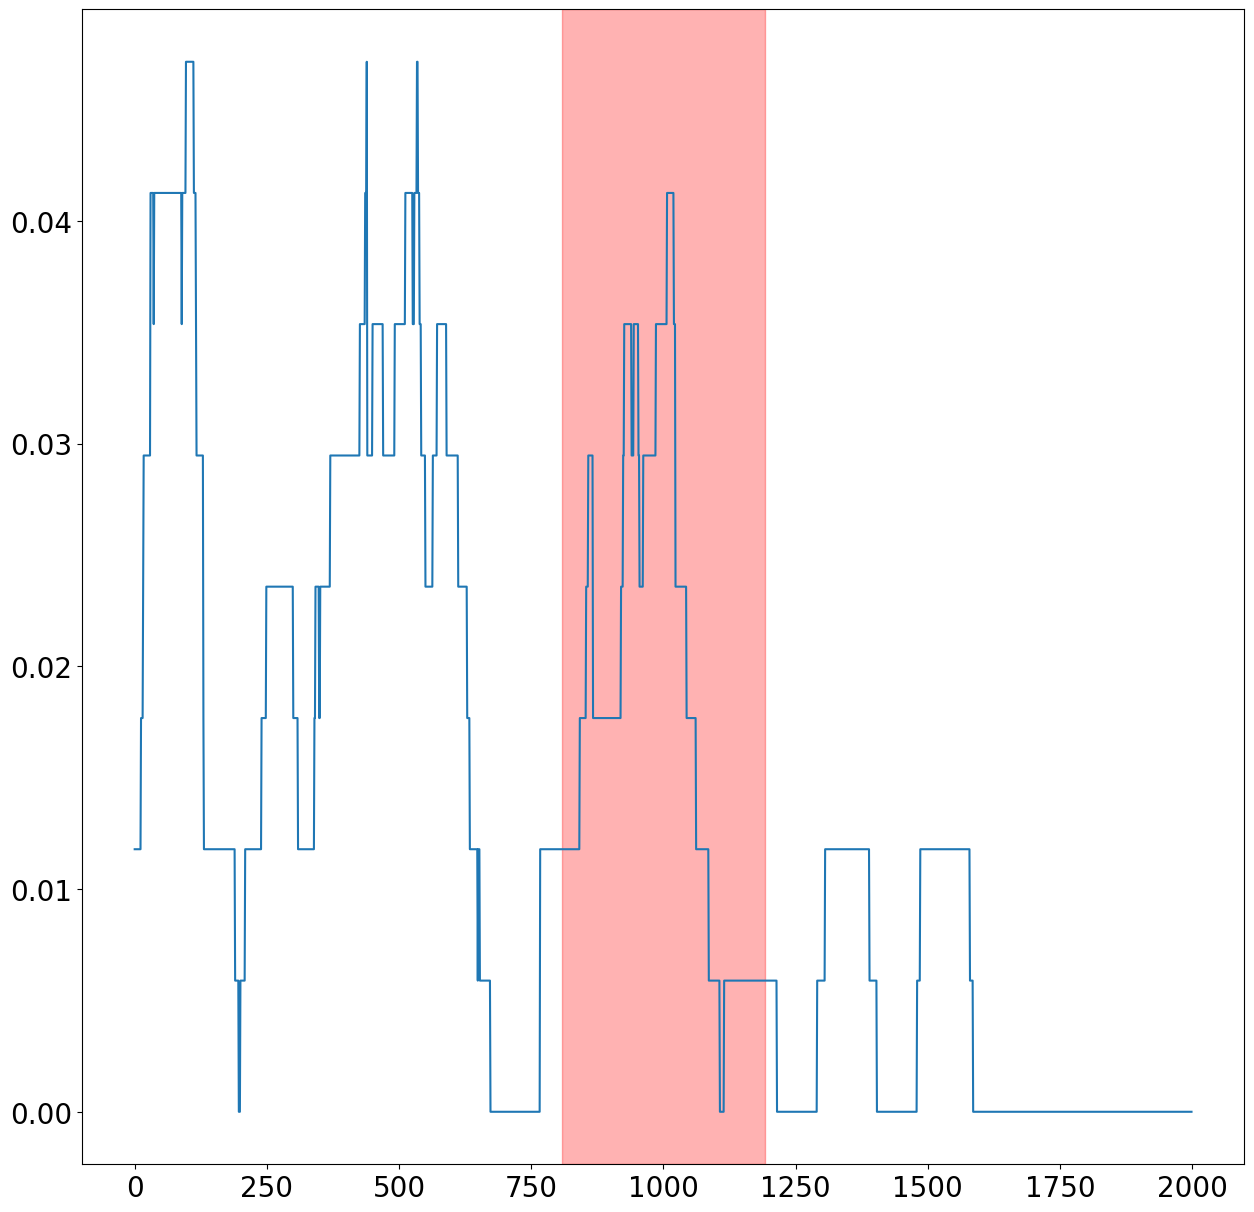

ENSG00000199325
Pred: 0.2006657
Actual: 3.7542443


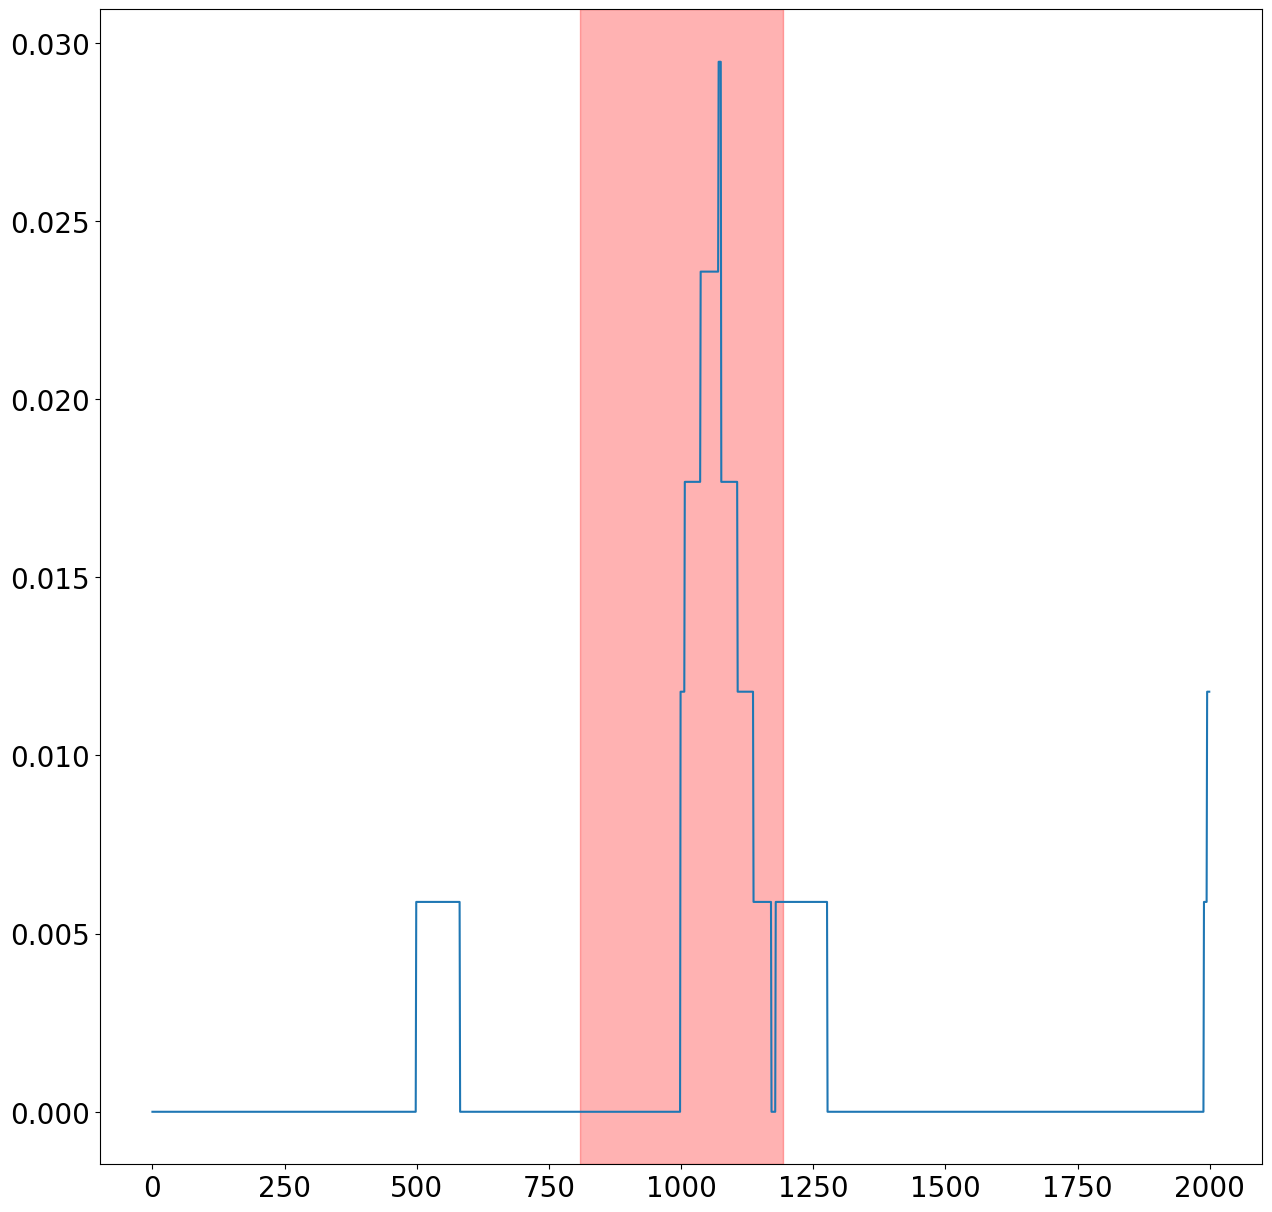

ENSG00000202538
Pred: 1.1104861
Actual: 5.66286


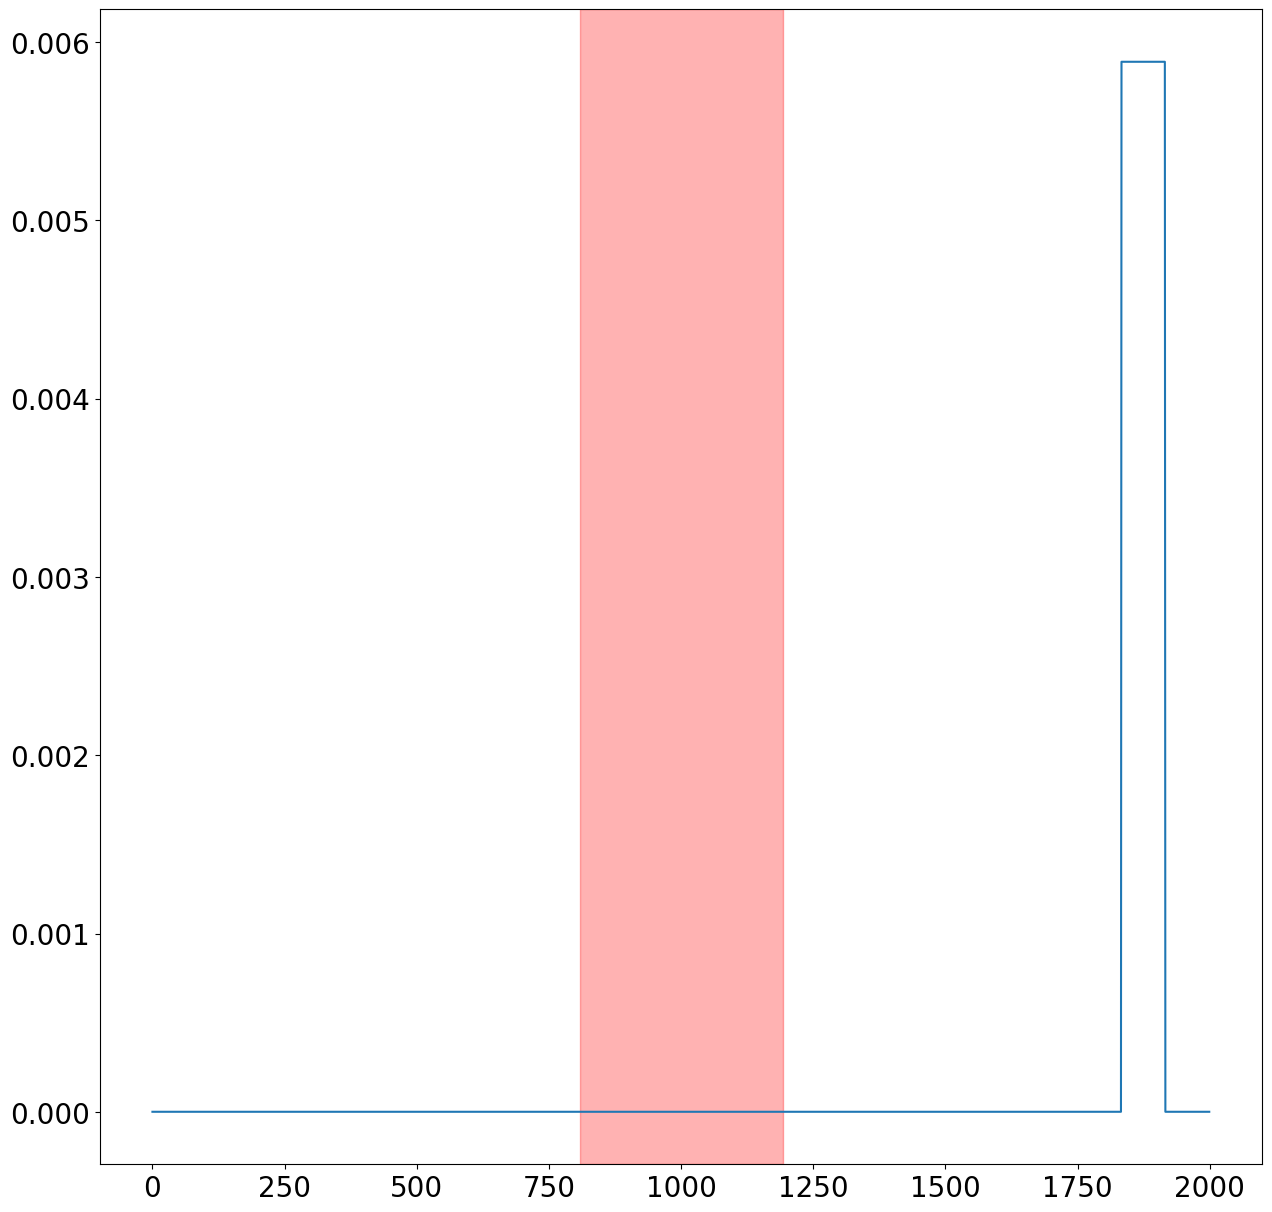

ENSG00000200795
Pred: 0.9575392
Actual: 5.4153175


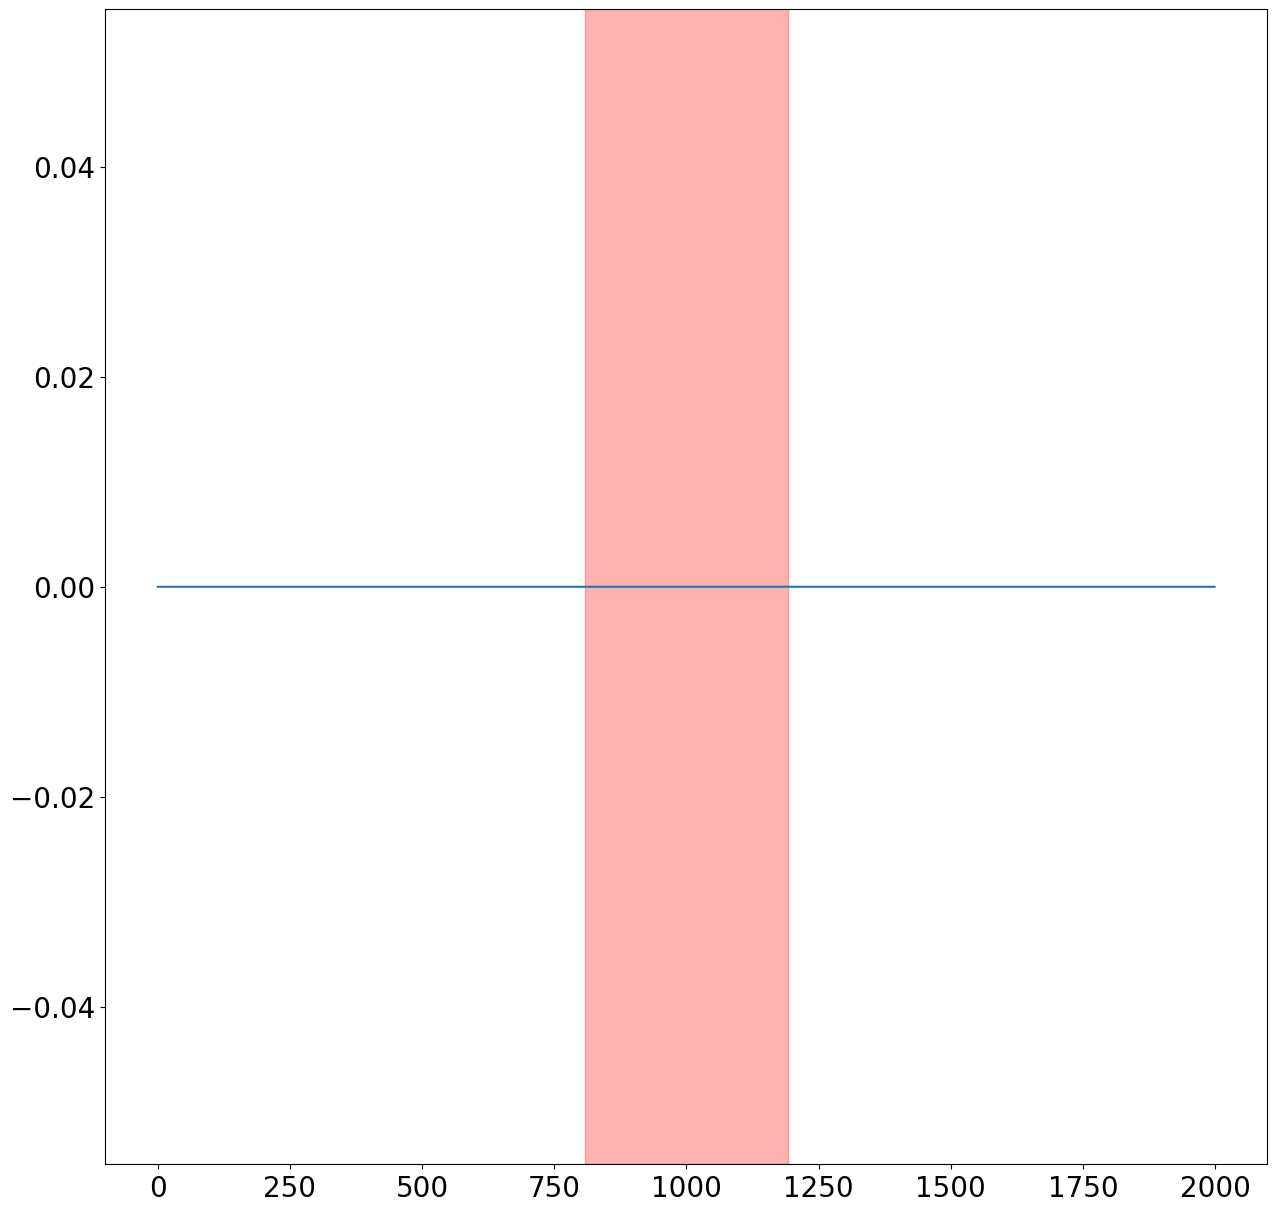

ENSG00000233440
Pred: 0.11429409
Actual: 3.2525594


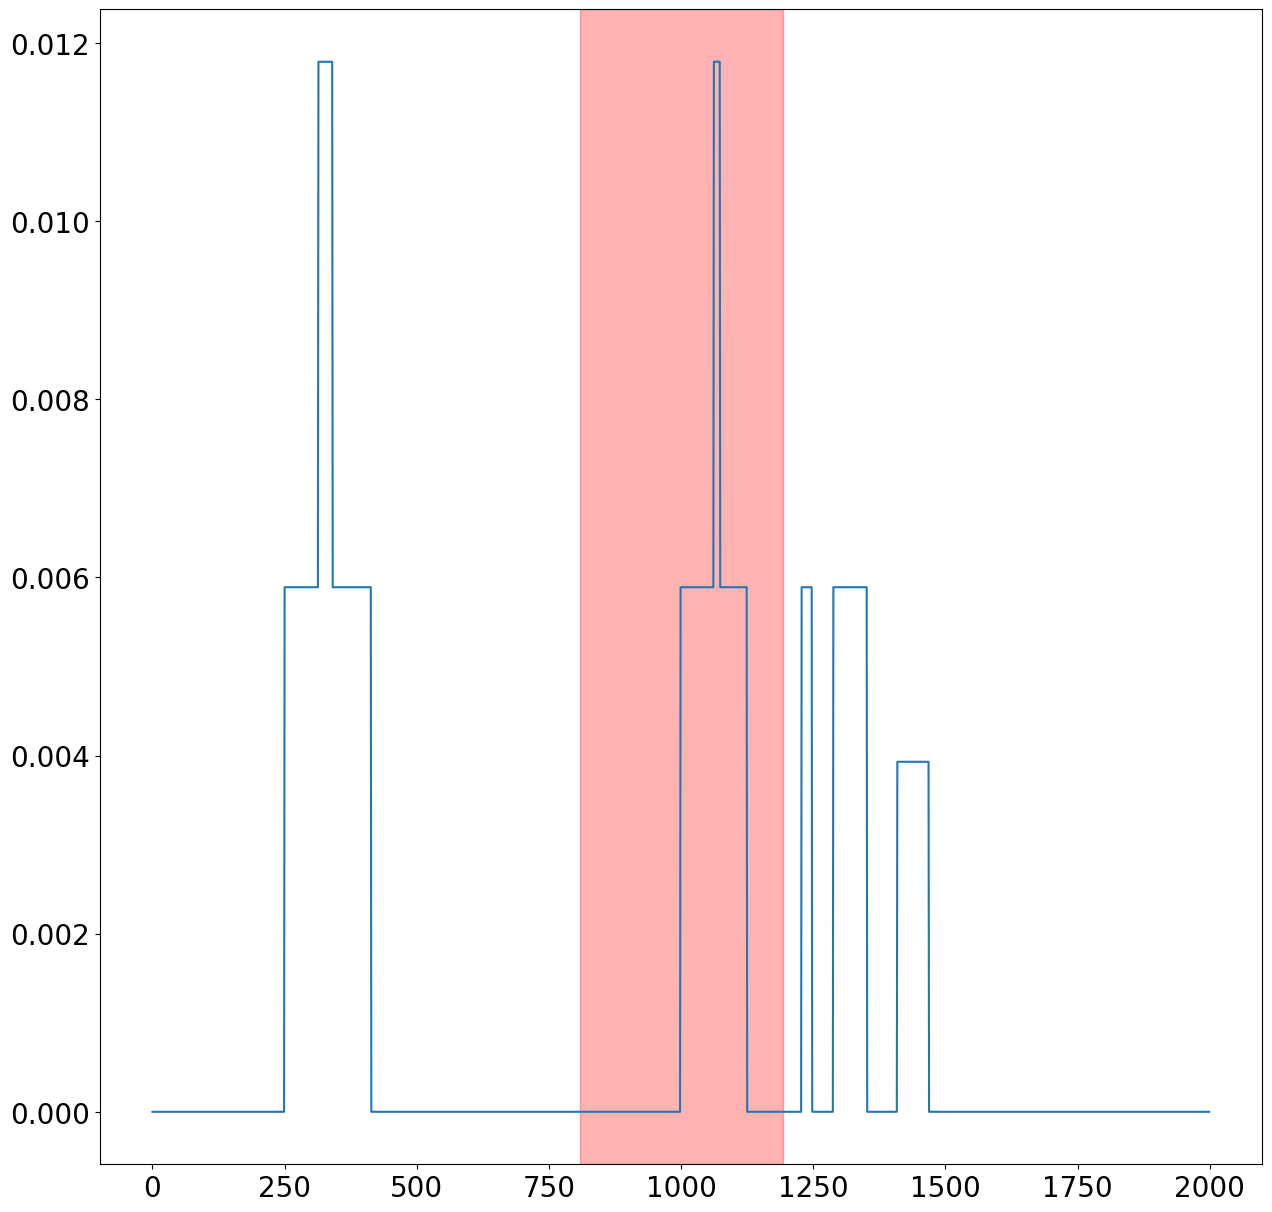

ENSG00000232216
Pred: 0.38601583
Actual: 3.3943045


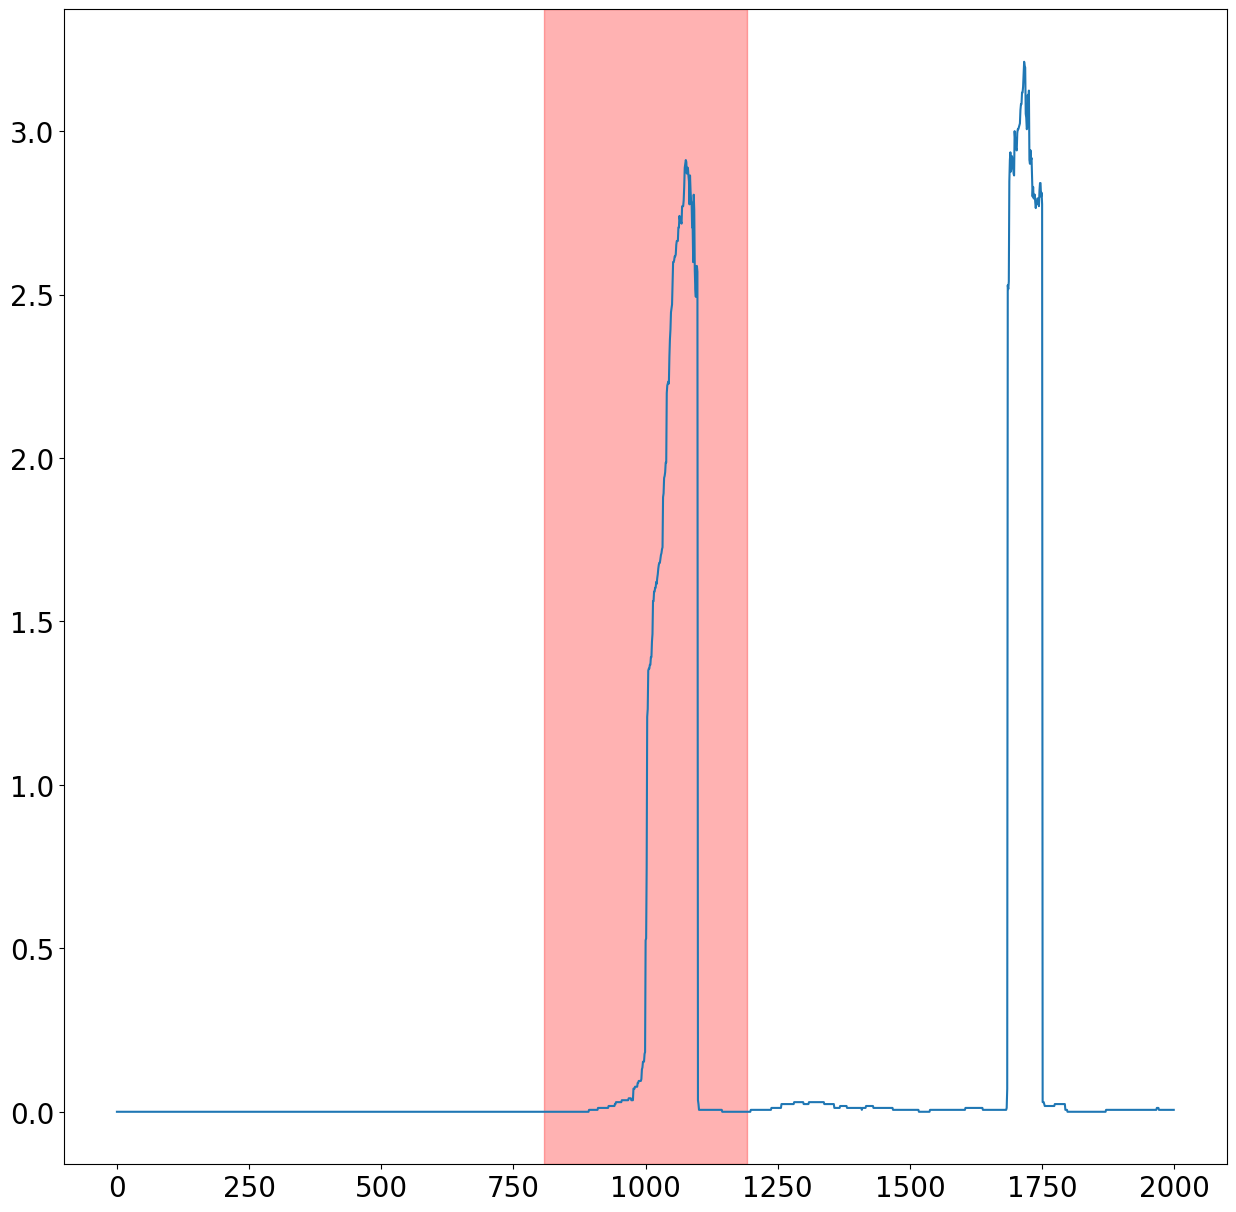

ENSG00000169715
Pred: 0.53883505
Actual: 3.5515573


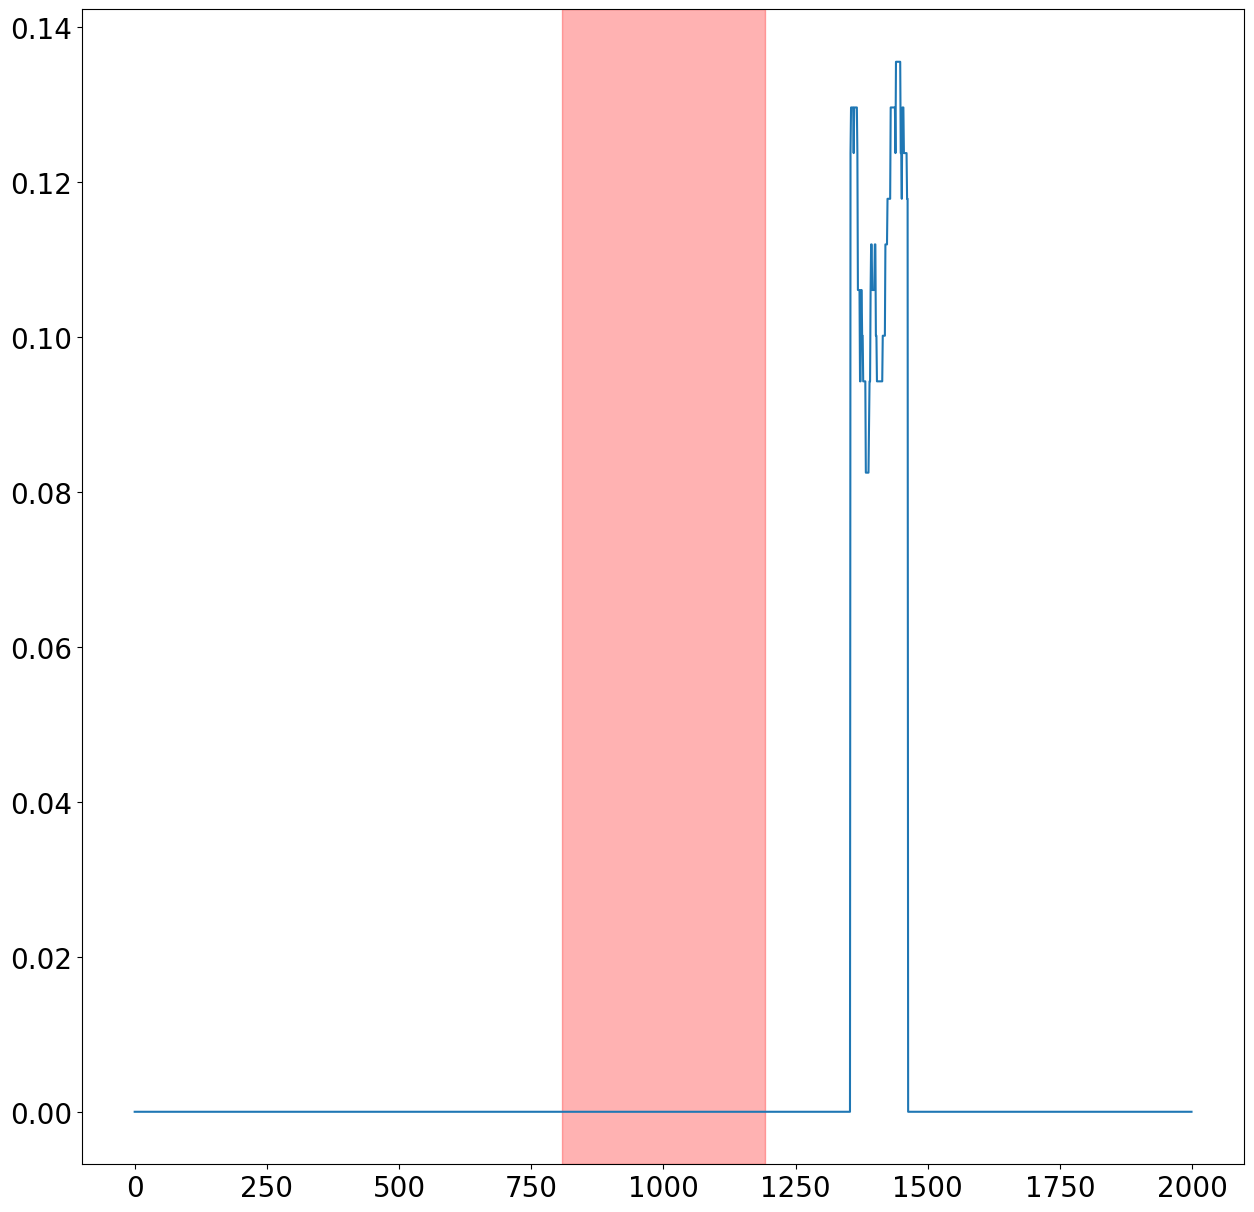

ENSG00000222177
Pred: 0.057173707
Actual: 3.251373


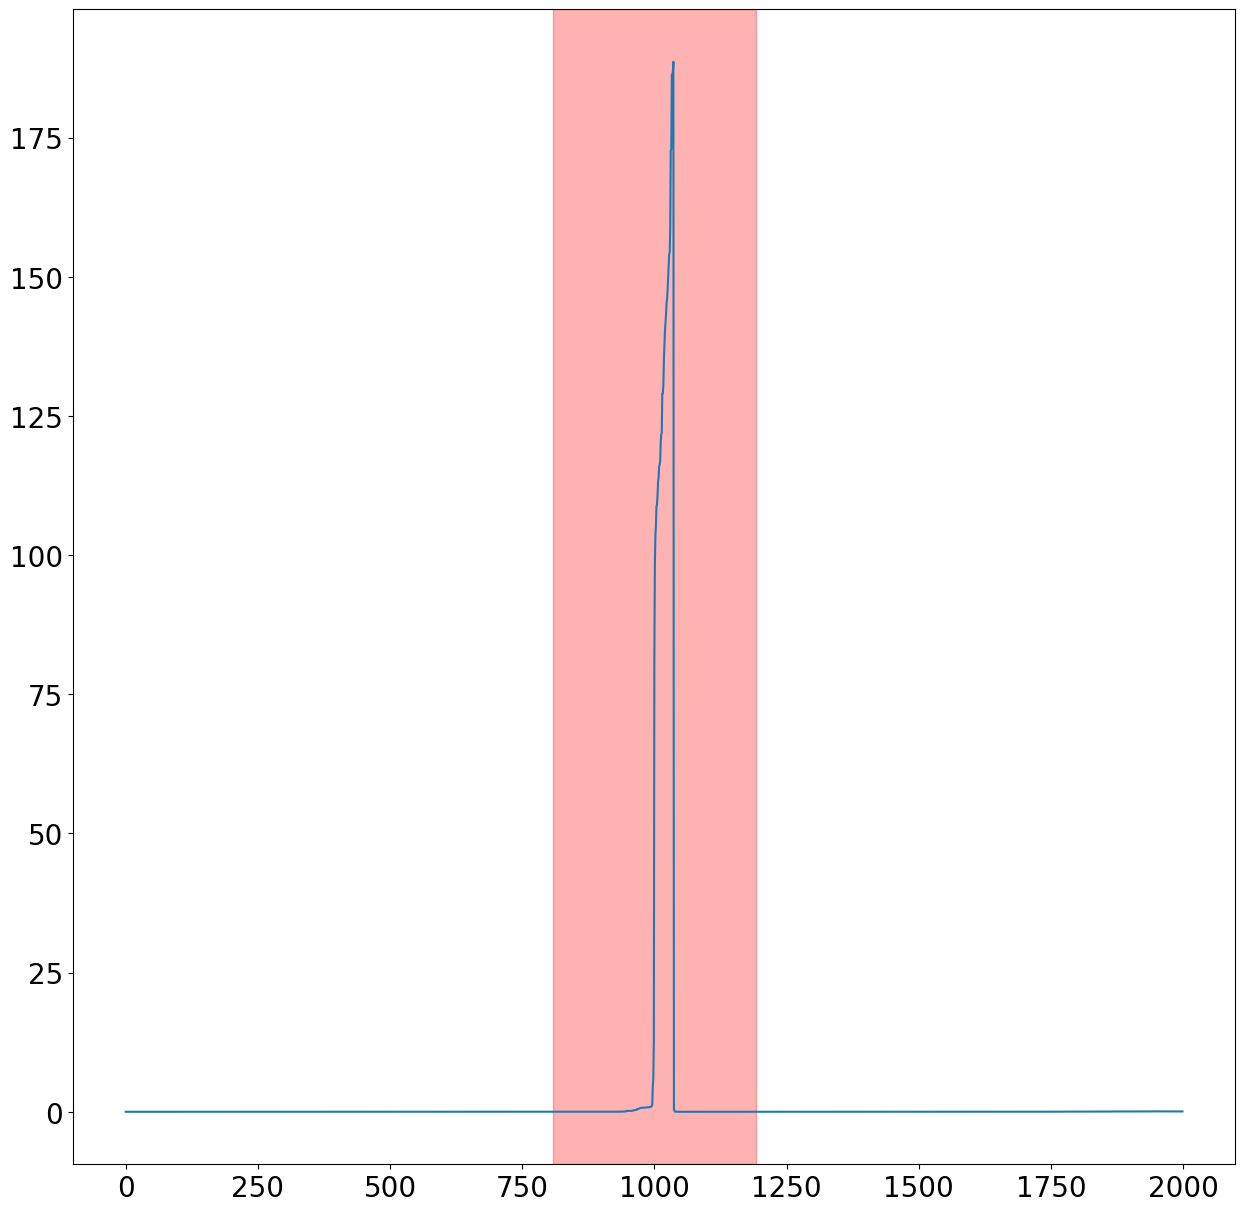

ENSG00000142541
Pred: 0.9456686
Actual: 4.3779454


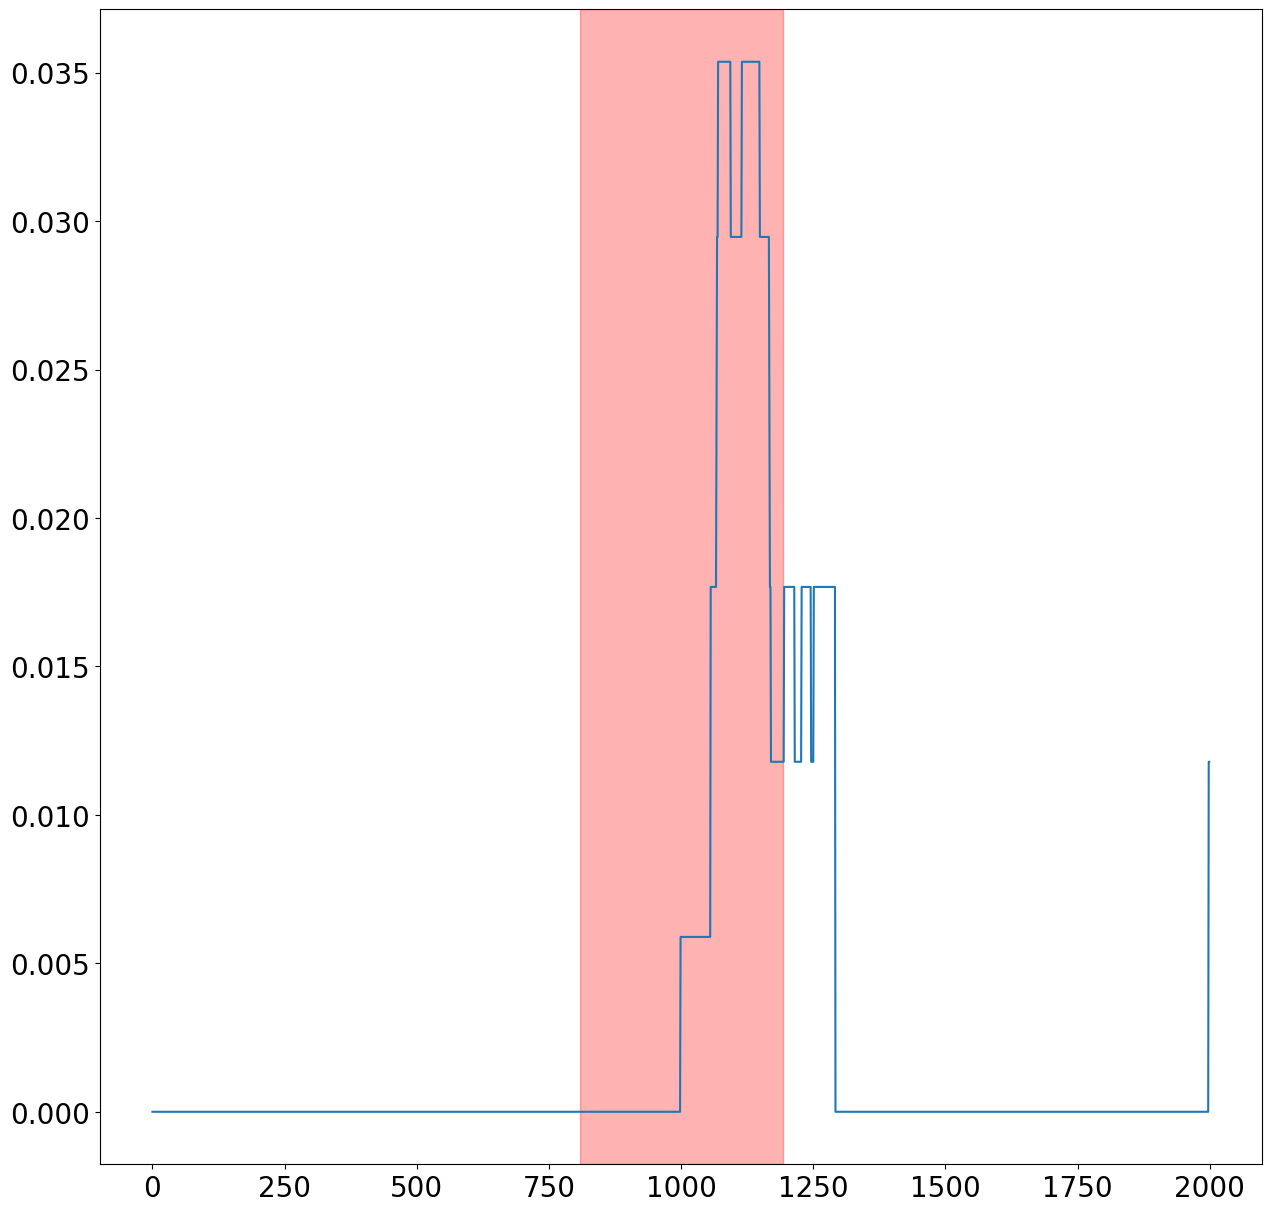

ENSG00000003436_1
Pred: 0.18847461
Actual: 3.4244585


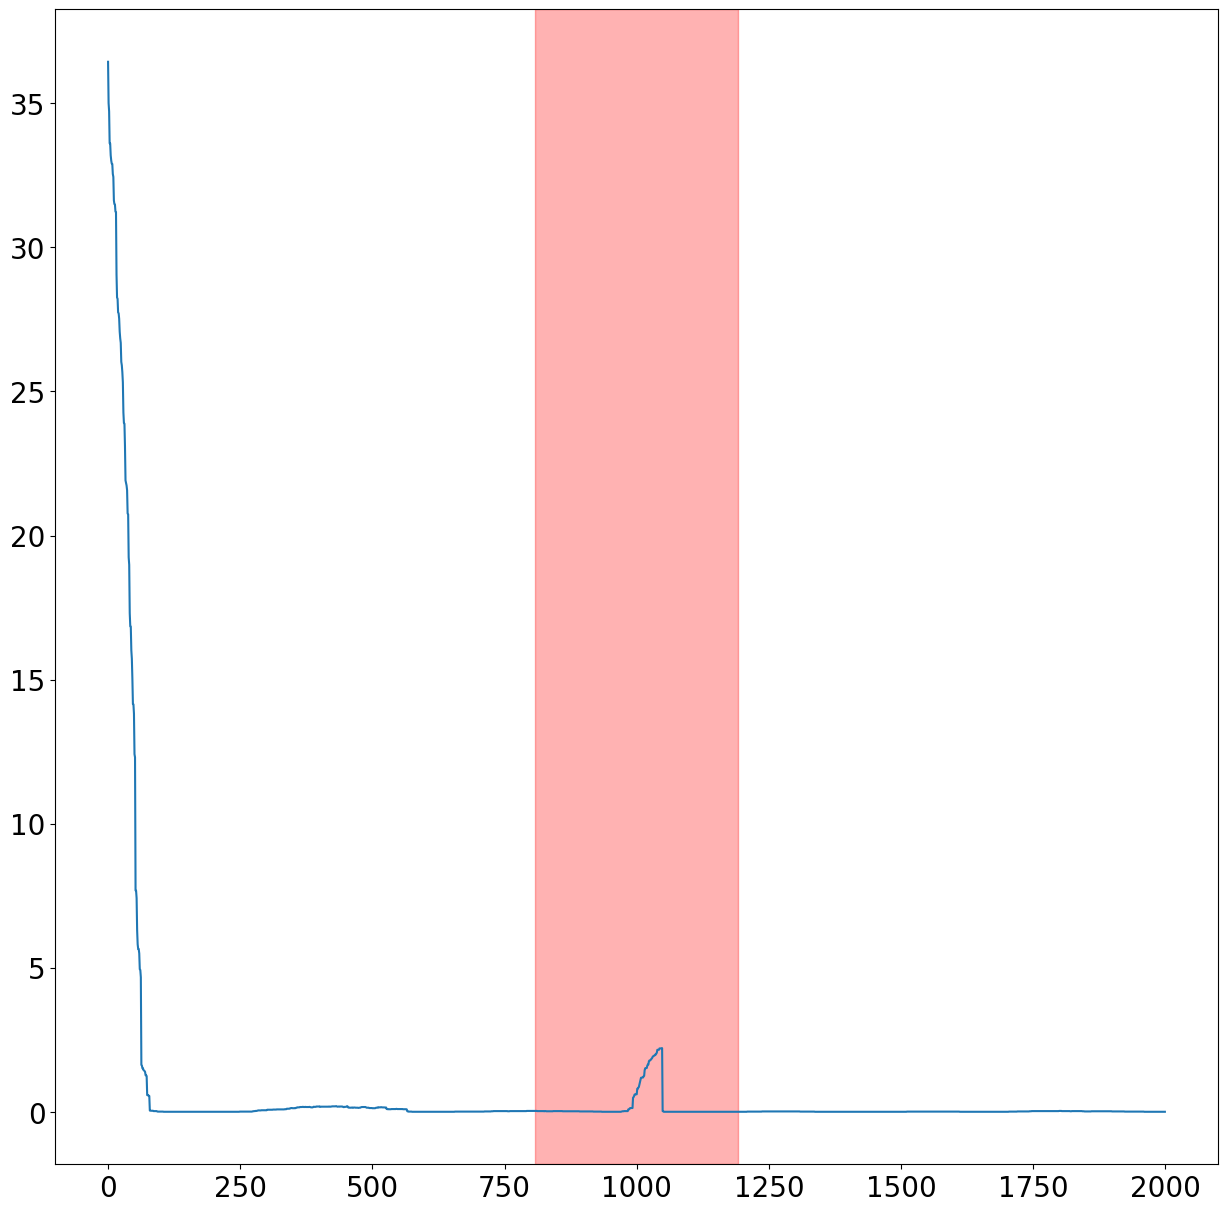

ENSG00000159131
Pred: 0.3822542
Actual: 3.340085


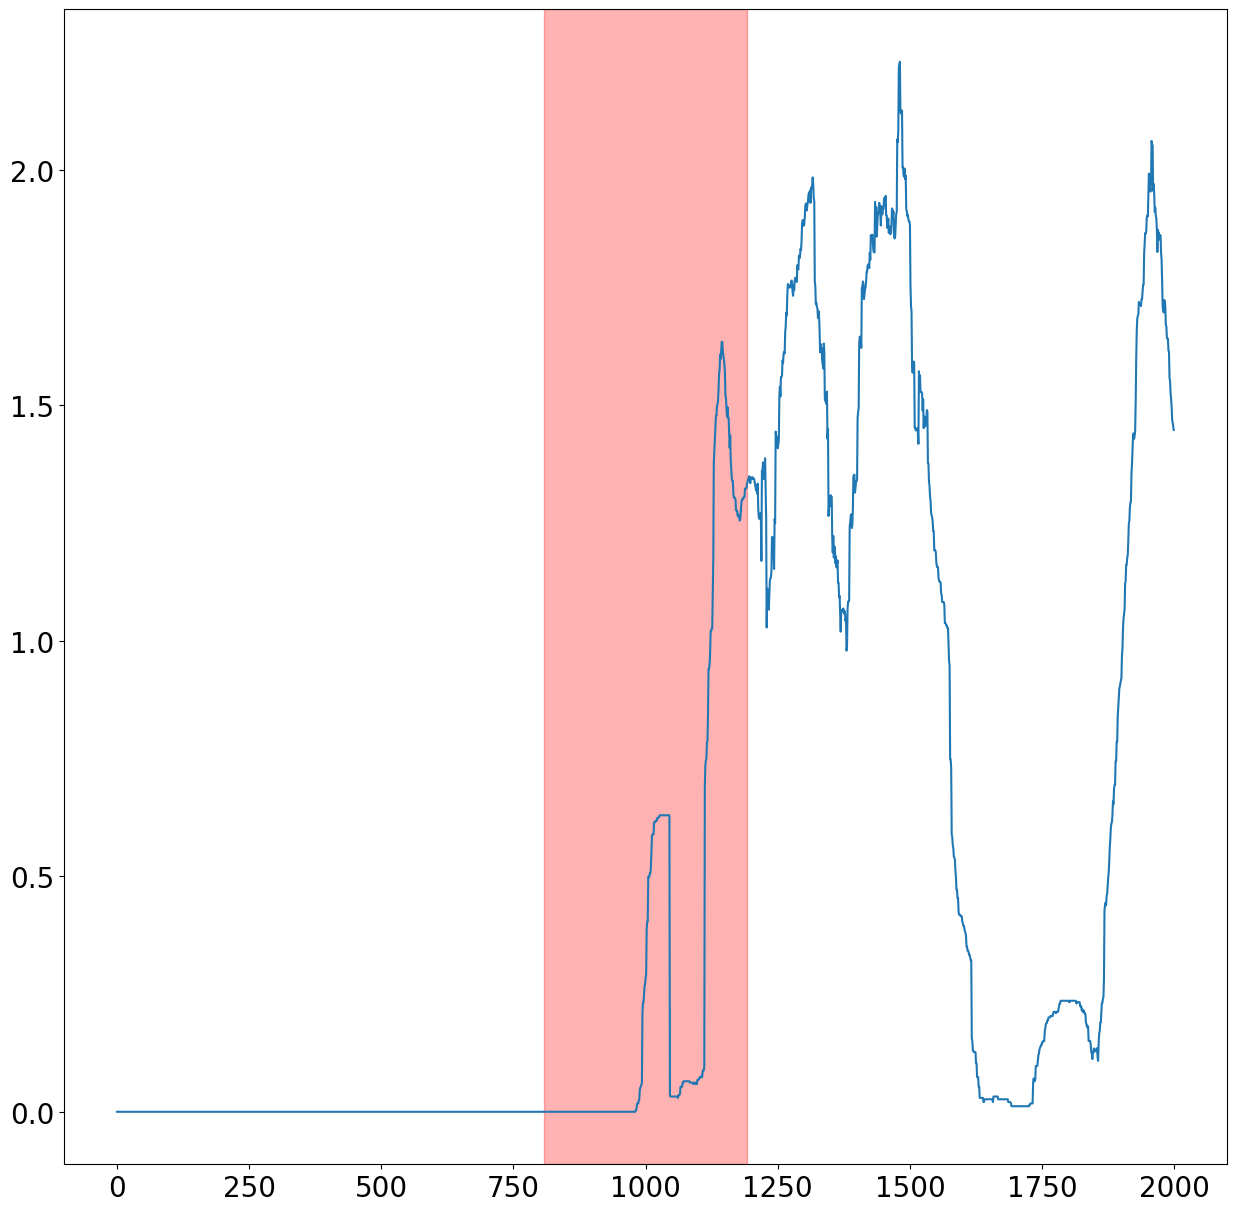

ENSG00000287398
Pred: 0.4601553
Actual: 3.7006078


In [416]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [ ]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
5234     ENSG00000071967  2.280791  2.280820         2   
10316    ENSG00000100448  0.388099  0.388067         5   
64525  ENSG00000077380_1  2.544437  2.544399         2   
63627    ENSG00000135638  1.893482  1.893429         2   
40144    ENSG00000258874 -0.000074  0.000000         5   
33023    ENSG00000241794 -0.000114  0.000000         1   
51955    ENSG00000104938 -0.000115  0.000000        10   
4675     ENSG00000134318  2.148365  2.148482         2   
33182    ENSG00000228382  0.000131  0.000000         1   
24394    ENSG00000103264  2.487153  2.487326        11   
59147    ENSG00000167889  1.762107  1.762318        12   
32342    ENSG00000143184  0.000229  0.000000         1   
3502   ENSG00000159374_1  1.087415  1.087178         2   
15898  ENSG00000137497_2  1.389320  1.389067         8   
68254    ENSG00000251870  0.000298  0.000000         4   
25480    ENSG00000102974  2.835364  2.835043        11   
34097    ENSG00000138379  0.000321  0.000000         2   
18212  ENSG00000094914_1  2.933462  2.933811         9   
1903     ENSG00000204219  1.093719  1.094094         1   
26526    ENSG00000172123  1.354854  1.355233        12   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
5234                189.90600  0.000029     -0.000029  
10316                 1.44381  0.000032      0.000032  
64525               344.85400  0.000037      0.000037  
63627                72.21500  0.000053      0.000053  
40144                     NaN  0.000074     -0.000074  
33023                     NaN  0.000114     -0.000114  
51955                 2.82230  0.000115     -0.000115  
4675                139.76100  0.000117     -0.000117  
33182                     NaN  0.000131      0.000131  
24394               306.13300  0.000174     -0.000174  
59147                52.31000  0.000211     -0.000211  
32342                     NaN  0.000229      0.000229  
3502                 11.22300  0.000237      0.000237  
15898                23.49440  0.000253      0.000253  
68254                     NaN  0.000298      0.000298  
25480               682.98000  0.000320      0.000320  
34097                     NaN  0.000321      0.000321  
18212               857.64000  0.000349     -0.000349  
1903                 11.41920  0.000375     -0.000375  
26526                21.65860  0.000379     -0.000379

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
8020    ENSG00000071967  2.280791  2.280820         2               189.90600   
10613   ENSG00000071967  2.280791  2.280820         2               189.90600   
19221   ENSG00000100448  0.388099  0.388067         5                 1.44381   
21544   ENSG00000100448  0.388099  0.388067         5                 1.44381   
120427  ENSG00000135638  1.893482  1.893429         2                72.21500   
123020  ENSG00000135638  1.893482  1.893429         2                72.21500   
165226  ENSG00000205899  1.368203  1.368268        12                42.03700   
167926  ENSG00000205899  1.368203  1.368268        12                42.03700   
74706   ENSG00000258874 -0.000074  0.000000         5                     NaN   
77029   ENSG00000258874 -0.000074  0.000000         5                     NaN   
58680   ENSG00000241794 -0.000114  0.000000         1                     NaN   
61466   ENSG00000241794 -0.000114  0.000000         1                     NaN   
98018   ENSG00000104938 -0.000115  0.000000        10                 2.82230   
101010  ENSG00000104938 -0.000115  0.000000        10                 2.82230   
58839   ENSG00000228382  0.000131  0.000000         1                     NaN   
61625   ENSG00000228382  0.000131  0.000000         1                     NaN   
47792   ENSG00000103264  2.487153  2.487326        11               306.13300   
50051   ENSG00000103264  2.487153  2.487326        11               306.13300   
110461  ENSG00000167889  1.762107  1.762318        12                52.31000   
113161  ENSG00000167889  1.762107  1.762318        12                52.31000   

           Error  Signed Error  
8020    0.000029     -0.000029  
10613   0.000029     -0.000029  
19221   0.000032      0.000032  
21544   0.000032      0.000032  
120427  0.000053      0.000053  
123020  0.000053      0.000053  
165226  0.000065     -0.000065  
167926  0.000065     -0.000065  
74706   0.000074     -0.000074  
77029   0.000074     -0.000074  
58680   0.000114     -0.000114  
61466   0.000114     -0.000114  
98018   0.000115     -0.000115  
101010  0.000115     -0.000115  
58839   0.000131      0.000131  
61625   0.000131      0.000131  
47792   0.000174     -0.000174  
50051   0.000174     -0.000174  
110461  0.000211     -0.000211  
113161  0.000211     -0.000211

GM12878: 


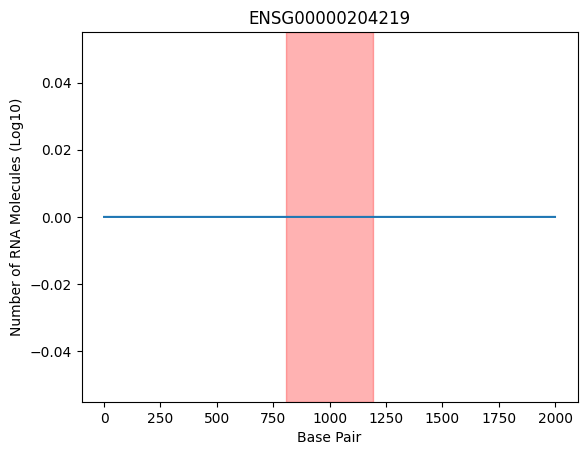

Pred: 1.0153644
Actual: 0.0


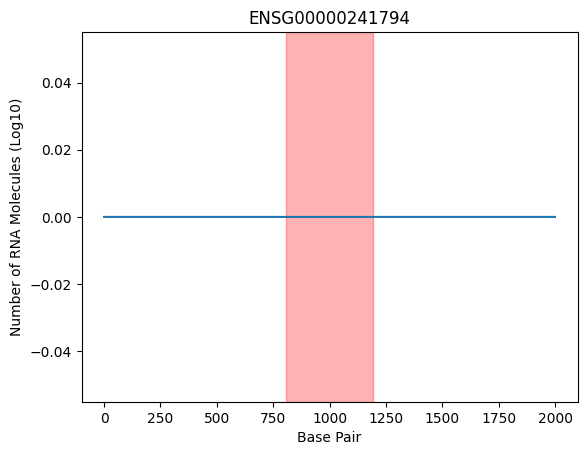

Pred: 0.097665995
Actual: 0.0


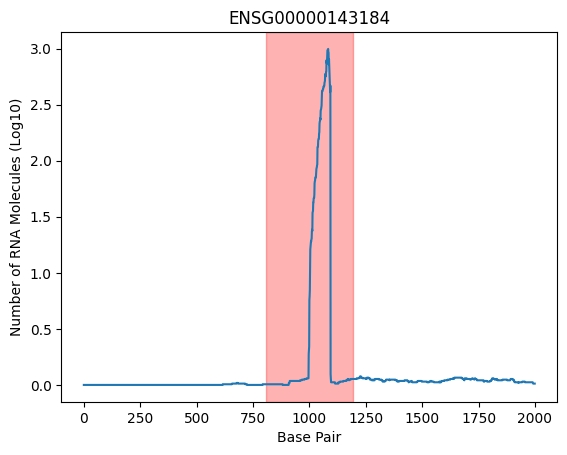

Pred: 0.6648157
Actual: 0.0


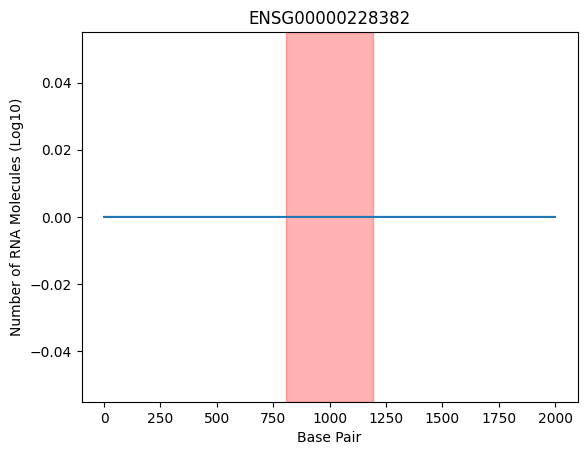

Pred: 0.48723352
Actual: 0.0


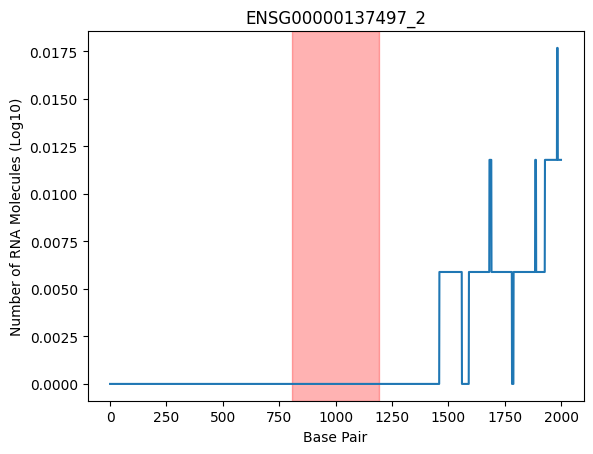

Pred: 0.90727025
Actual: 0.0


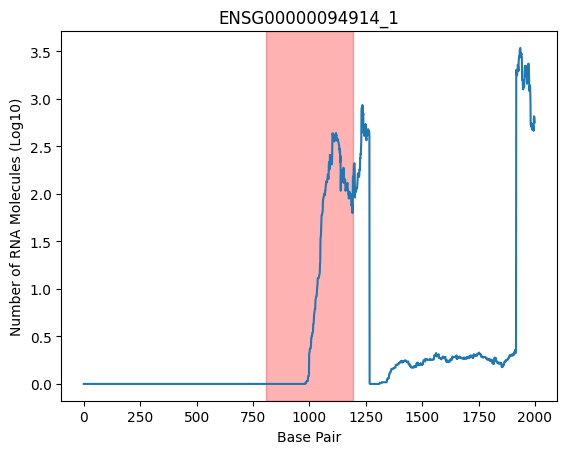

Pred: 3.4448247
Actual: 2.9822214


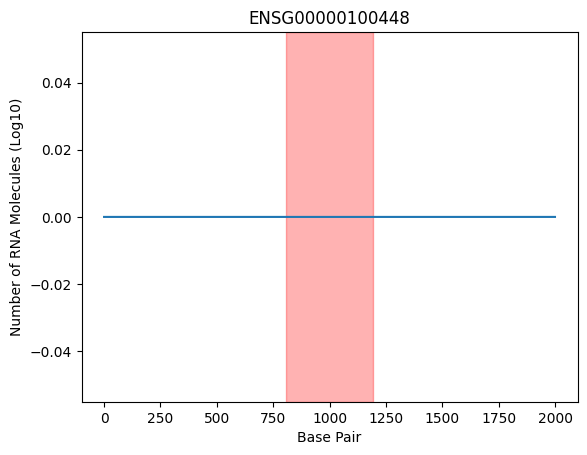

Pred: 0.12954402
Actual: 0.0


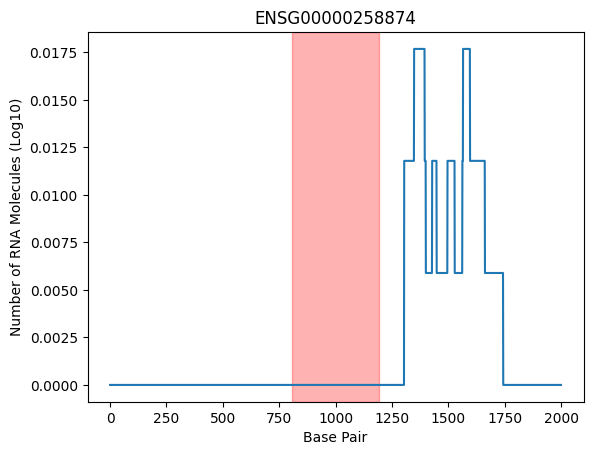

Pred: 0.2689843
Actual: 0.0


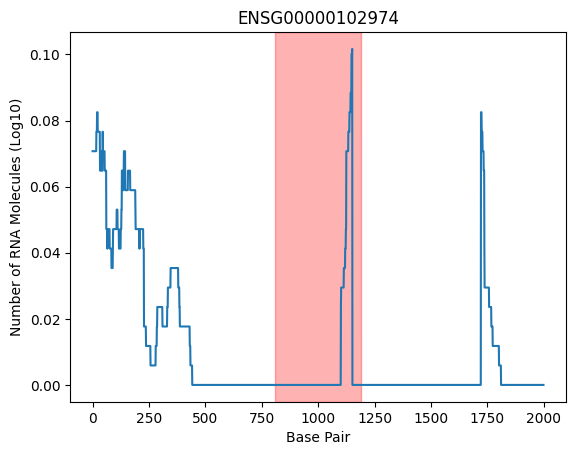

Pred: 2.9255474
Actual: 2.6974385


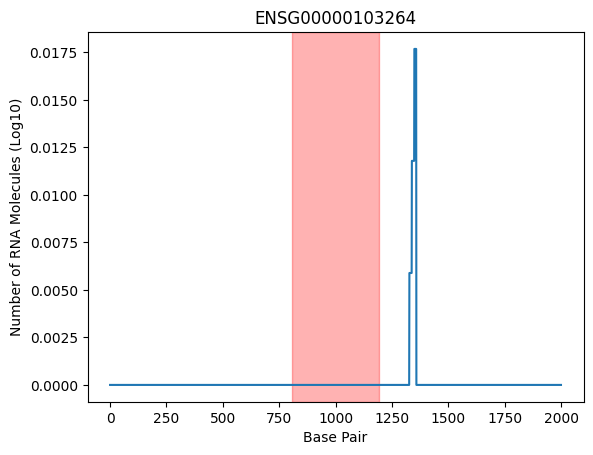

Pred: 2.4289865
Actual: 2.472417


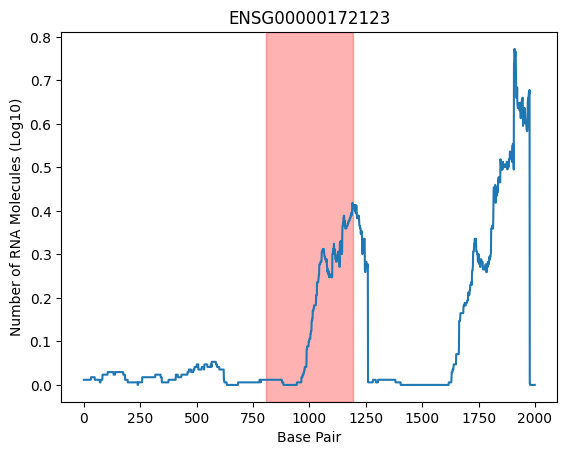

Pred: 0.13132624
Actual: 0.7626035


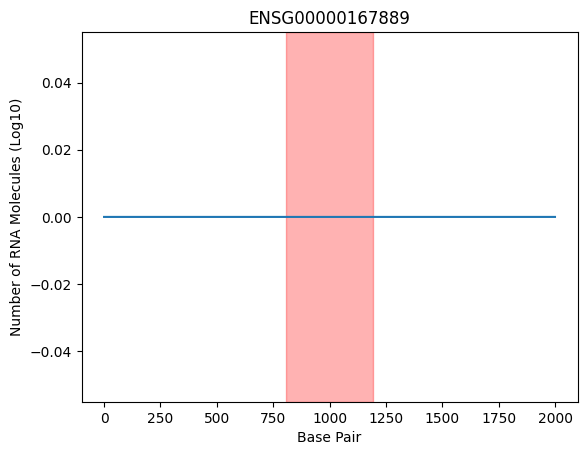

Pred: 1.7292165
Actual: 1.7268087


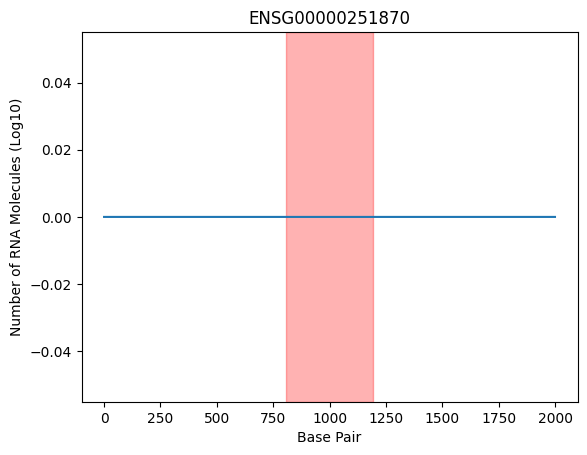

Pred: 0.08783353
Actual: 0.0


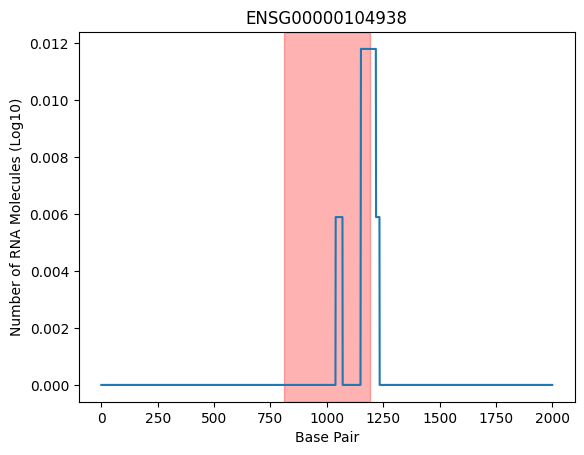

Pred: 0.108493805
Actual: 0.58232474


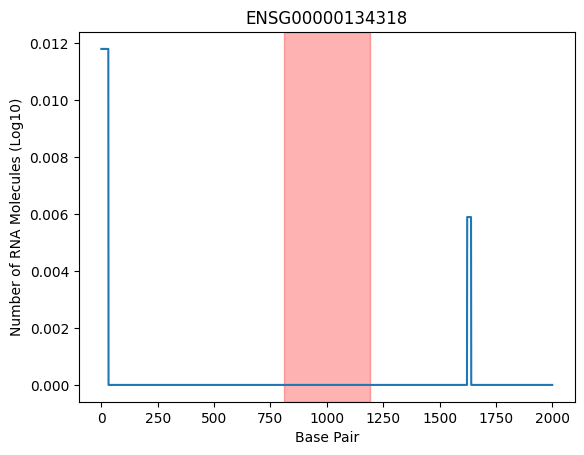

Pred: 2.4482405
Actual: 2.180748


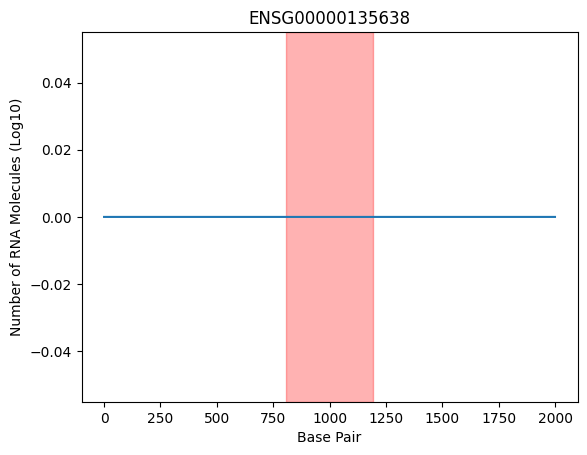

Pred: 1.5915451
Actual: 1.8934288


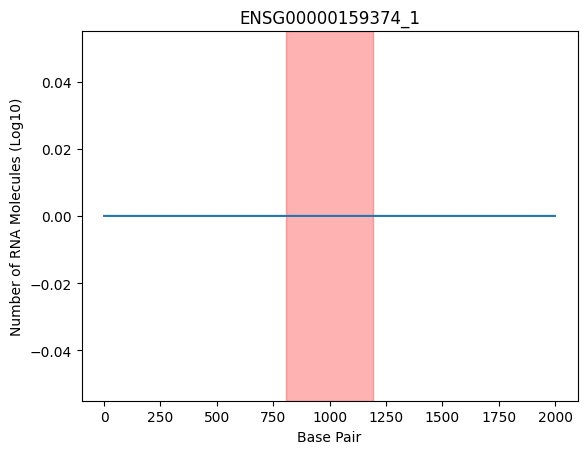

Pred: 1.5198369
Actual: 0.0


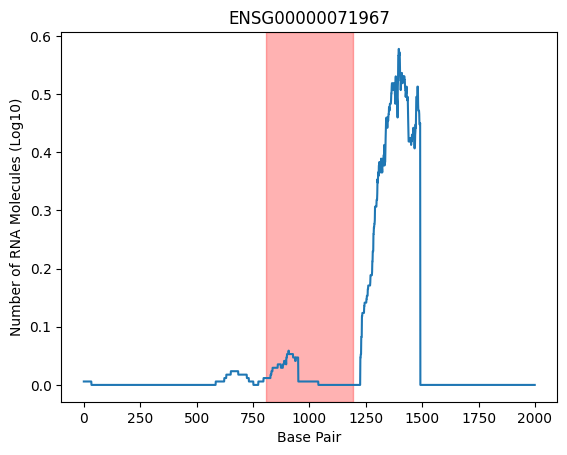

Pred: 2.7151768
Actual: 2.38166


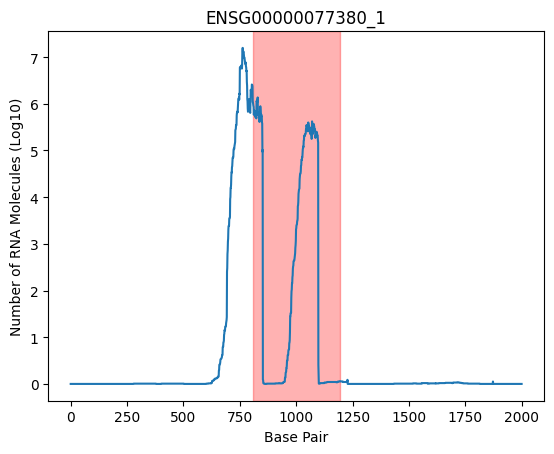

Pred: 2.1059473
Actual: 2.5443993


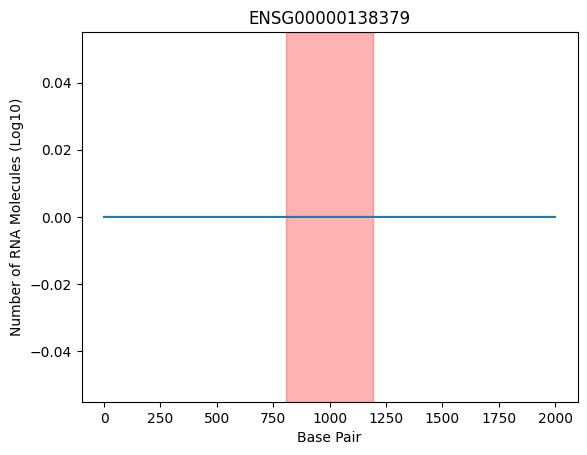

Pred: 0.12571548
Actual: 0.0

K562: 


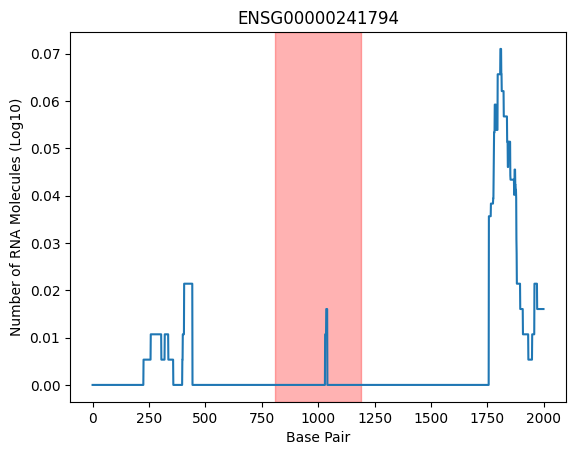

Pred: 0.097665995
Actual: 0.0


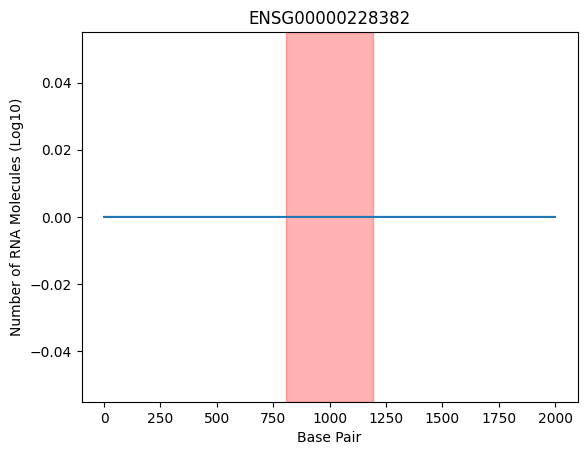

Pred: 0.48723352
Actual: 0.0


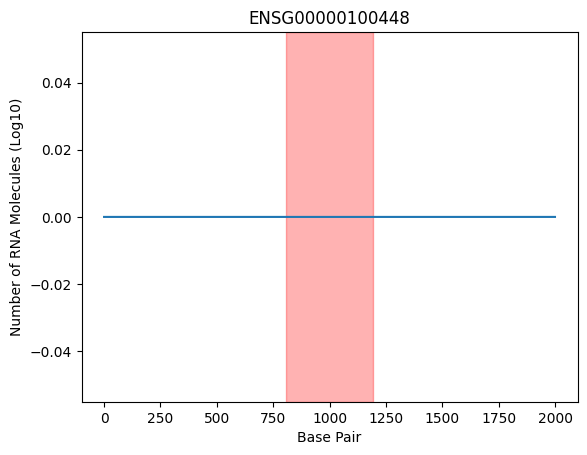

Pred: 0.12954402
Actual: 0.0


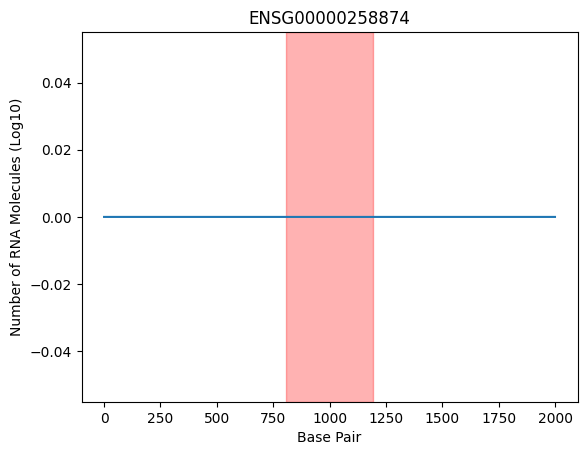

Pred: 0.2689843
Actual: 0.0


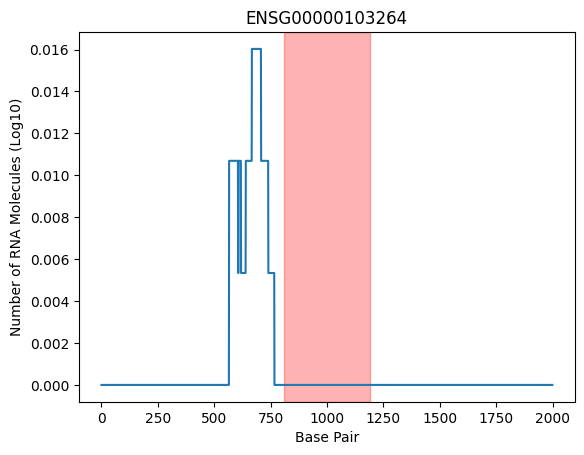

Pred: 2.4289865
Actual: 2.472417


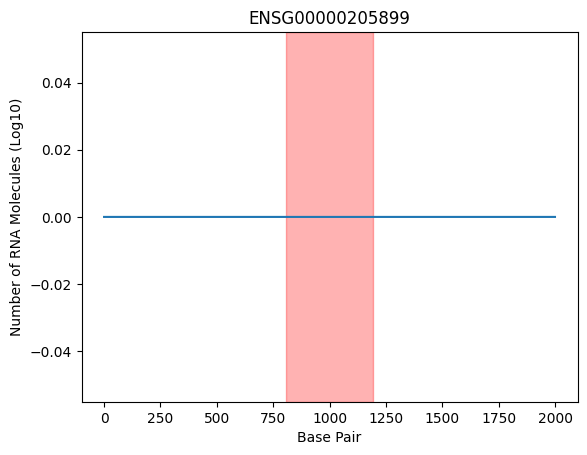

Pred: 1.013606
Actual: 1.633842


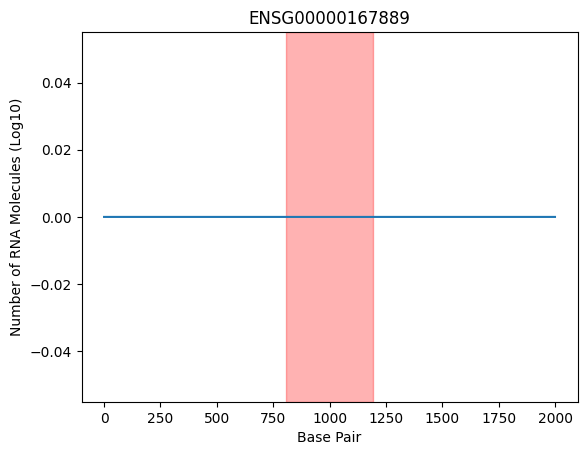

Pred: 1.9034593
Actual: 1.7623184


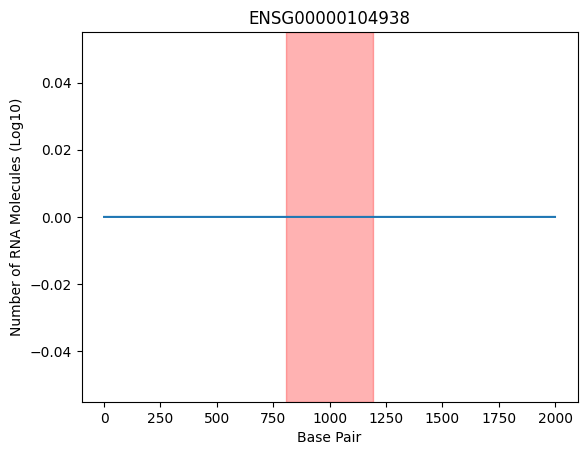

Pred: 0.108493805
Actual: 0.58232474


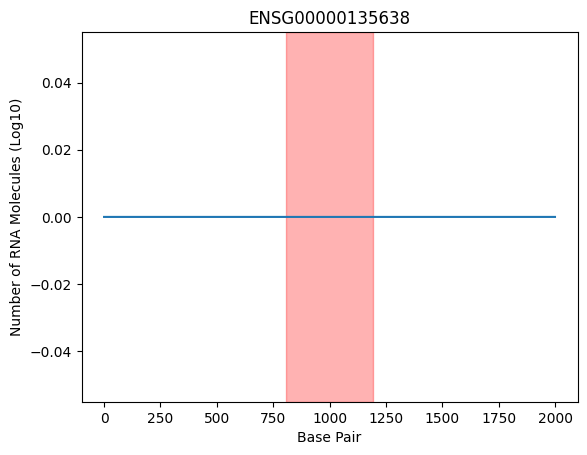

Pred: 1.5915451
Actual: 1.8934288


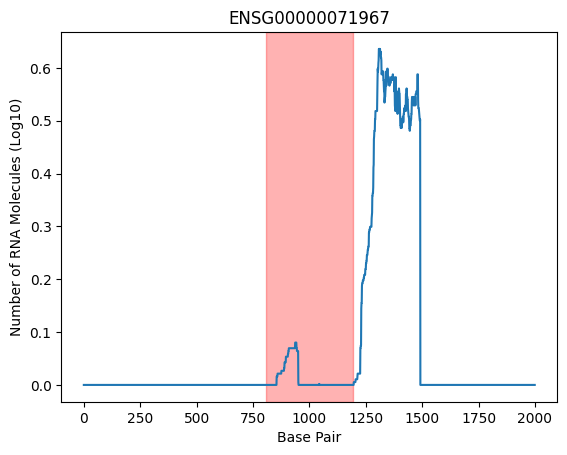

Pred: 2.7151768
Actual: 2.38166


In [410]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [418]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
25048    ENSG00000040199  1.994963  1.994977        11   
5234     ENSG00000071967  2.280791  2.280820         2   
10316    ENSG00000100448  0.388099  0.388067         5   
34032    ENSG00000178562 -0.000032  0.000000         2   
64525  ENSG00000077380_1  2.544437  2.544399         2   
63627    ENSG00000135638  1.893482  1.893429         2   
33023    ENSG00000241794 -0.000114  0.000000         1   
71779  ENSG00000243319_1  1.211982  1.211868         6   
4675     ENSG00000134318  2.148365  2.148482         2   
24394    ENSG00000103264  2.487153  2.487326        11   
8024     ENSG00000145321 -0.000206  0.000000         4   
59147    ENSG00000167889  1.762107  1.762318        12   
37202    ENSG00000159256  2.845706  2.845931         3   
32342    ENSG00000143184  0.000229  0.000000         1   
34165    ENSG00000293434  2.433612  2.433376         2   
8459   ENSG00000163738_2  2.304024  2.304260         4   
33917    ENSG00000115474  0.000246  0.000000         2   
22004    ENSG00000130734  2.157222  2.157481        10   
68254    ENSG00000251870  0.000298  0.000000         4   
7661   ENSG00000266256_1  0.721748  0.721448         4   
34097    ENSG00000138379  0.000321  0.000000         2   
18212  ENSG00000094914_1  2.933462  2.933811         9   
1903     ENSG00000204219  1.093719  1.094094         1   
26526    ENSG00000172123  1.354854  1.355233        12   
29226    ENSG00000172123  1.354854  1.355233        12   
54571    ENSG00000148584  0.000391  0.000000        11   
11494    ENSG00000102531  2.372441  2.372046         6   
35761  ENSG00000100225_2  0.000401  0.000000         2   
84268  ENSG00000065809_1  0.653609  0.653155        11   
20067    ENSG00000166532  1.700194  1.699725         9   
74664  ENSG00000158445_1  1.699484  1.698970         7   
21394    ENSG00000189042  1.803891  1.804416        10   
41100    ENSG00000259062  1.214617  1.215162         5   
65830  ENSG00000163681_3 -0.000568  0.000000         3   
42286    ENSG00000252508  0.000590  0.000000         6   
767    ENSG00000131781_2  2.628472  2.629101         1   
24525    ENSG00000103528  1.284397  1.285062        11   
8865   ENSG00000163453_1  1.535539  1.536255         4   
59503    ENSG00000142686  1.932997  1.933725         1   
37066    ENSG00000187527  0.000732  0.000000         3   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
25048                97.85000  0.000014     -0.000014  
5234                189.90600  0.000029     -0.000029  
10316                 1.44381  0.000032      0.000032  
34032                     NaN  0.000032     -0.000032  
64525               344.85400  0.000037      0.000037  
63627                72.21500  0.000053      0.000053  
33023                     NaN  0.000114     -0.000114  
71779                21.03300  0.000114      0.000114  
4675                139.76100  0.000117     -0.000117  
24394               306.13300  0.000174     -0.000174  
8024                      NaN  0.000206     -0.000206  
59147                52.31000  0.000211     -0.000211  
37202               401.49600  0.000225     -0.000225  
32342                     NaN  0.000229      0.000229  
34165               331.83400  0.000236      0.000236  
8459                200.49300  0.000236     -0.000236  
33917                     NaN  0.000246      0.000246  
22004               142.70800  0.000259     -0.000259  
68254                     NaN  0.000298      0.000298  
7661                  4.26560  0.000300      0.000300  
34097                     NaN  0.000321      0.000321  
18212               857.64000  0.000349     -0.000349  
1903                 11.41920  0.000375     -0.000375  
26526                21.65860  0.000379     -0.000379  
29226                21.65860  0.000379     -0.000379  
54571                     NaN  0.000391      0.000391  
11494               234.53000  0.000395      0.000395  
35761                     NaN  0.000401      0.000401  
84268      

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
8020      ENSG00000071967  2.280791  2.280820         2   
10613     ENSG00000071967  2.280791  2.280820         2   
19221     ENSG00000100448  0.388099  0.388067         5   
21544     ENSG00000100448  0.388099  0.388067         5   
62475     ENSG00000178562 -0.000032  0.000000         2   
65068     ENSG00000178562 -0.000032  0.000000         2   
120427    ENSG00000135638  1.893482  1.893429         2   
123020    ENSG00000135638  1.893482  1.893429         2   
165226    ENSG00000205899  1.368203  1.368268        12   
167926    ENSG00000205899  1.368203  1.368268        12   
74706     ENSG00000258874 -0.000074  0.000000         5   
77029     ENSG00000258874 -0.000074  0.000000         5   
58680     ENSG00000241794 -0.000114  0.000000         1   
61466     ENSG00000241794 -0.000114  0.000000         1   
137021  ENSG00000243319_1  1.211982  1.211868         6   
139010  ENSG00000243319_1  1.211982  1.211868         6   
98018     ENSG00000104938 -0.000115  0.000000        10   
101010    ENSG00000104938 -0.000115  0.000000        10   
125236  ENSG00000145012_3  0.000133  0.000000         3   
127173  ENSG00000145012_3  0.000133  0.000000         3   
59166   ENSG00000142875_4 -0.000172  0.000000         1   
61952   ENSG00000142875_4 -0.000172  0.000000         1   
47792     ENSG00000103264  2.487153  2.487326        11   
50051     ENSG00000103264  2.487153  2.487326        11   
15340     ENSG00000145321 -0.000206  0.000000         4   
16929     ENSG00000145321 -0.000206  0.000000         4   
110461    ENSG00000167889  1.762107  1.762318        12   
113161    ENSG00000167889  1.762107  1.762318        12   
68238     ENSG00000159256  2.845706  2.845931         3   
70175     ENSG00000159256  2.845706  2.845931         3   
62608     ENSG00000293434  2.433612  2.433376         2   
65201     ENSG00000293434  2.433612  2.433376         2   
62360     ENSG00000115474  0.000246  0.000000         2   
64953     ENSG00000115474  0.000246  0.000000         2   
42410     ENSG00000130734  2.157222  2.157481        10   
45402     ENSG00000130734  2.157222  2.157481        10   
129584    ENSG00000251870  0.000298  0.000000         4   
131173    ENSG00000251870  0.000298  0.000000         4   
48878     ENSG00000102974  2.835364  2.835043        11   
51137     ENSG00000102974  2.835364  2.835043        11   

        GM12878_CAGE_128*3_sum     Error  Signed Error  
8020                 189.90600  0.000029     -0.000029  
10613                189.90600  0.000029     -0.000029  
19221                  1.44381  0.000032      0.000032  
21544                  1.44381  0.000032      0.000032  
62475                      NaN  0.000032     -0.000032  
65068                      NaN  0.000032     -0.000032  
120427                72.21500  0.000053      0.000053  
123020                72.21500  0.000053      0.000053  
165226                42.03700  0.000065     -0.000065  
167926                42.03700  0.000065     -0.000065  
74706                      NaN  0.000074     -0.000074  
77029                      NaN  0.000074     -0.000074  
58680                      NaN  0.000114     -0.000114  
61466                      NaN  0.000114     -0.000114  
137021                21.03300  0.000114      0.000114  
139010                21.03300  0.000114      0.000114  
98018                  2.82230  0.000115     -0.000115  
101010                 2.82230  0.000115     -0.000115  
125236                     NaN  0.000133      0.000133  
127173                     NaN  0.000133      0.000133  
59166                      NaN  0.000172     -0.000172  
61952                      NaN  0.000172     -0.000172  
47792                306.13300  0.000174     -0.000174  
50051                306.13300  0.000174     -0.000174  
15340                      NaN  0.000206     -0.000206  
16929                      NaN  0.000206     -0.000206  
110461                52.31000  0.000211     -0.000211  

GM12878: 


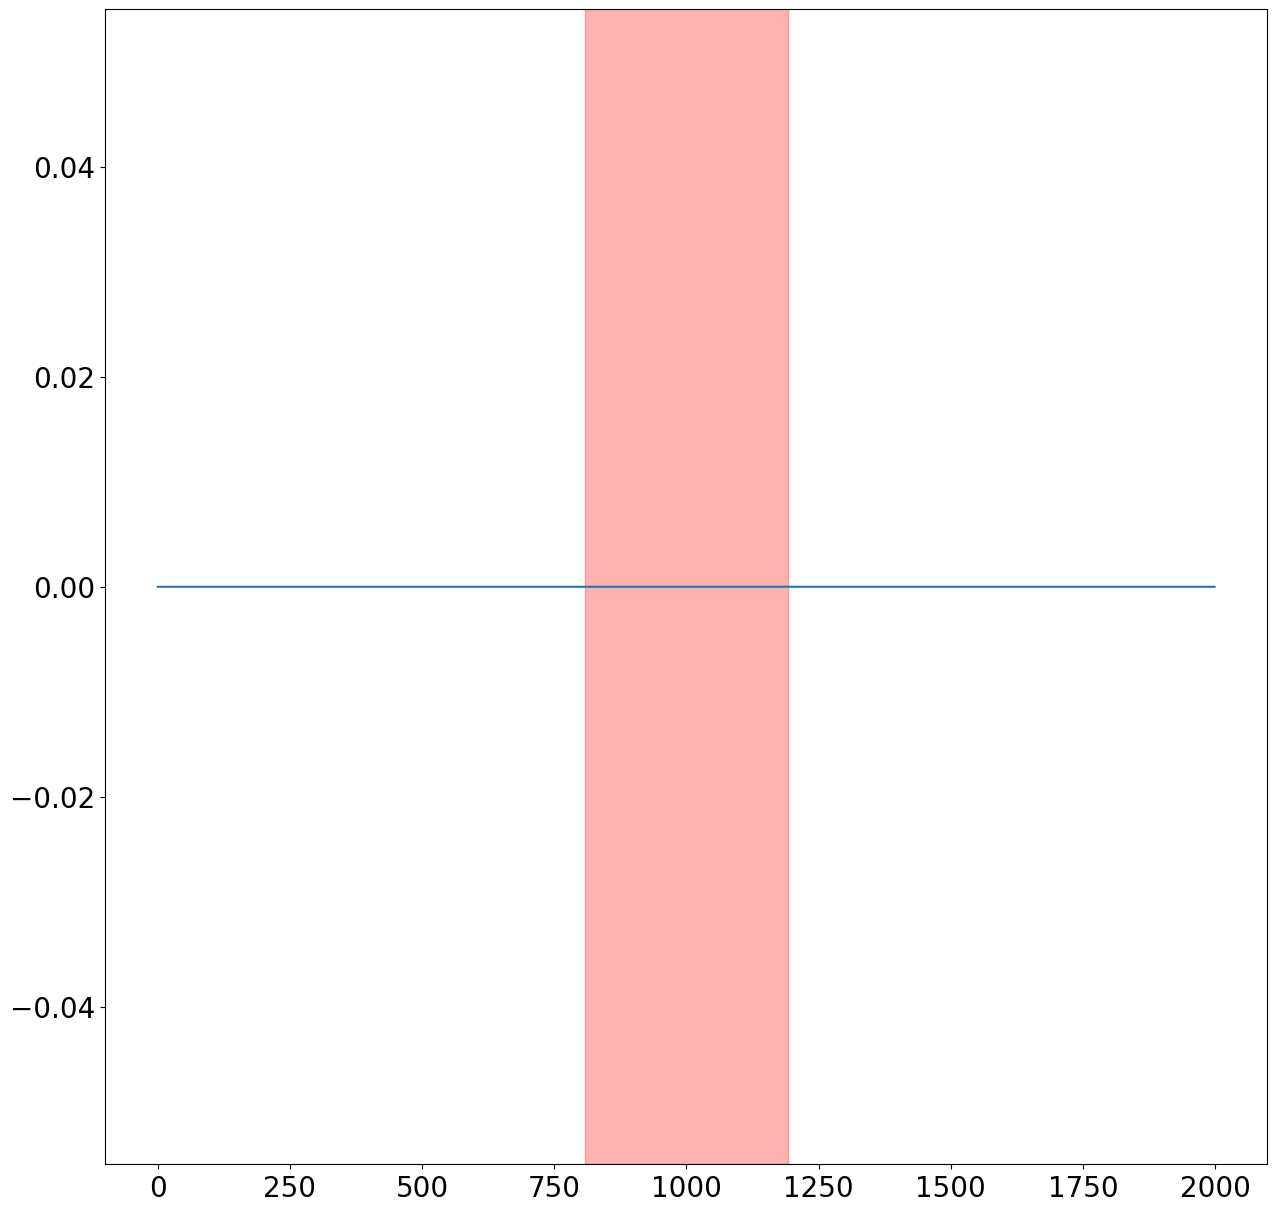

ENSG00000204219
Pred: 1.0937185
Actual: 1.0940937


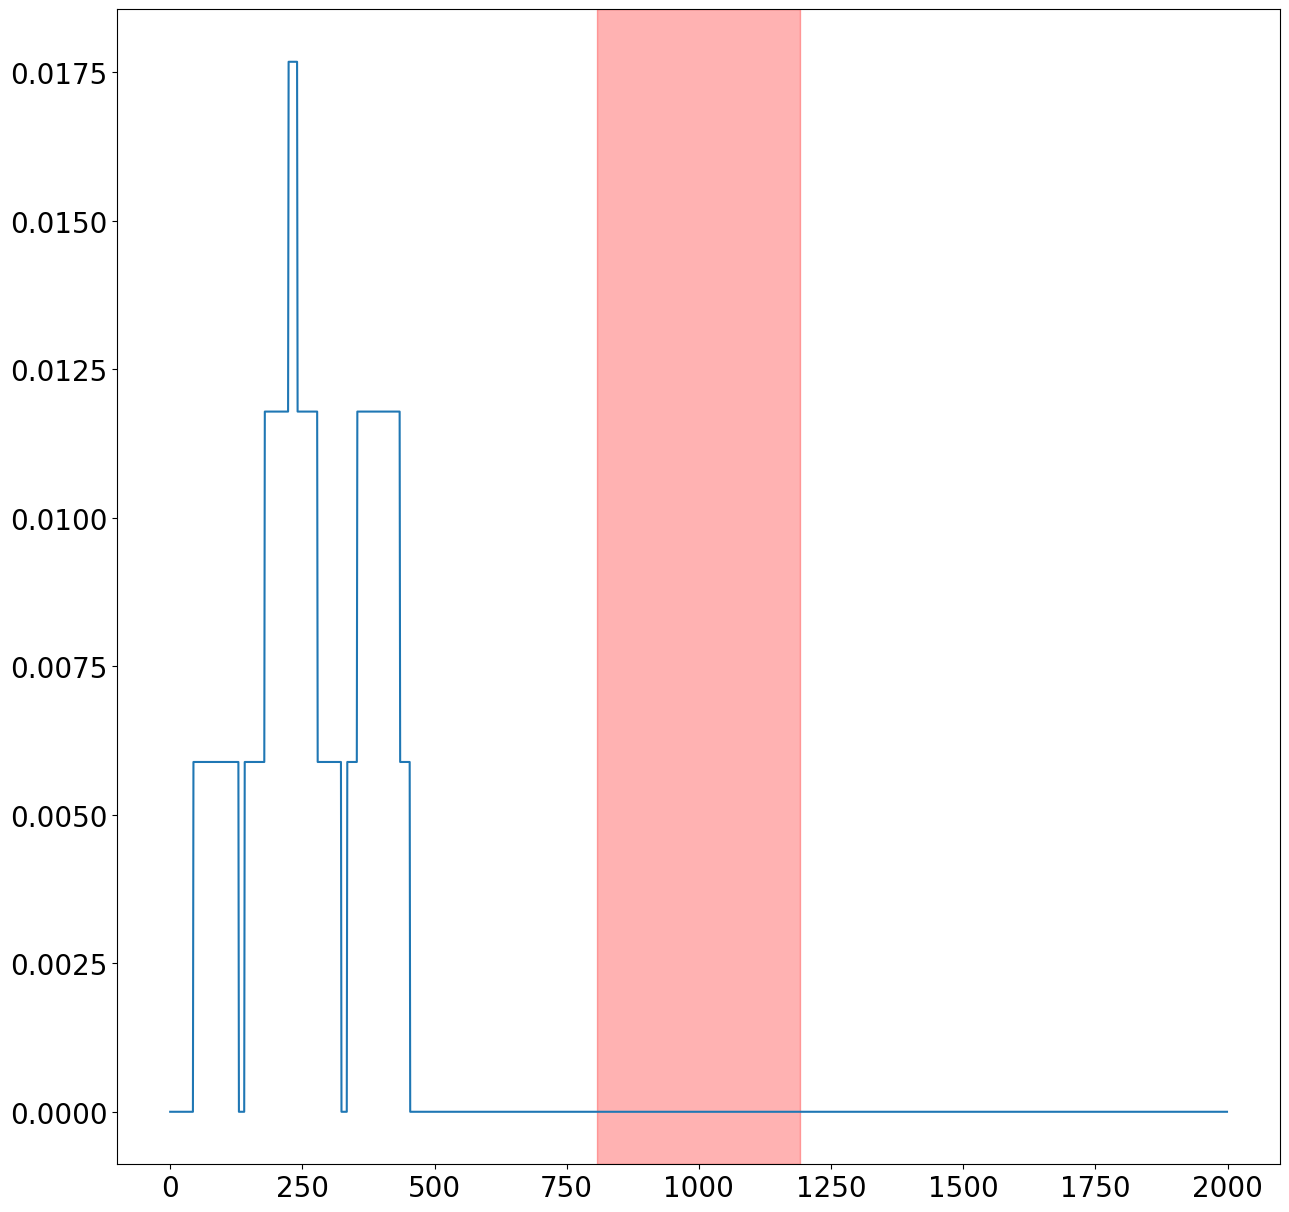

ENSG00000142686
Pred: 1.932997
Actual: 1.9337251


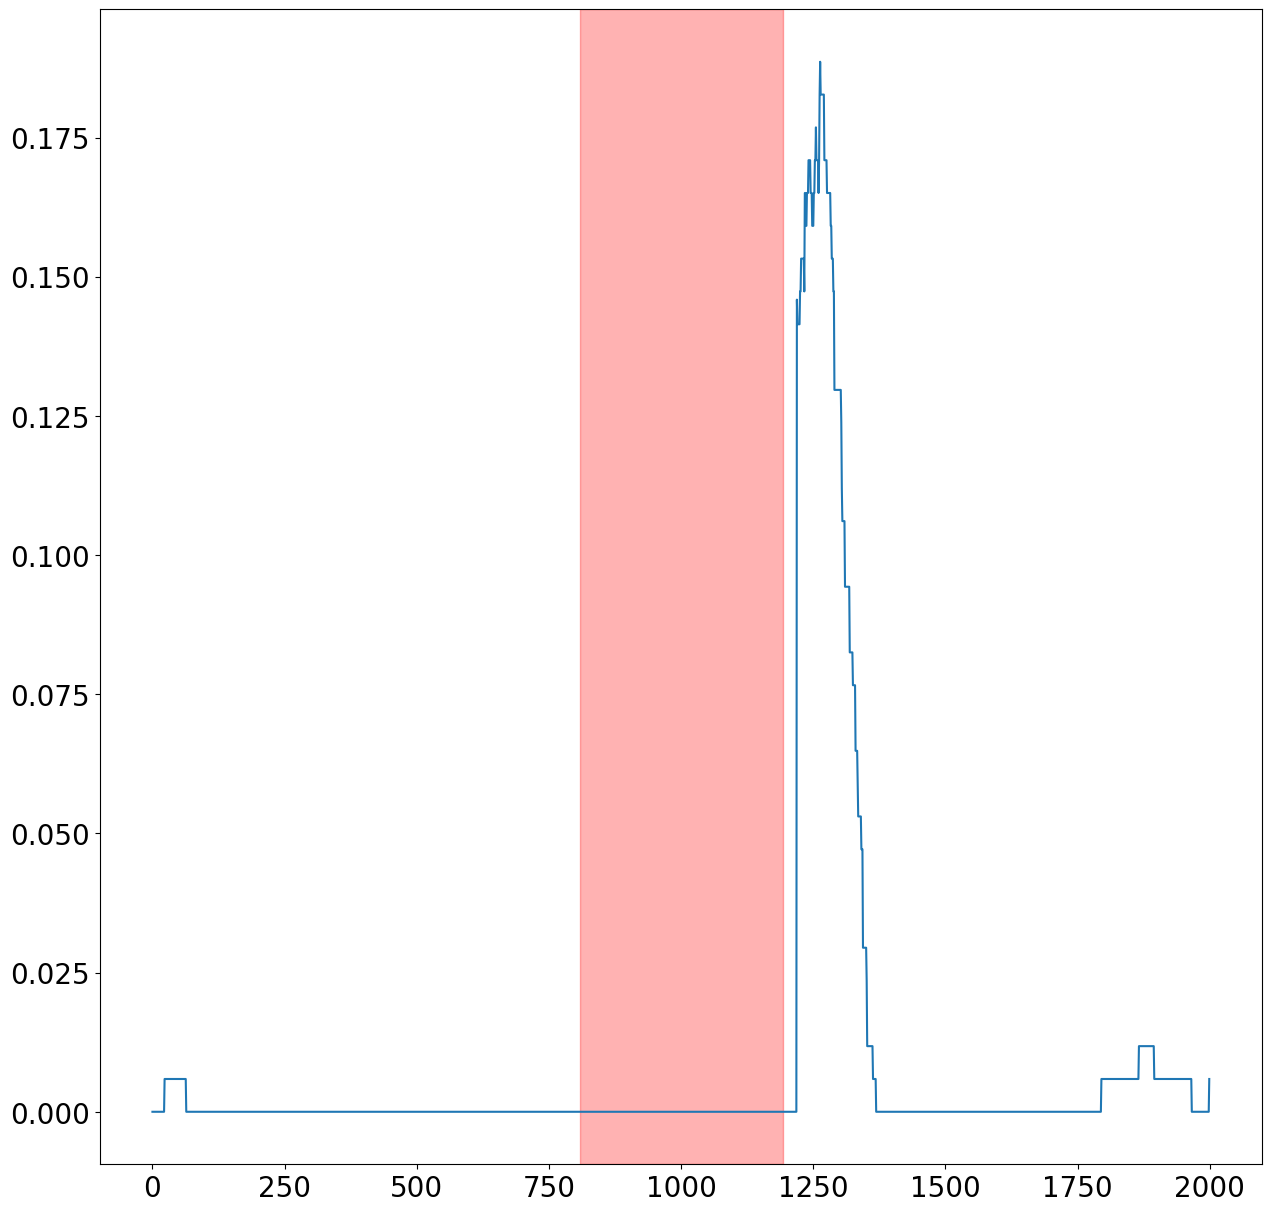

ENSG00000131781_2
Pred: 2.6284719
Actual: 2.6291015


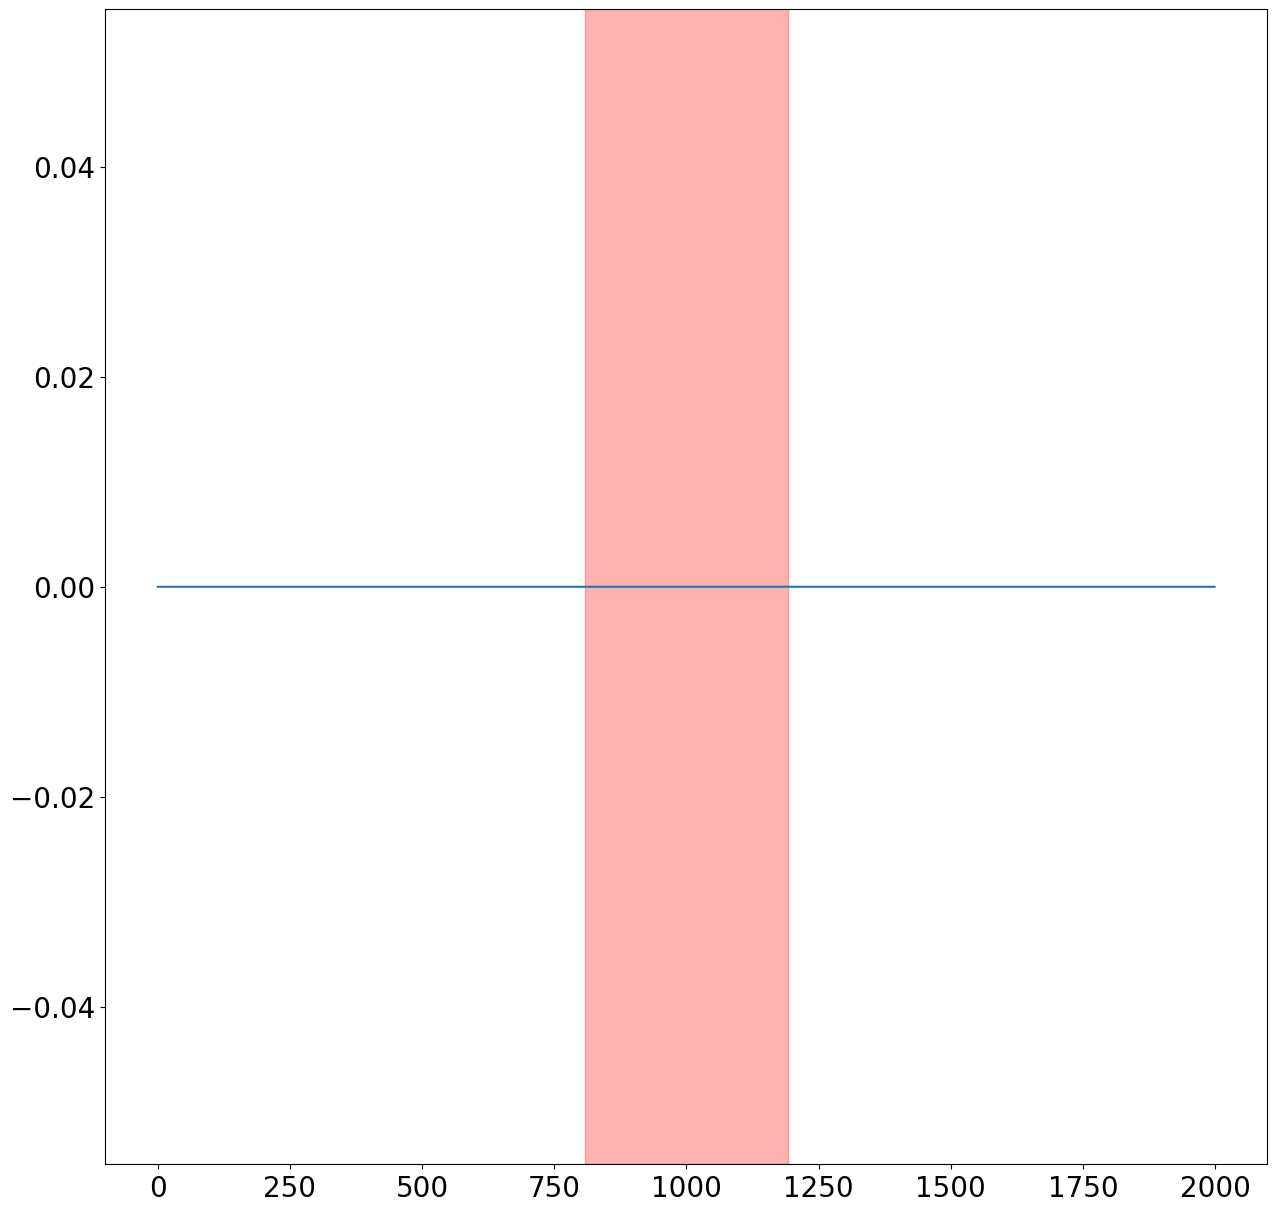

ENSG00000241794
Pred: -0.0001135068
Actual: 0.0


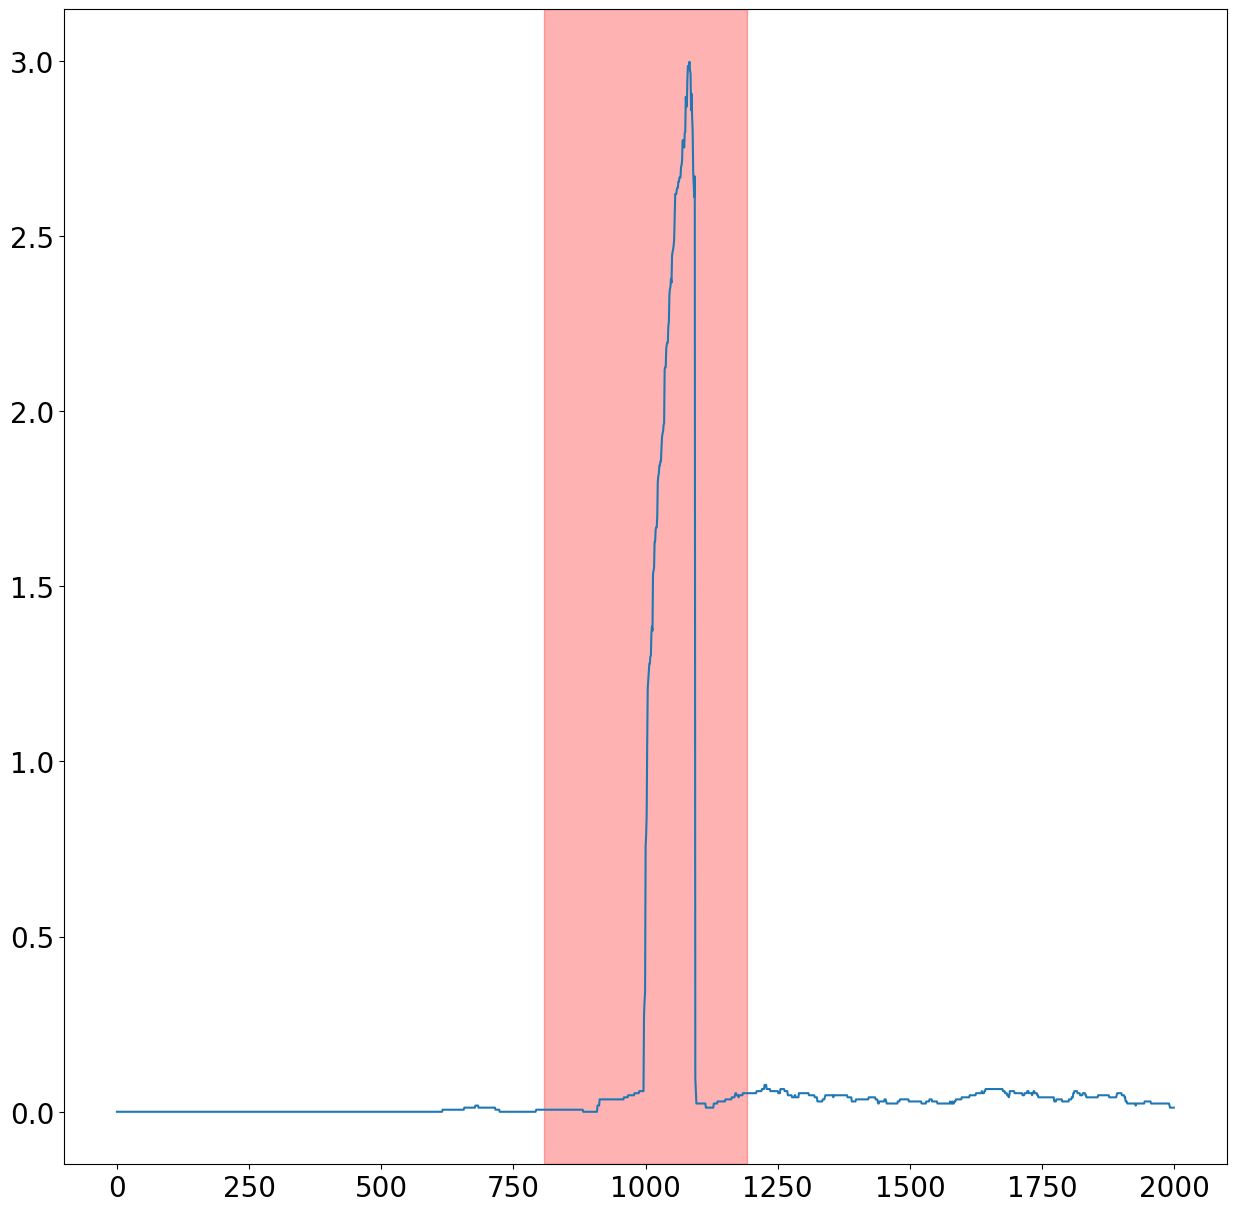

ENSG00000143184
Pred: 0.00022941362
Actual: 0.0


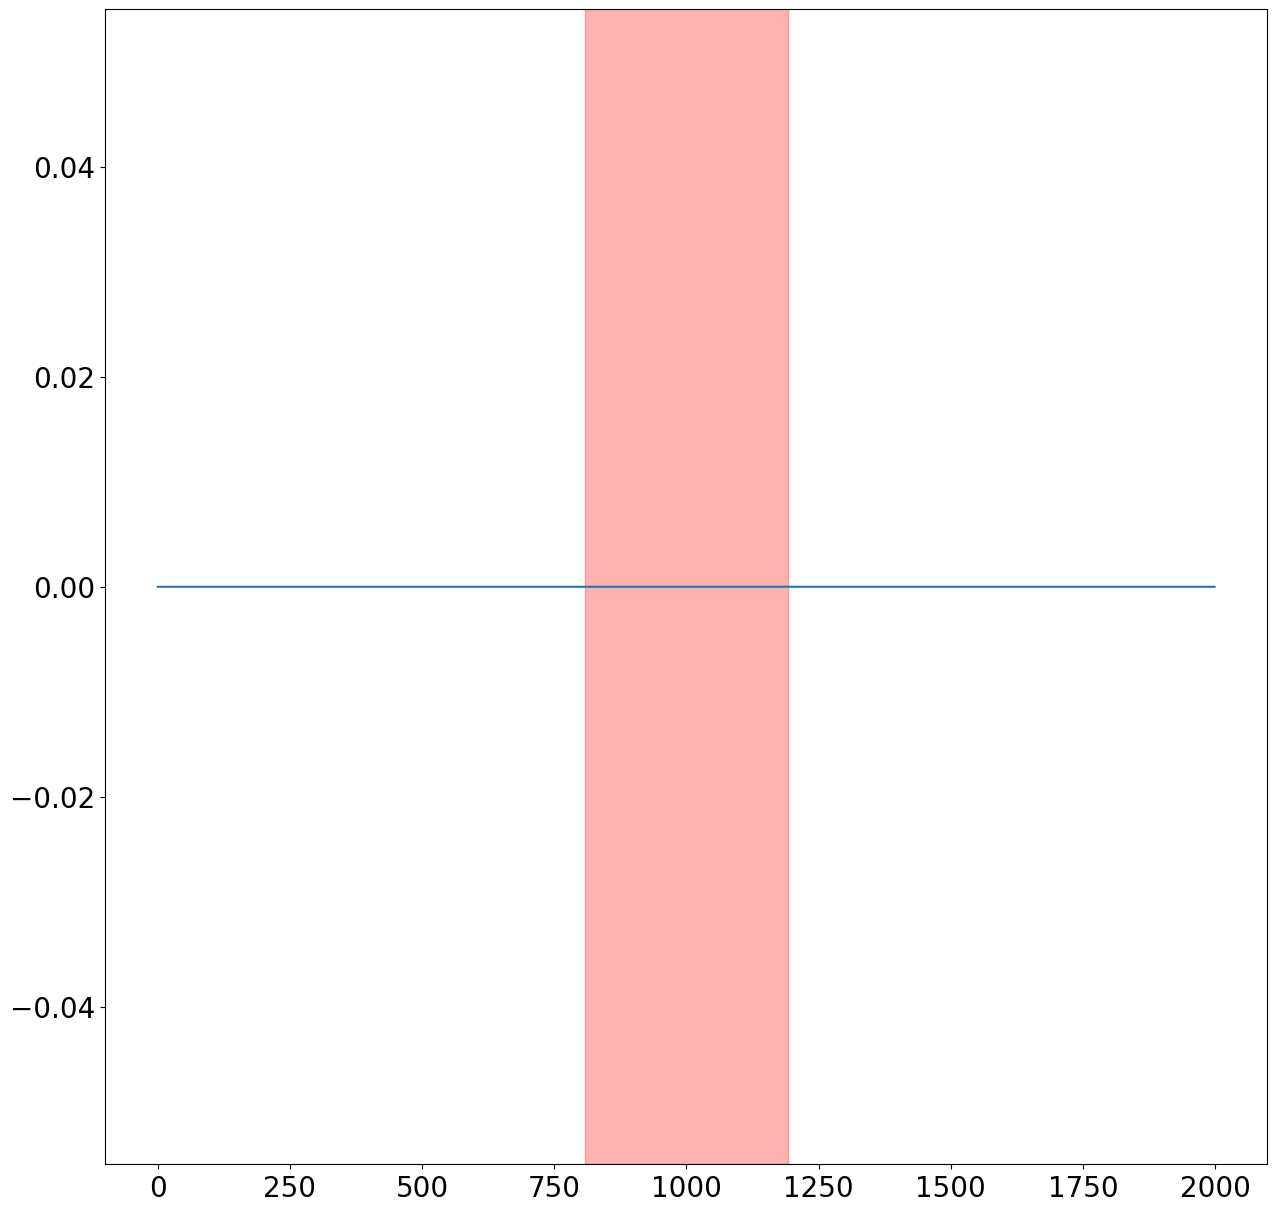

ENSG00000065809_1
Pred: 0.65360945
Actual: 0.6531546


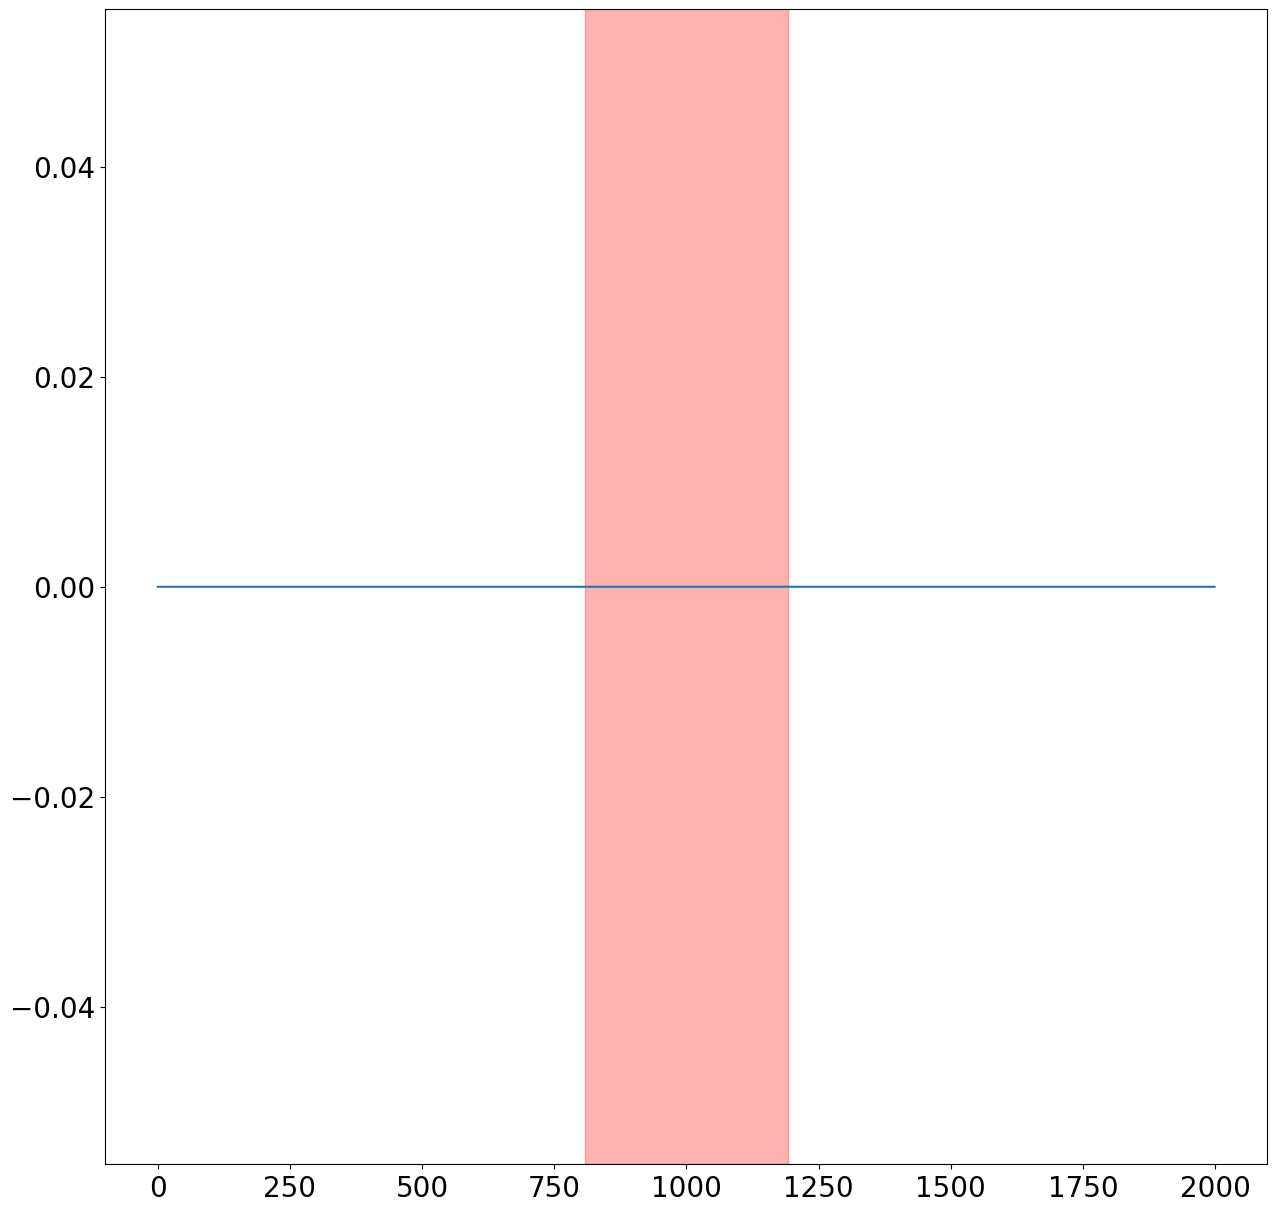

ENSG00000148584
Pred: 0.0003907457
Actual: 0.0


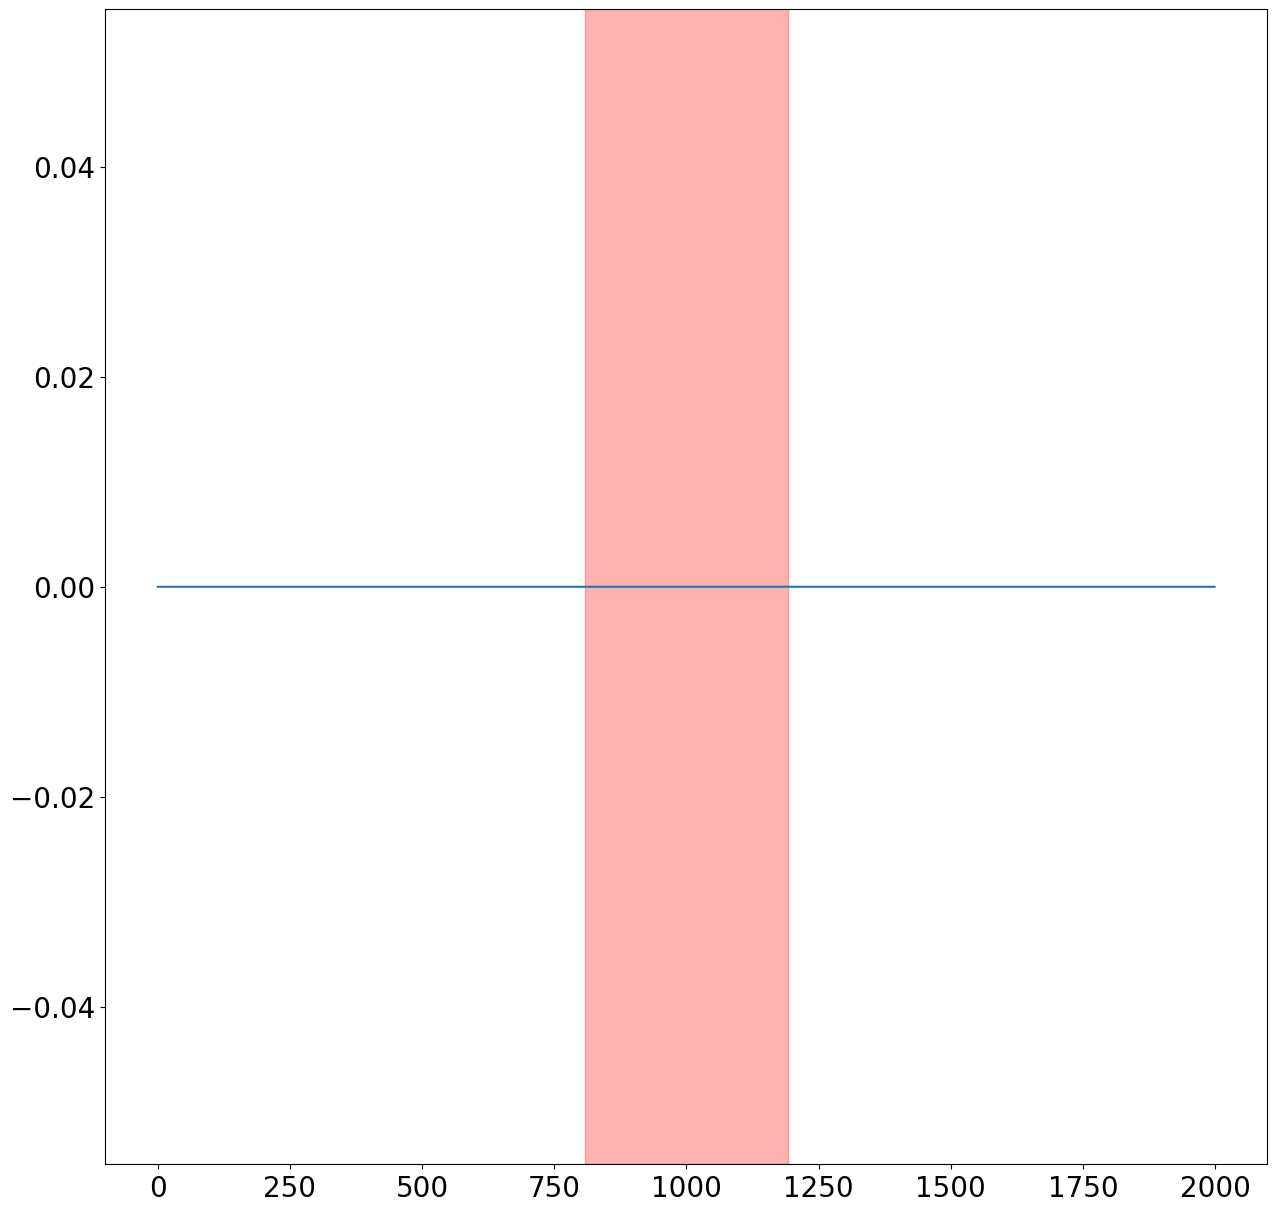

ENSG00000166532
Pred: 1.7001942
Actual: 1.699725


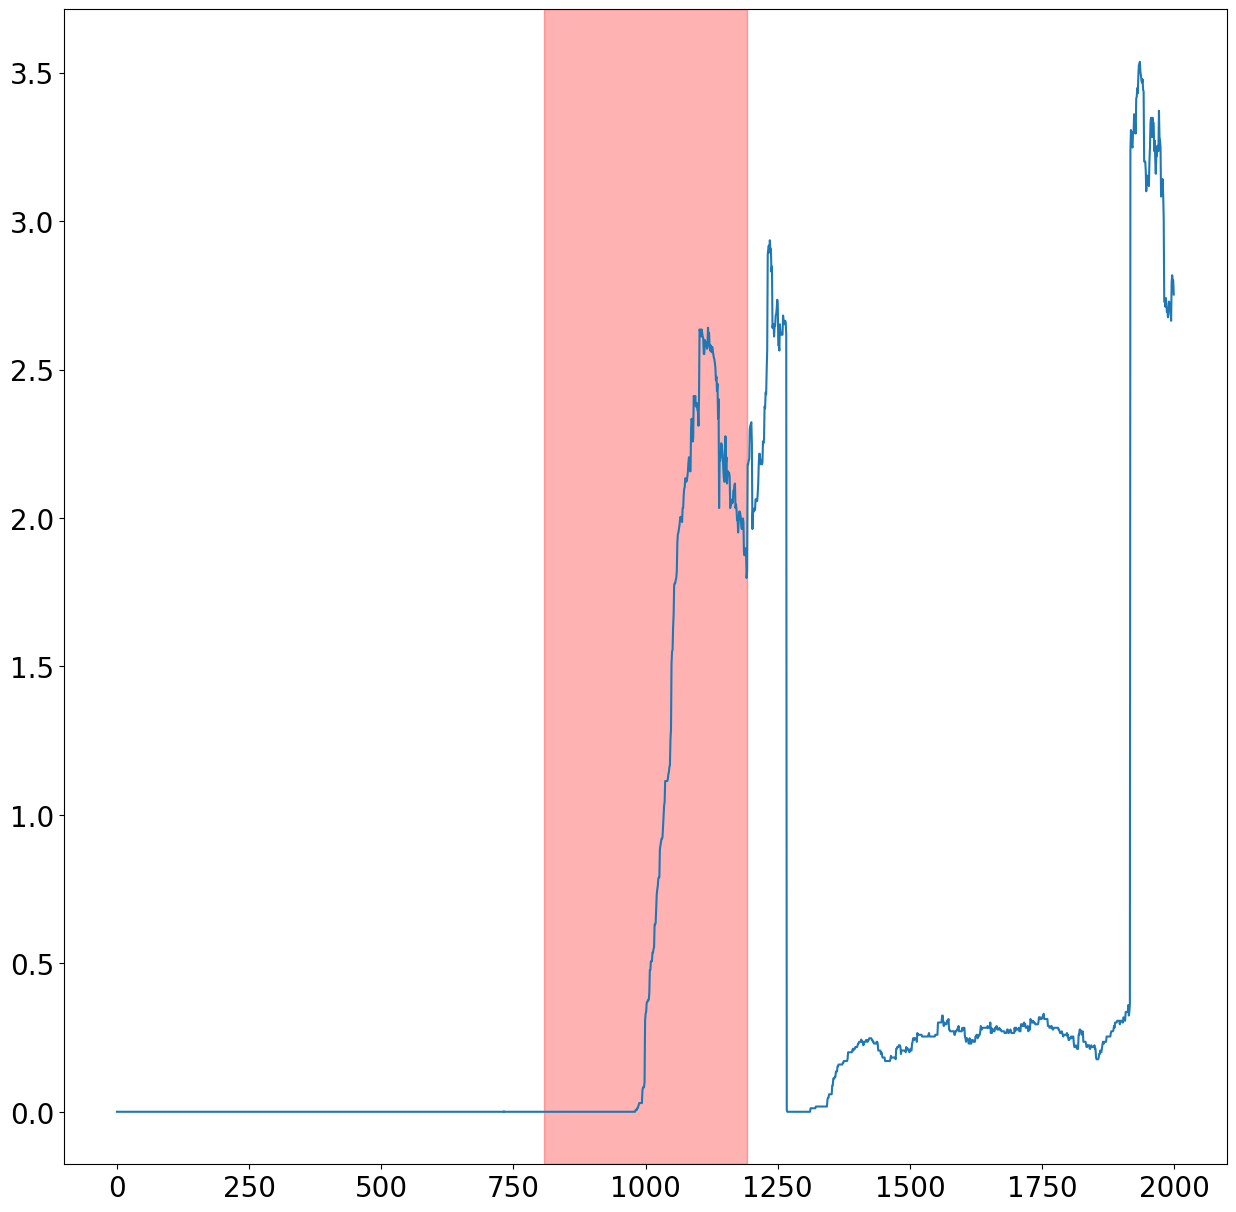

ENSG00000094914_1
Pred: 2.933462
Actual: 2.9338112


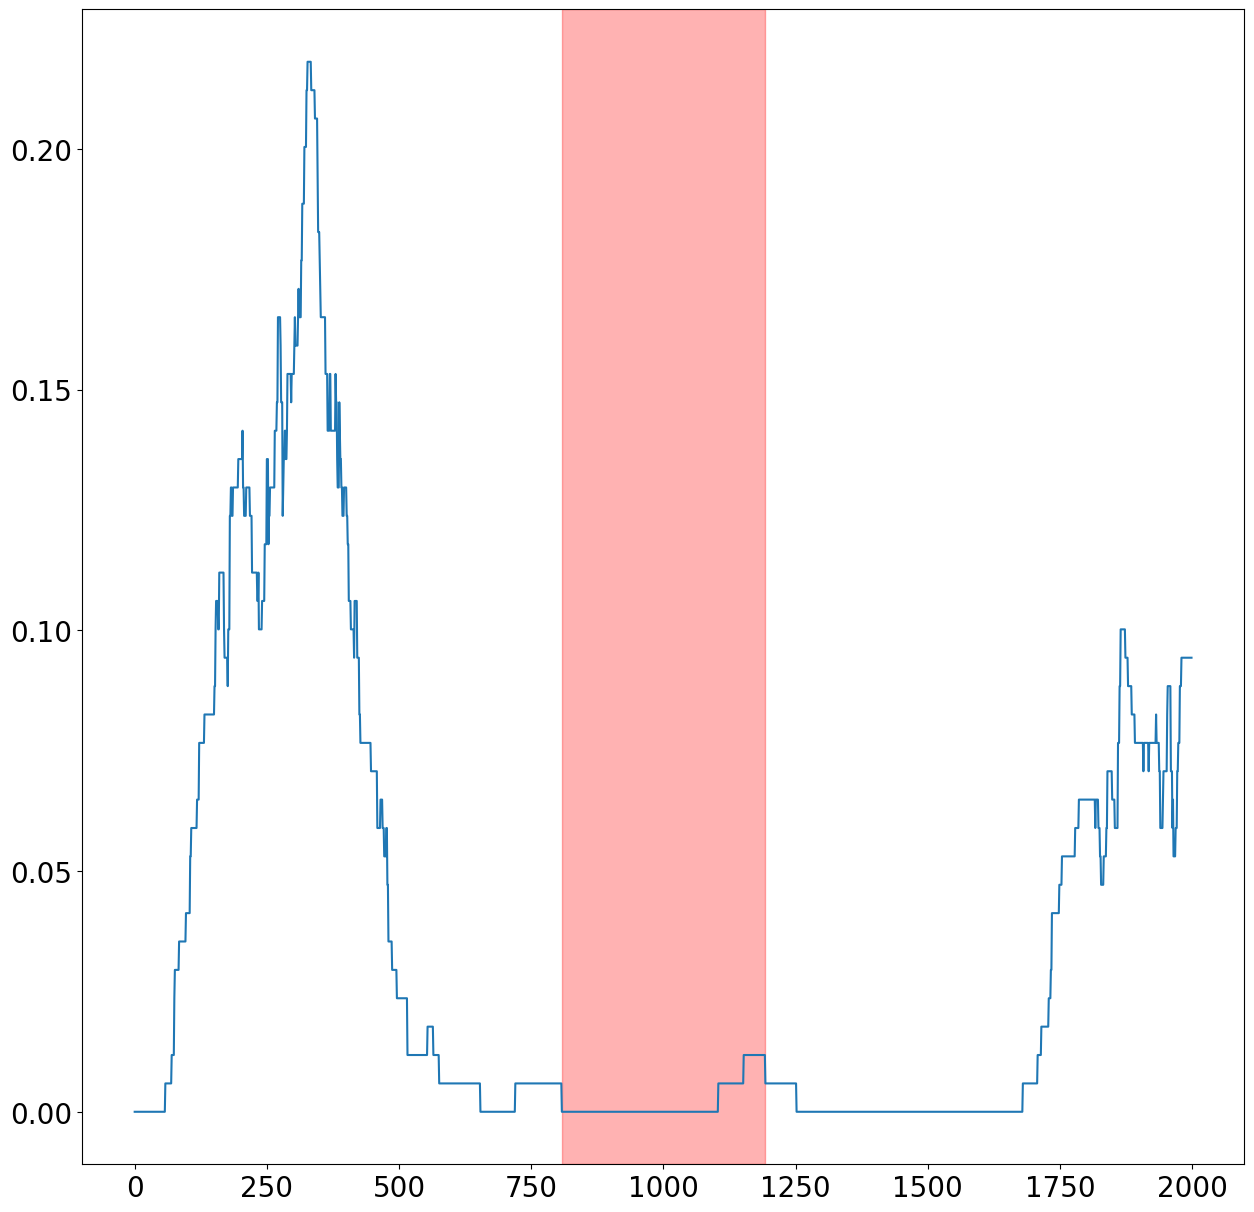

ENSG00000102531
Pred: 2.372441
Actual: 2.3720462


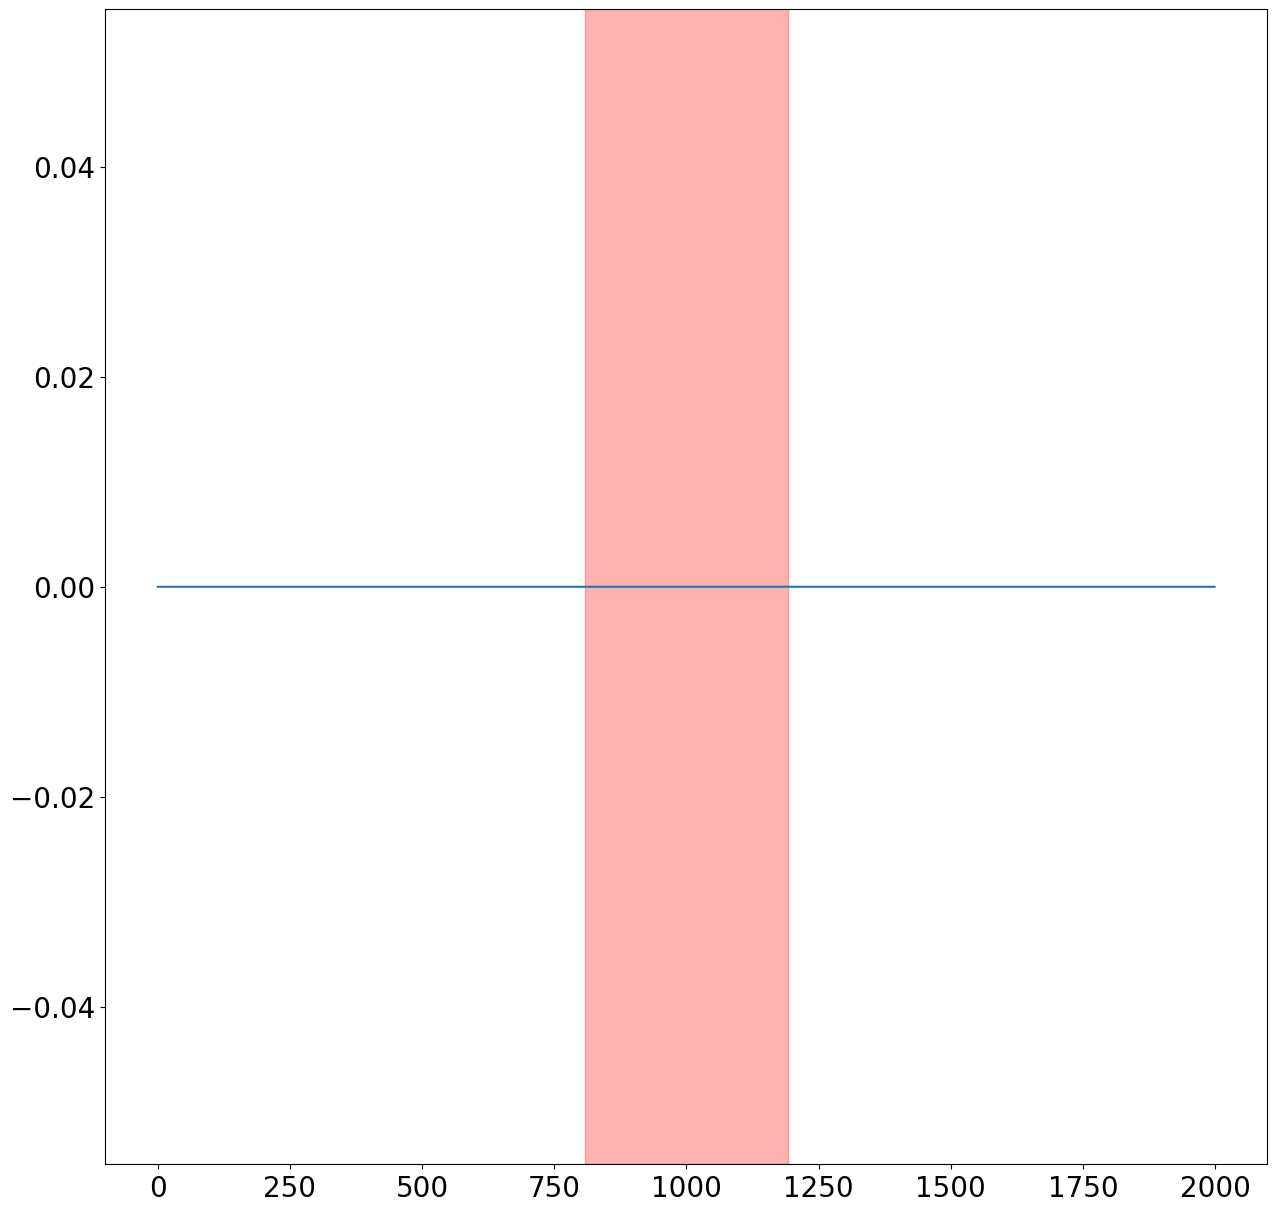

ENSG00000252508
Pred: 0.0005900501
Actual: 0.0


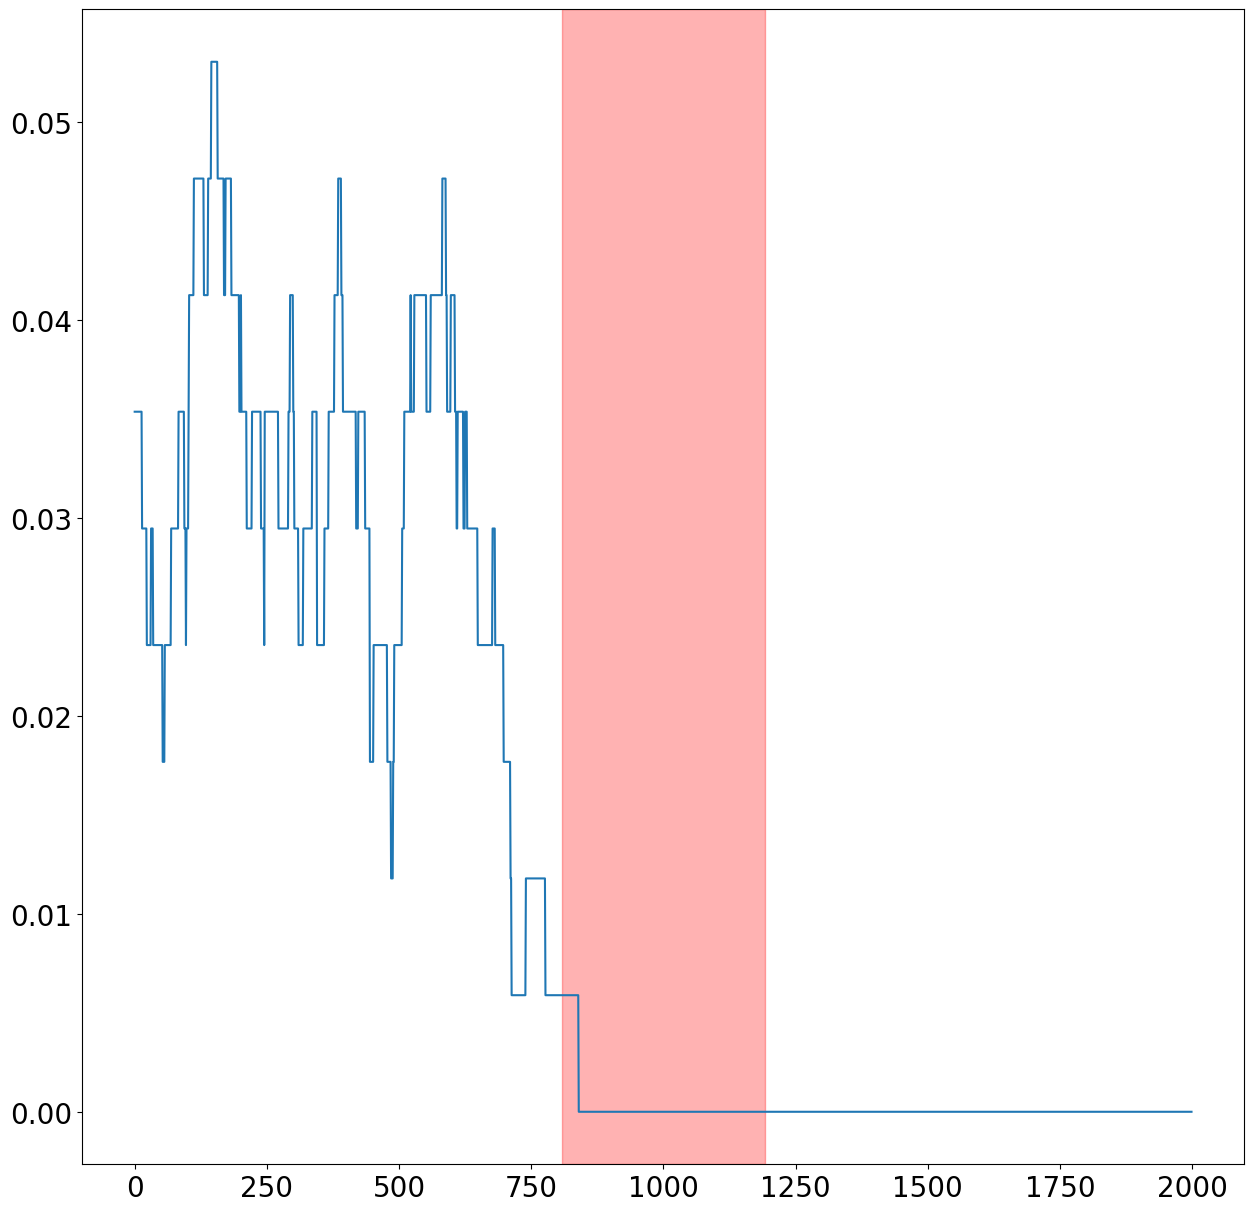

ENSG00000243319_1
Pred: 1.2119815
Actual: 1.2118678


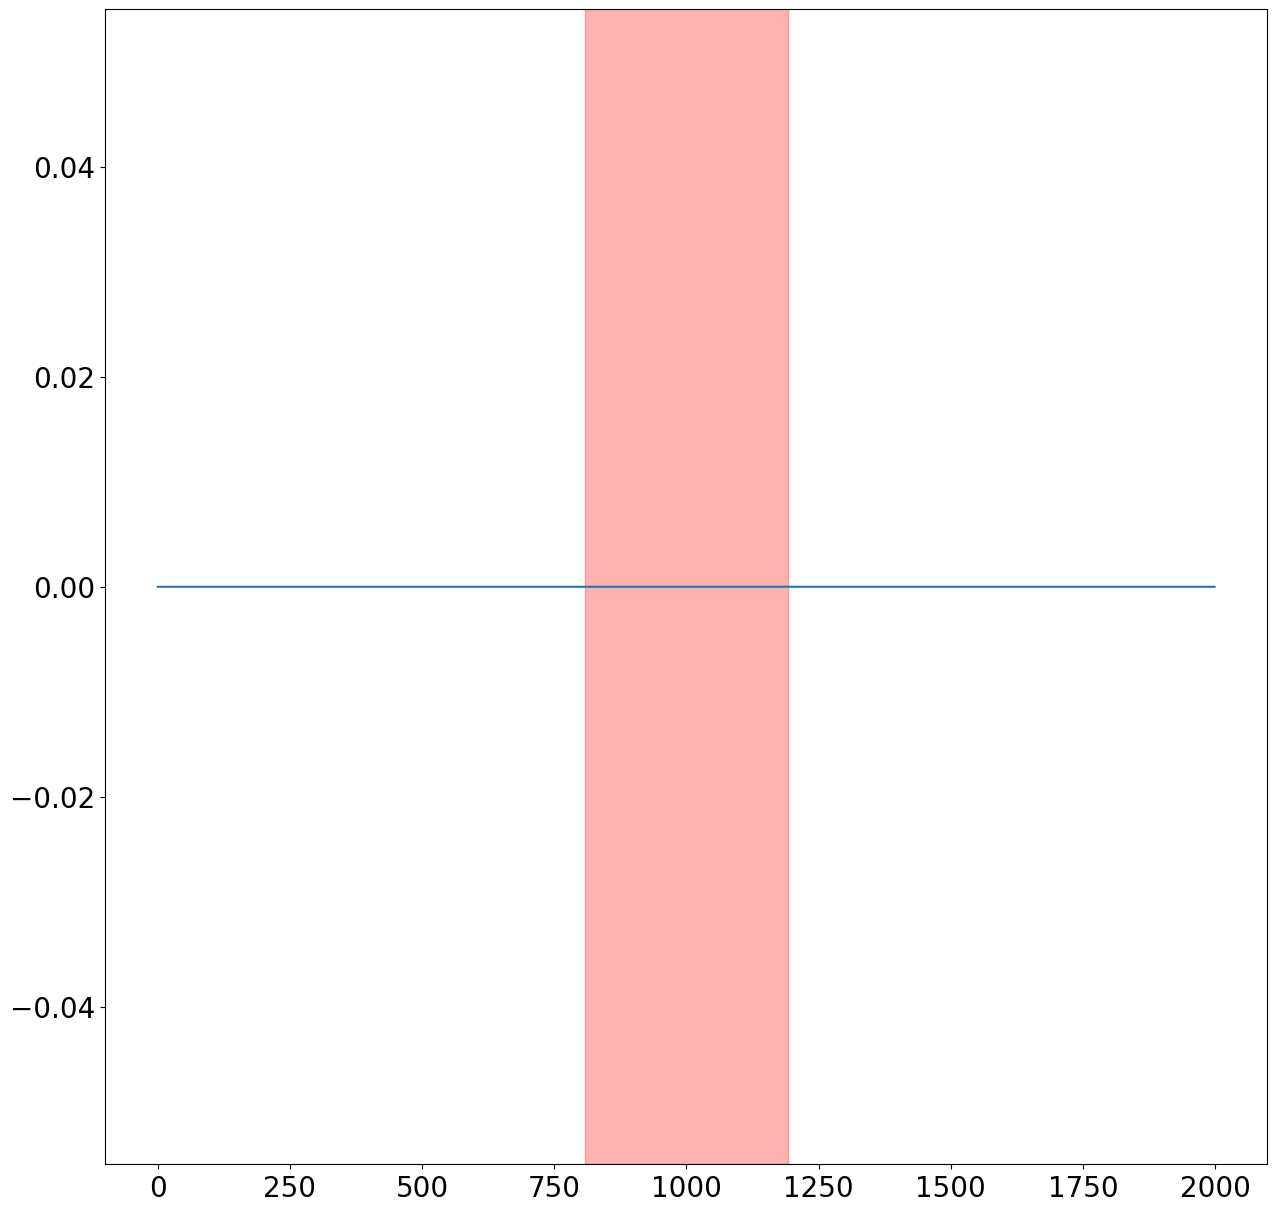

ENSG00000100448
Pred: 0.3880993
Actual: 0.38806742


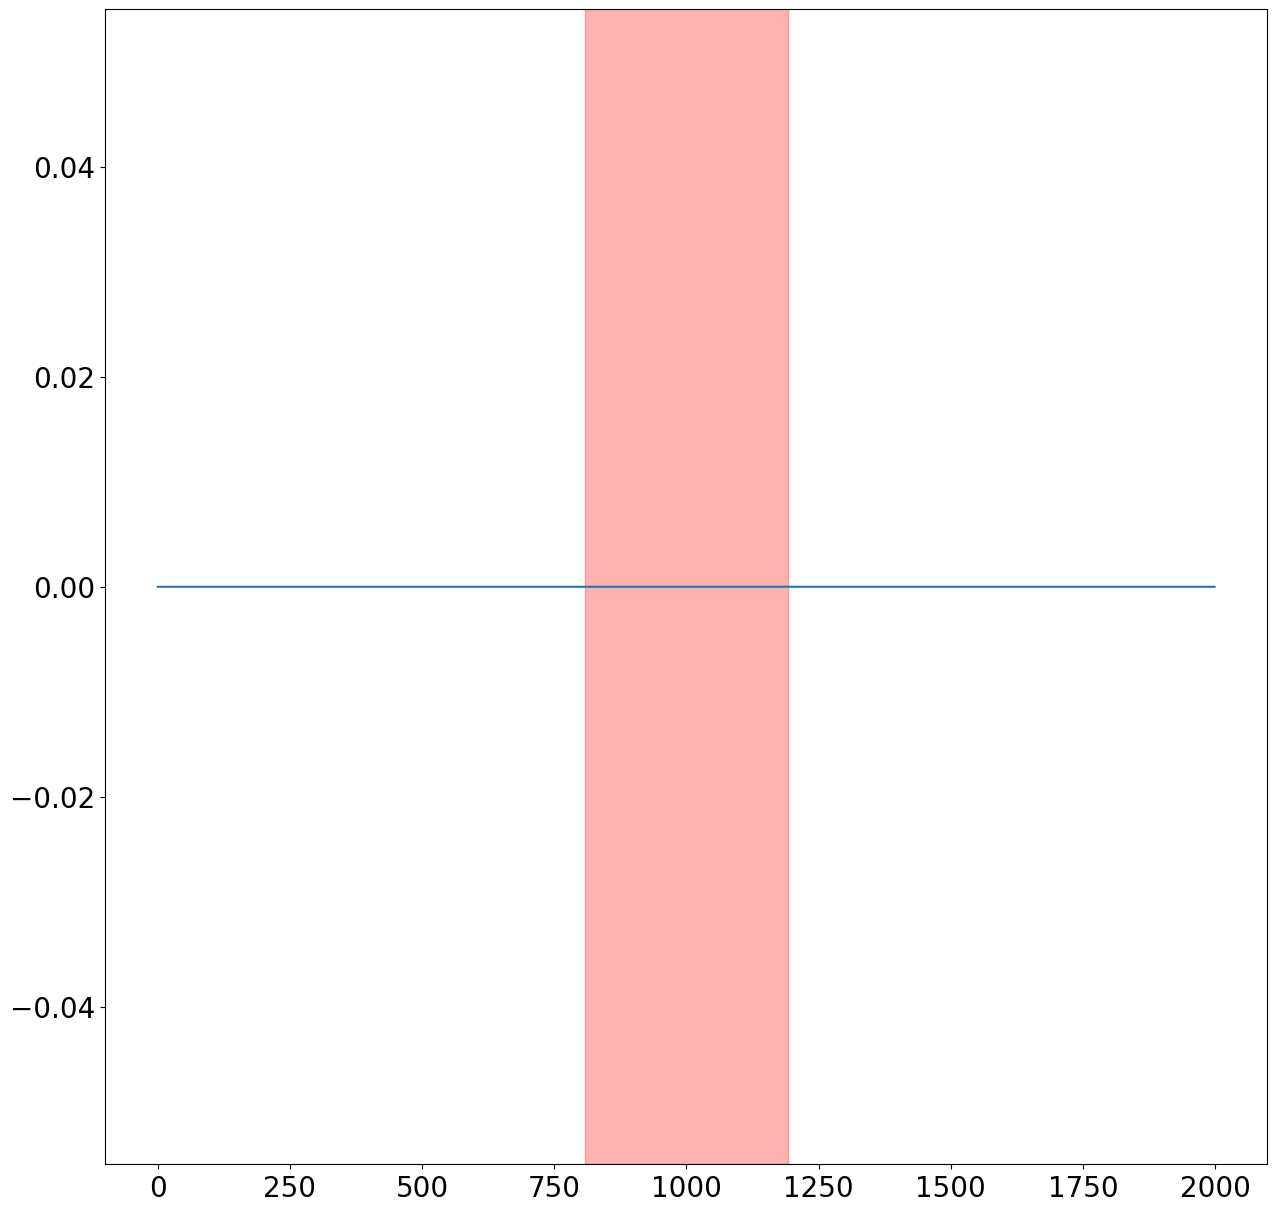

ENSG00000259062
Pred: 1.2146169
Actual: 1.2151616


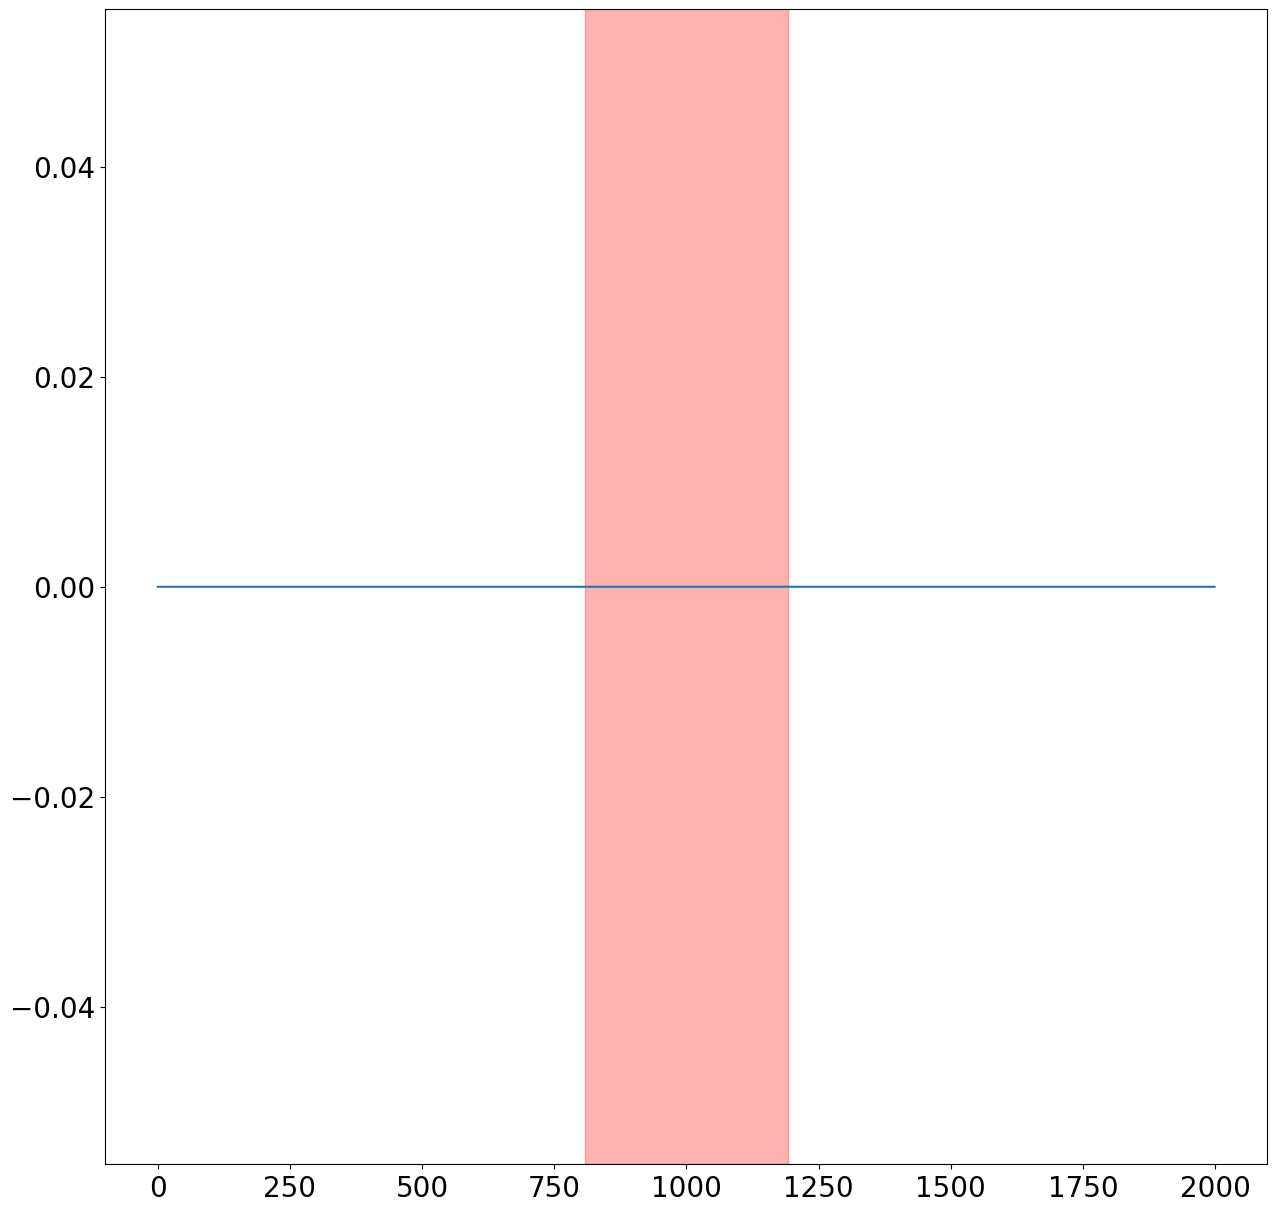

ENSG00000103528
Pred: 1.2843972
Actual: 1.285062


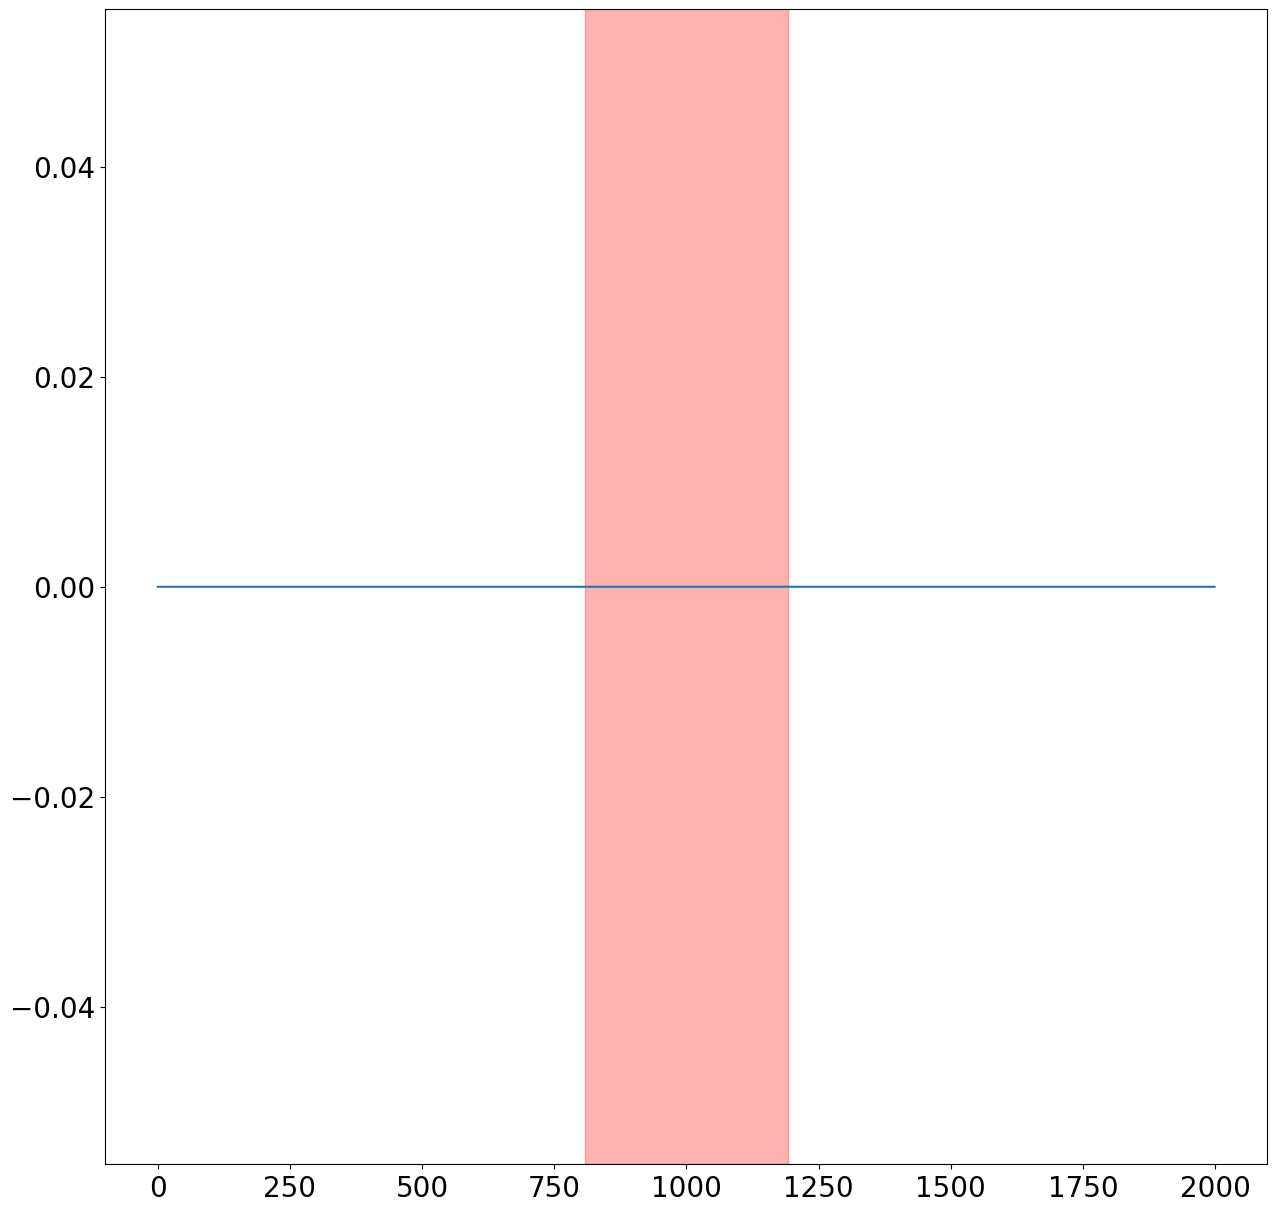

ENSG00000040199
Pred: 1.9949626
Actual: 1.9949766


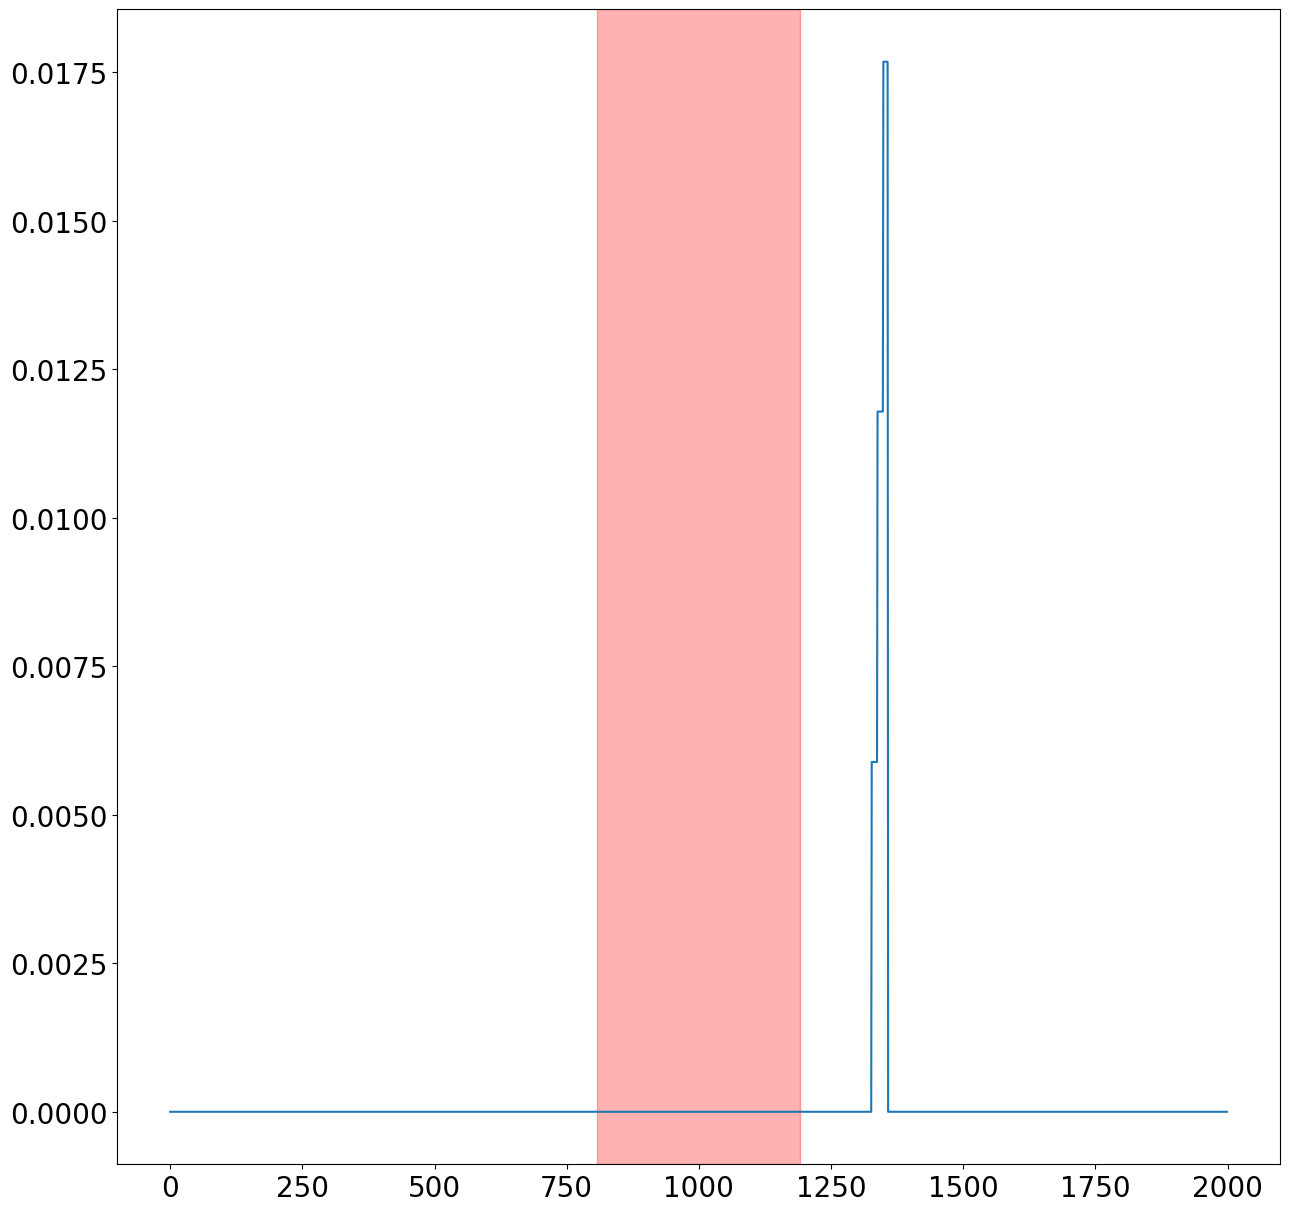

ENSG00000103264
Pred: 2.4871528
Actual: 2.4873264


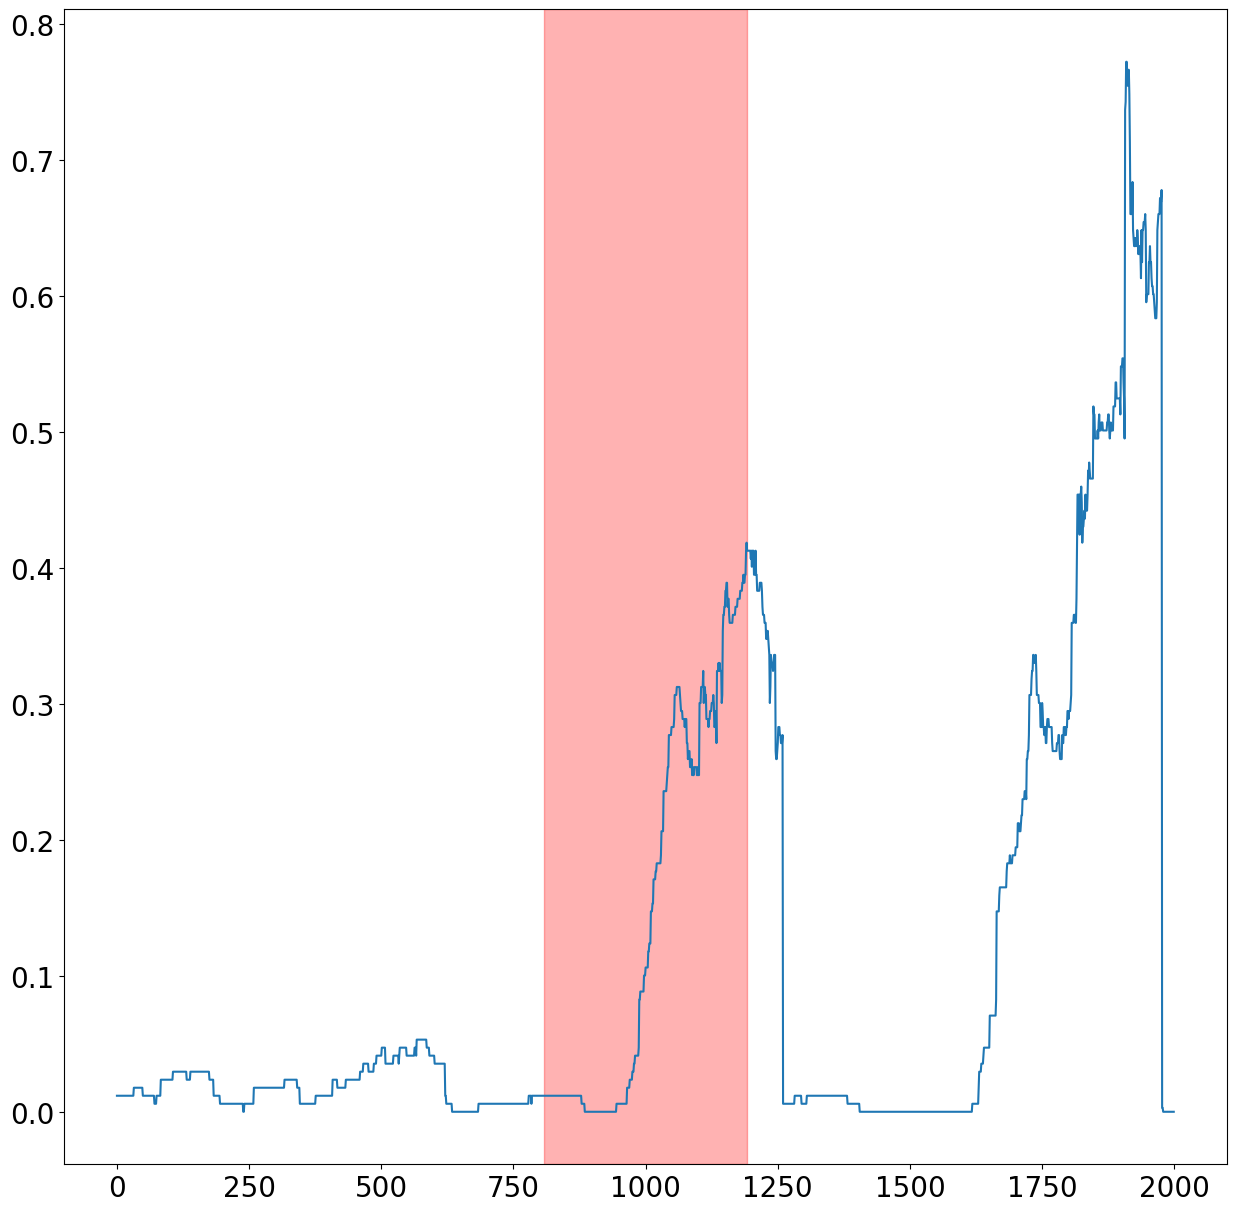

ENSG00000172123
Pred: 1.3548536
Actual: 1.3552331


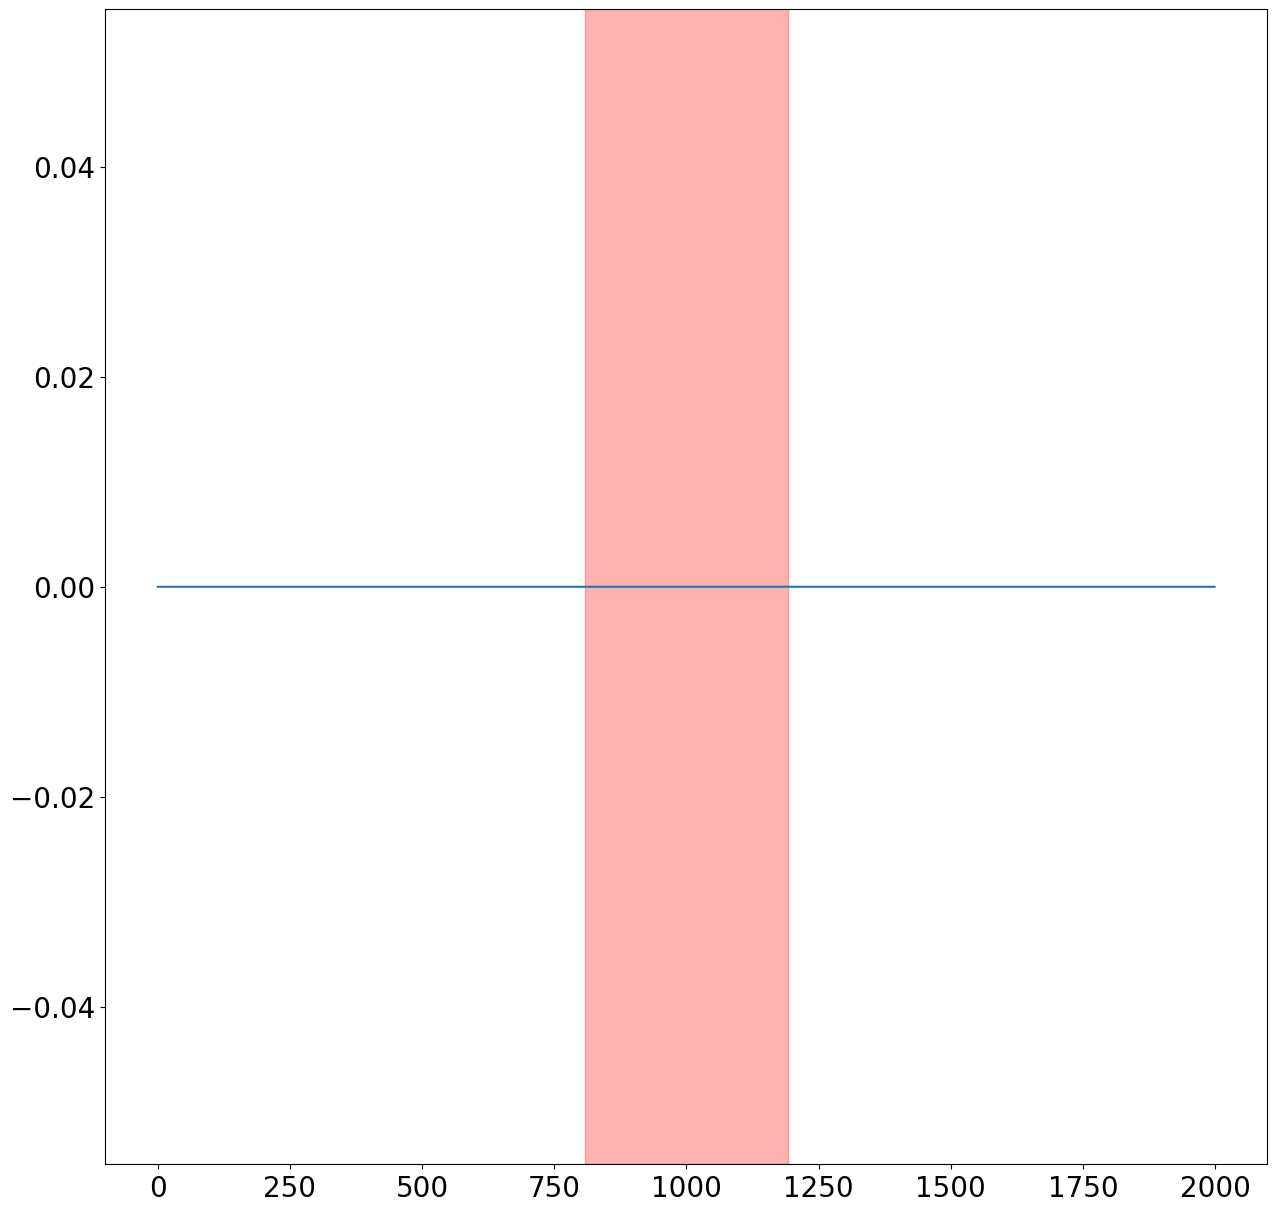

ENSG00000167889
Pred: 1.7621073
Actual: 1.7623184


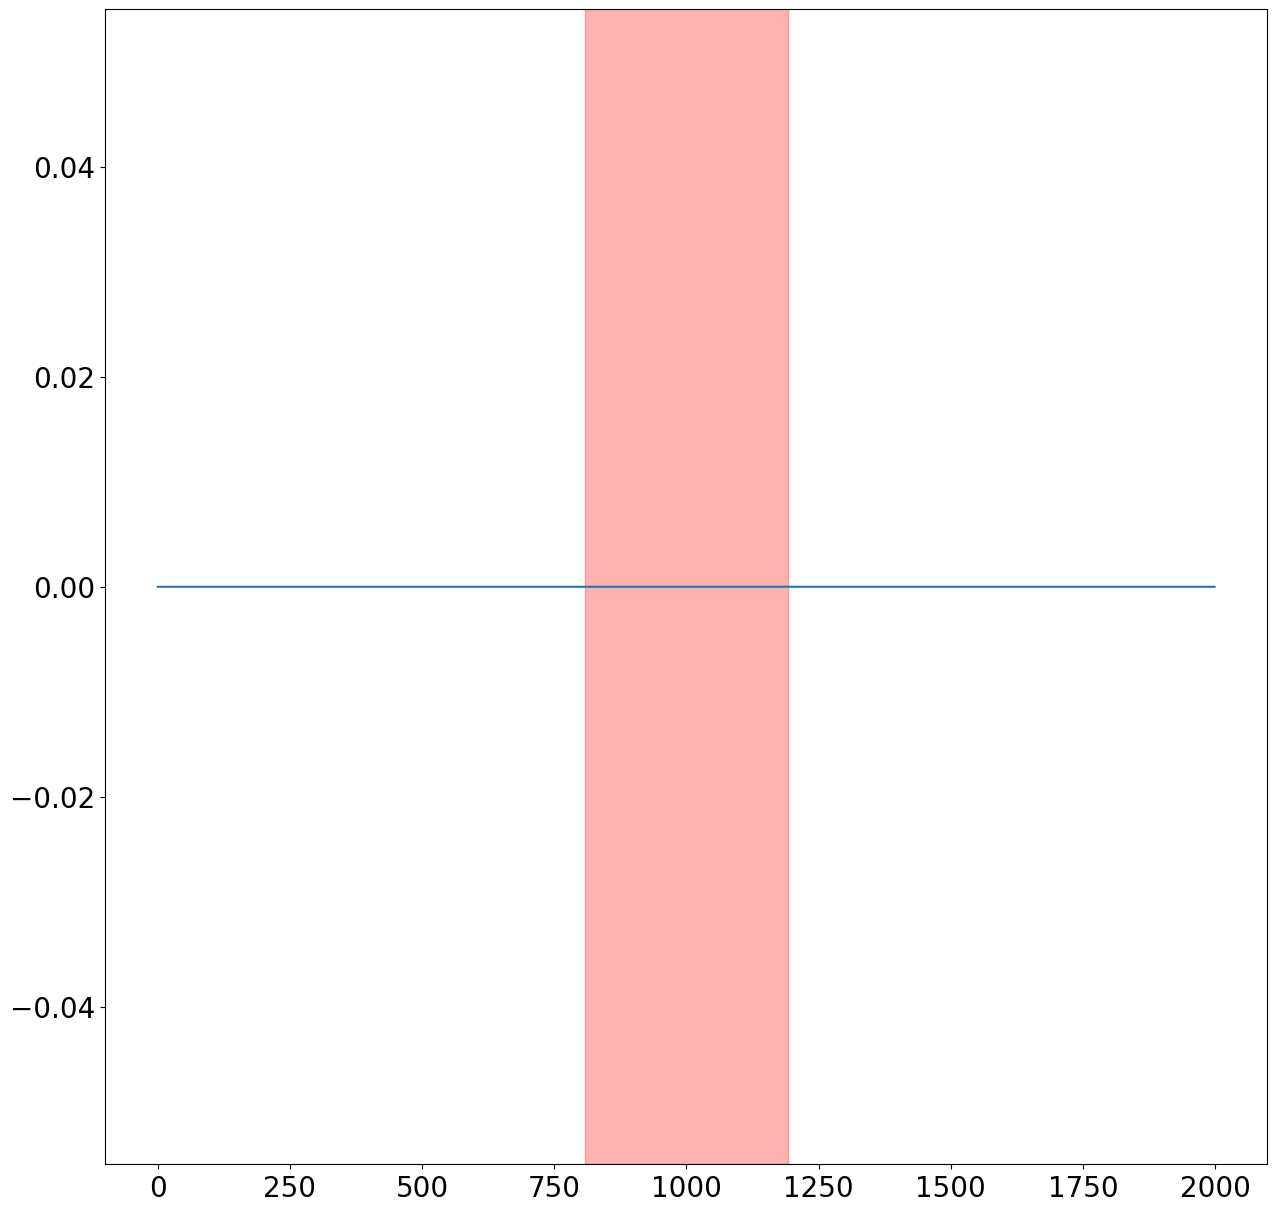

ENSG00000251870
Pred: 0.0002984181
Actual: 0.0


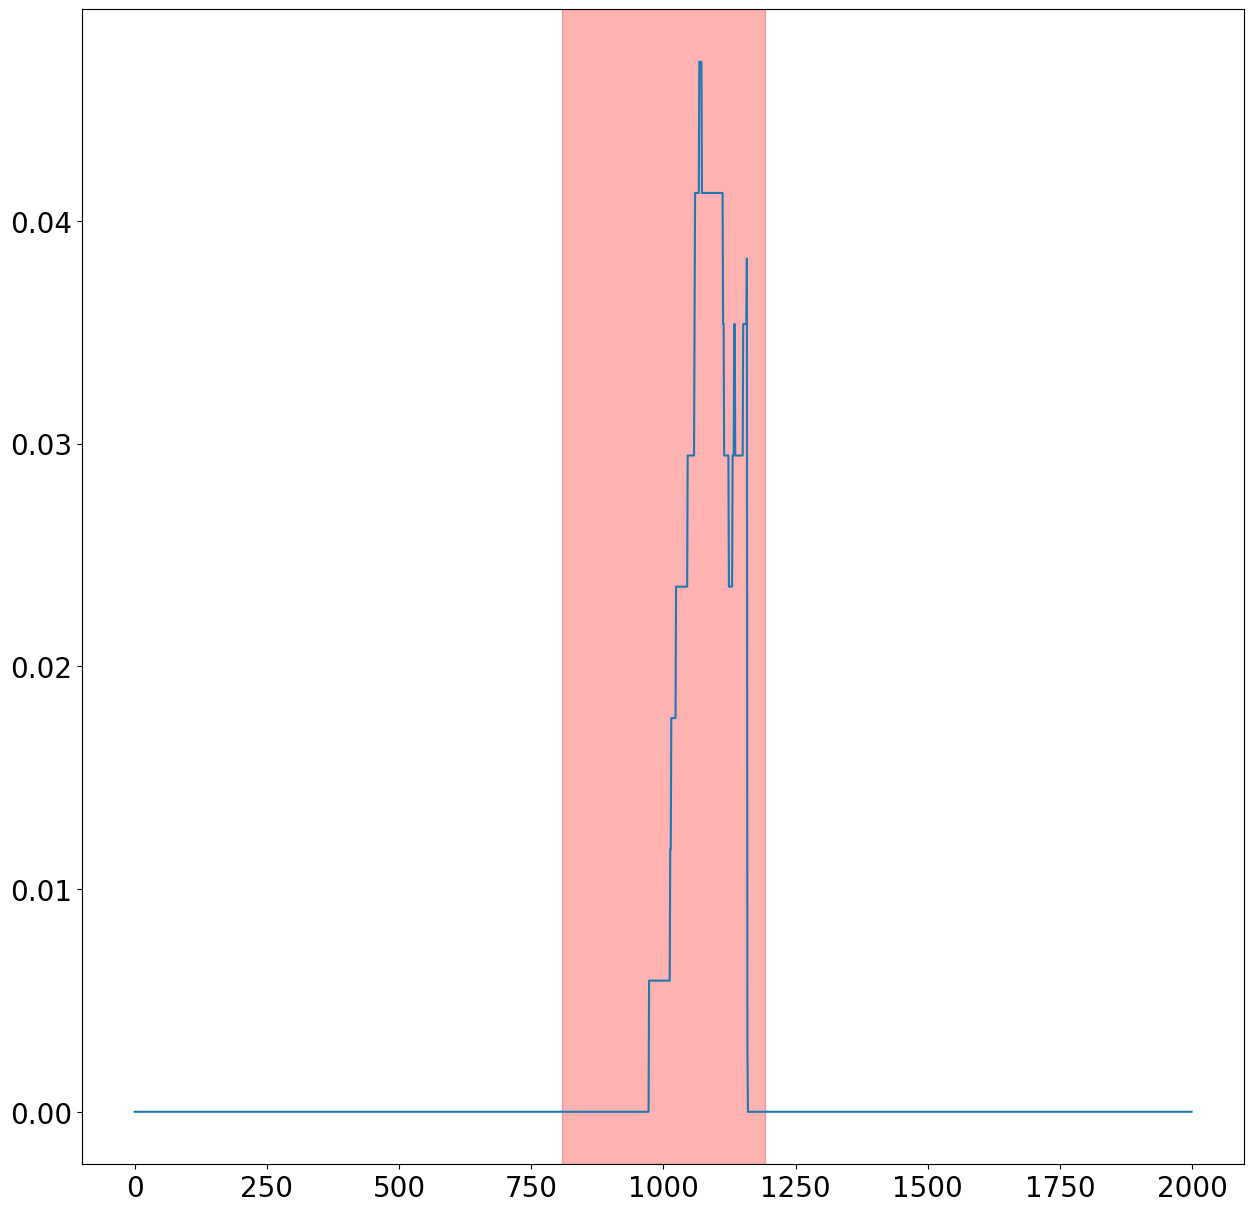

ENSG00000266256_1
Pred: 0.7217478
Actual: 0.7214479


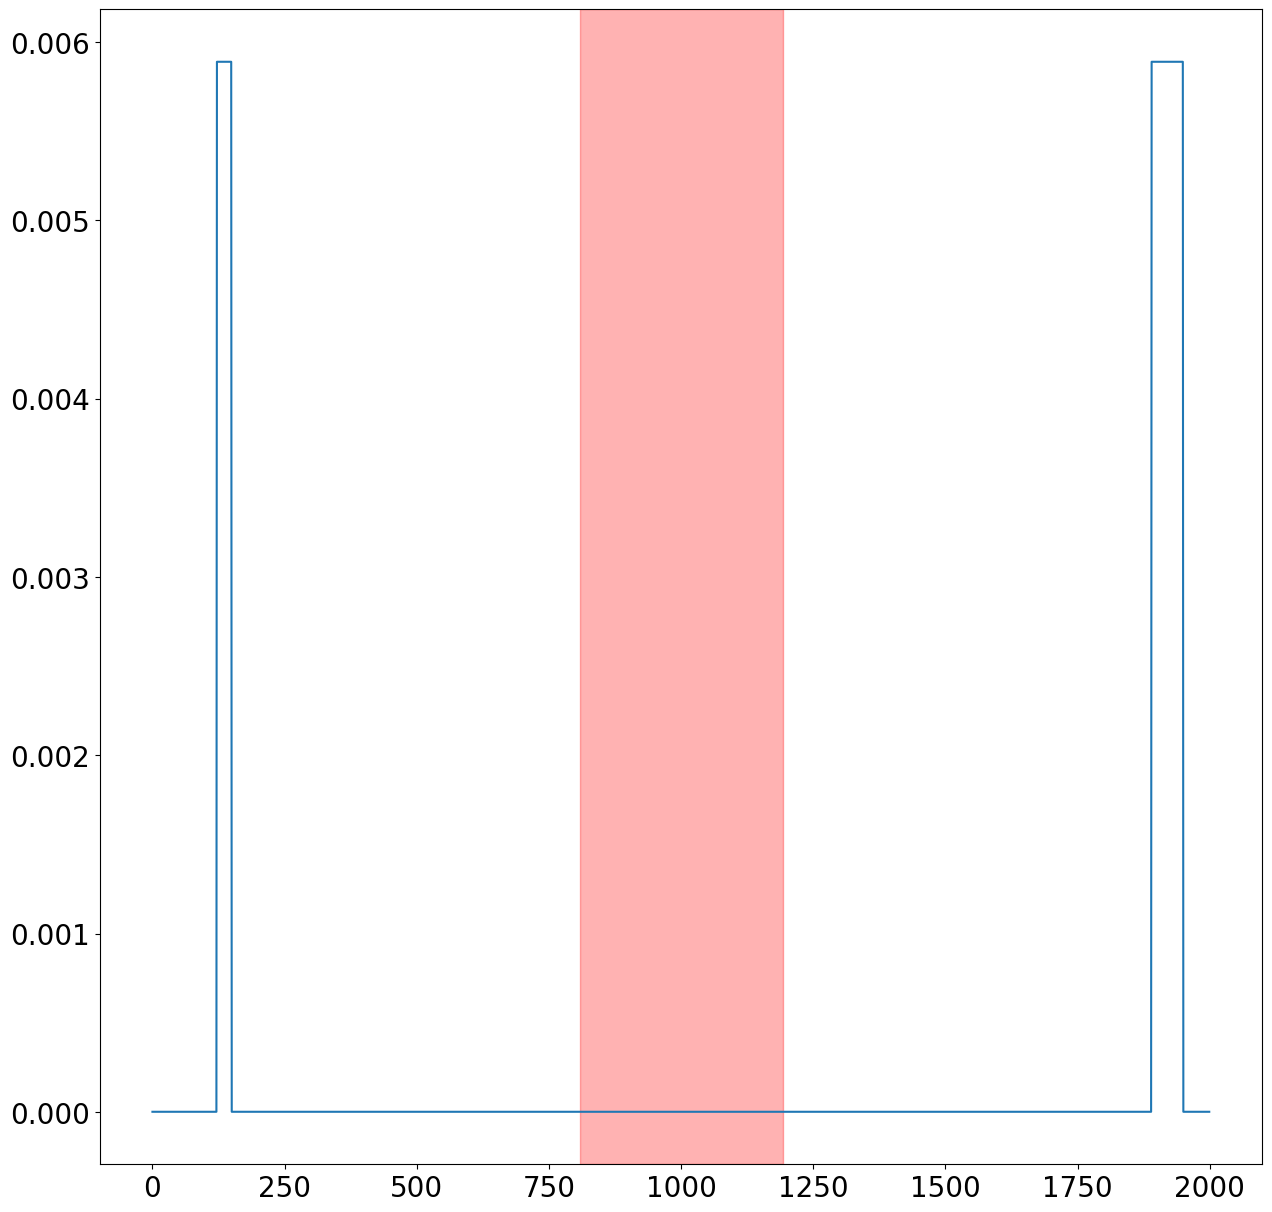

ENSG00000130734
Pred: 2.1572223
Actual: 2.157481


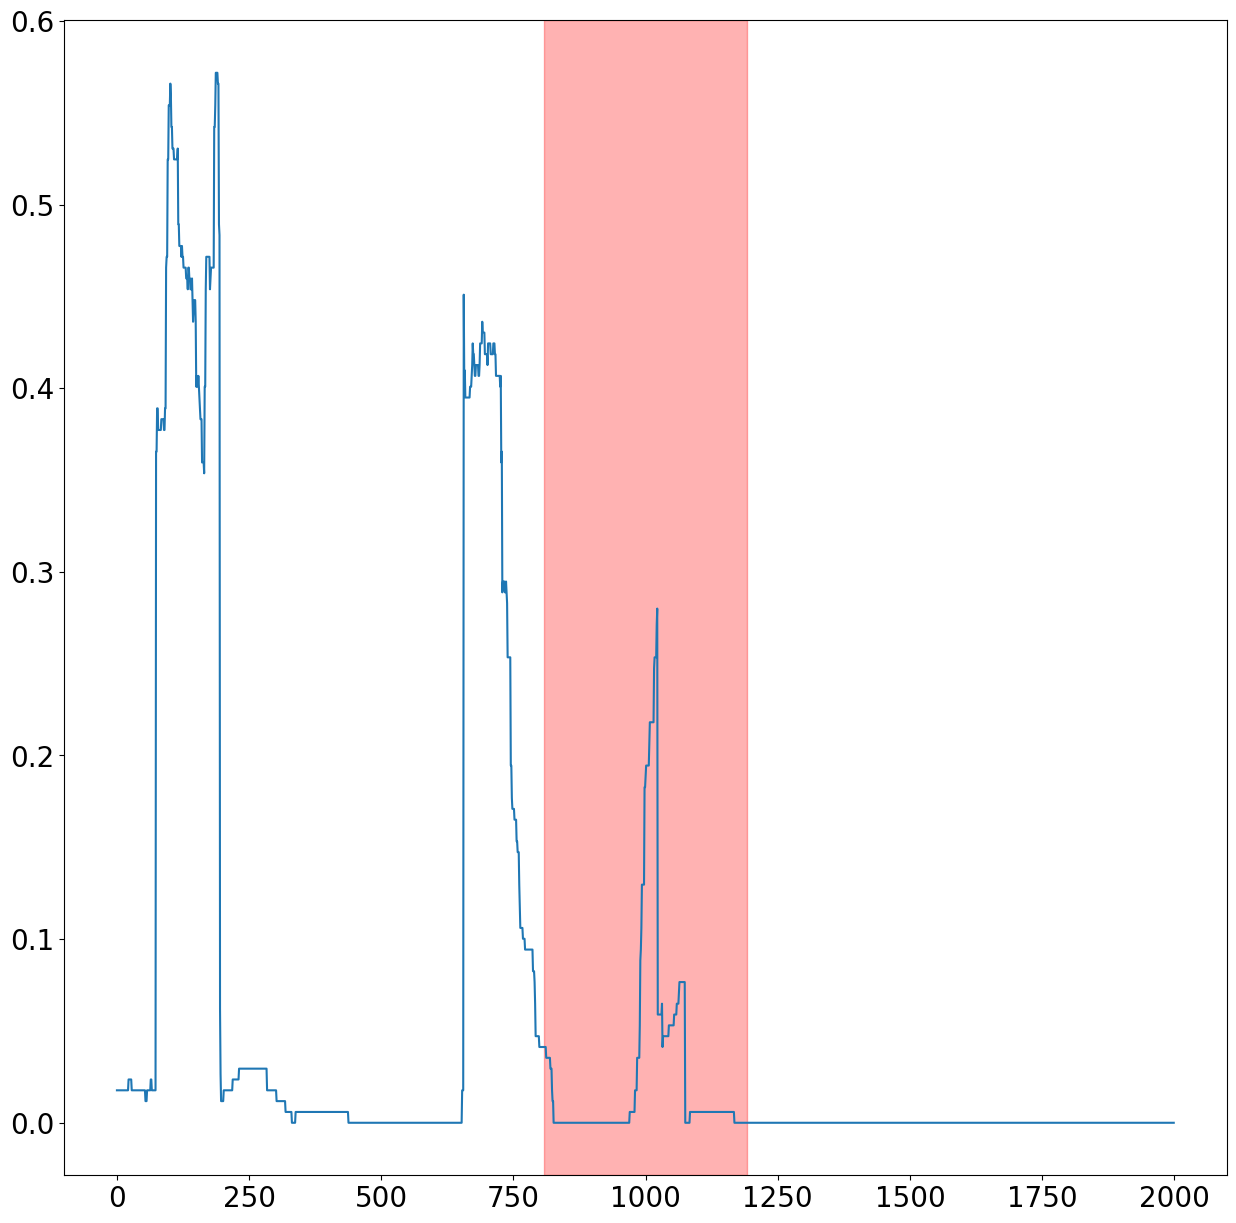

ENSG00000189042
Pred: 1.8038907
Actual: 1.8044162


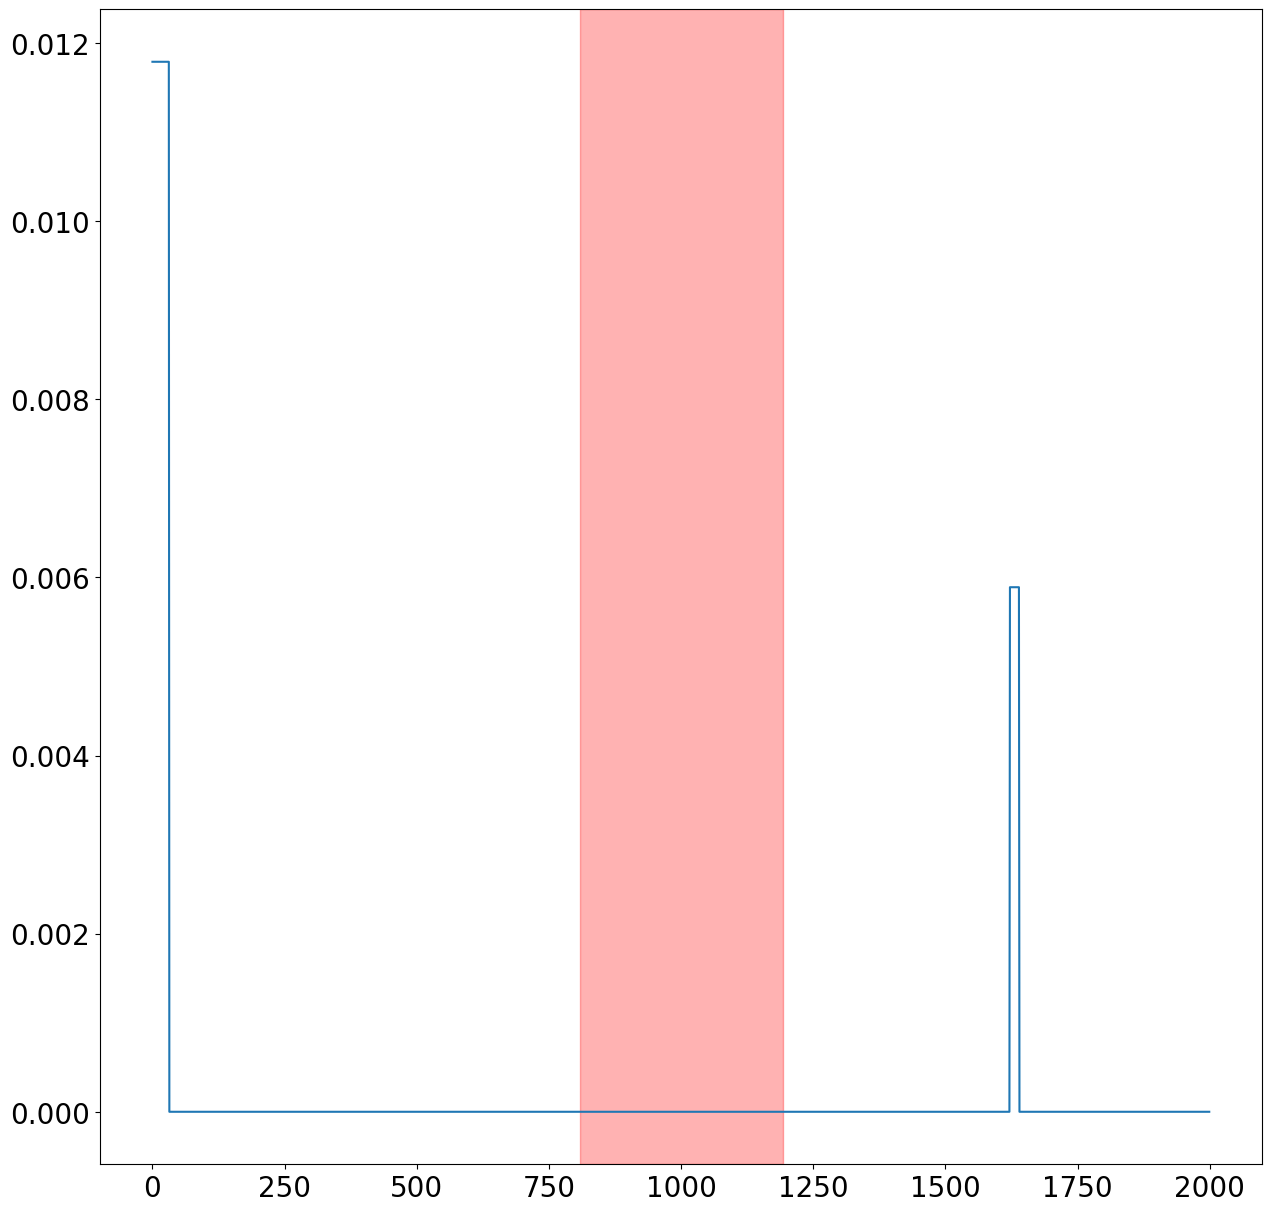

ENSG00000134318
Pred: 2.148365
Actual: 2.1484823


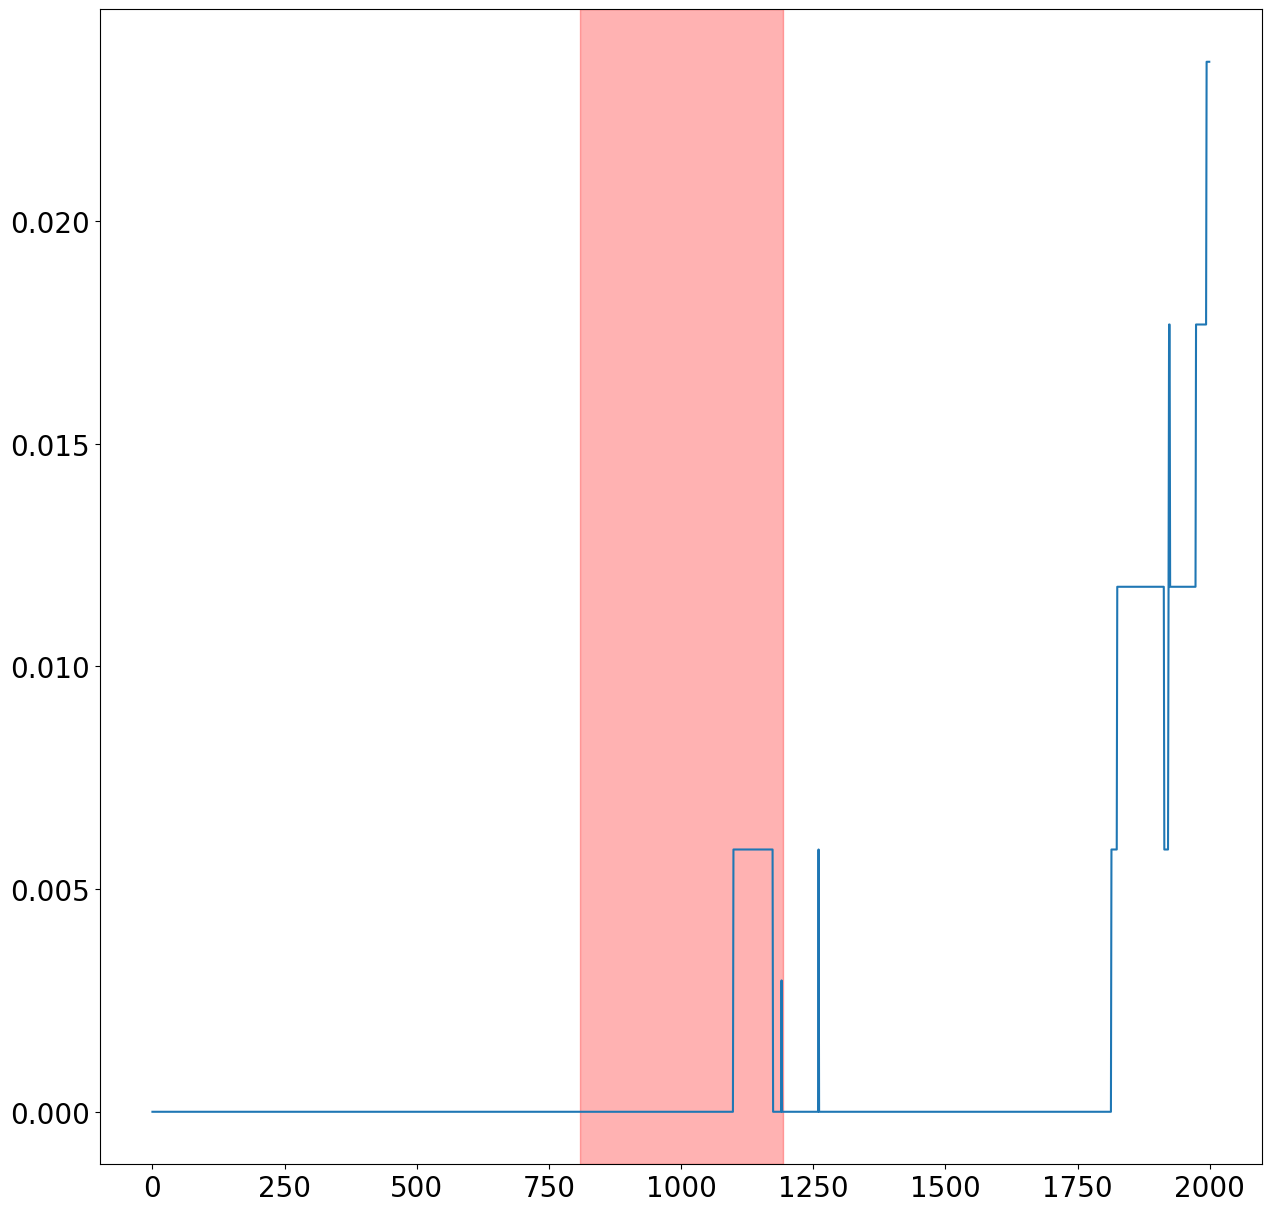

ENSG00000293434
Pred: 2.4336116
Actual: 2.433376


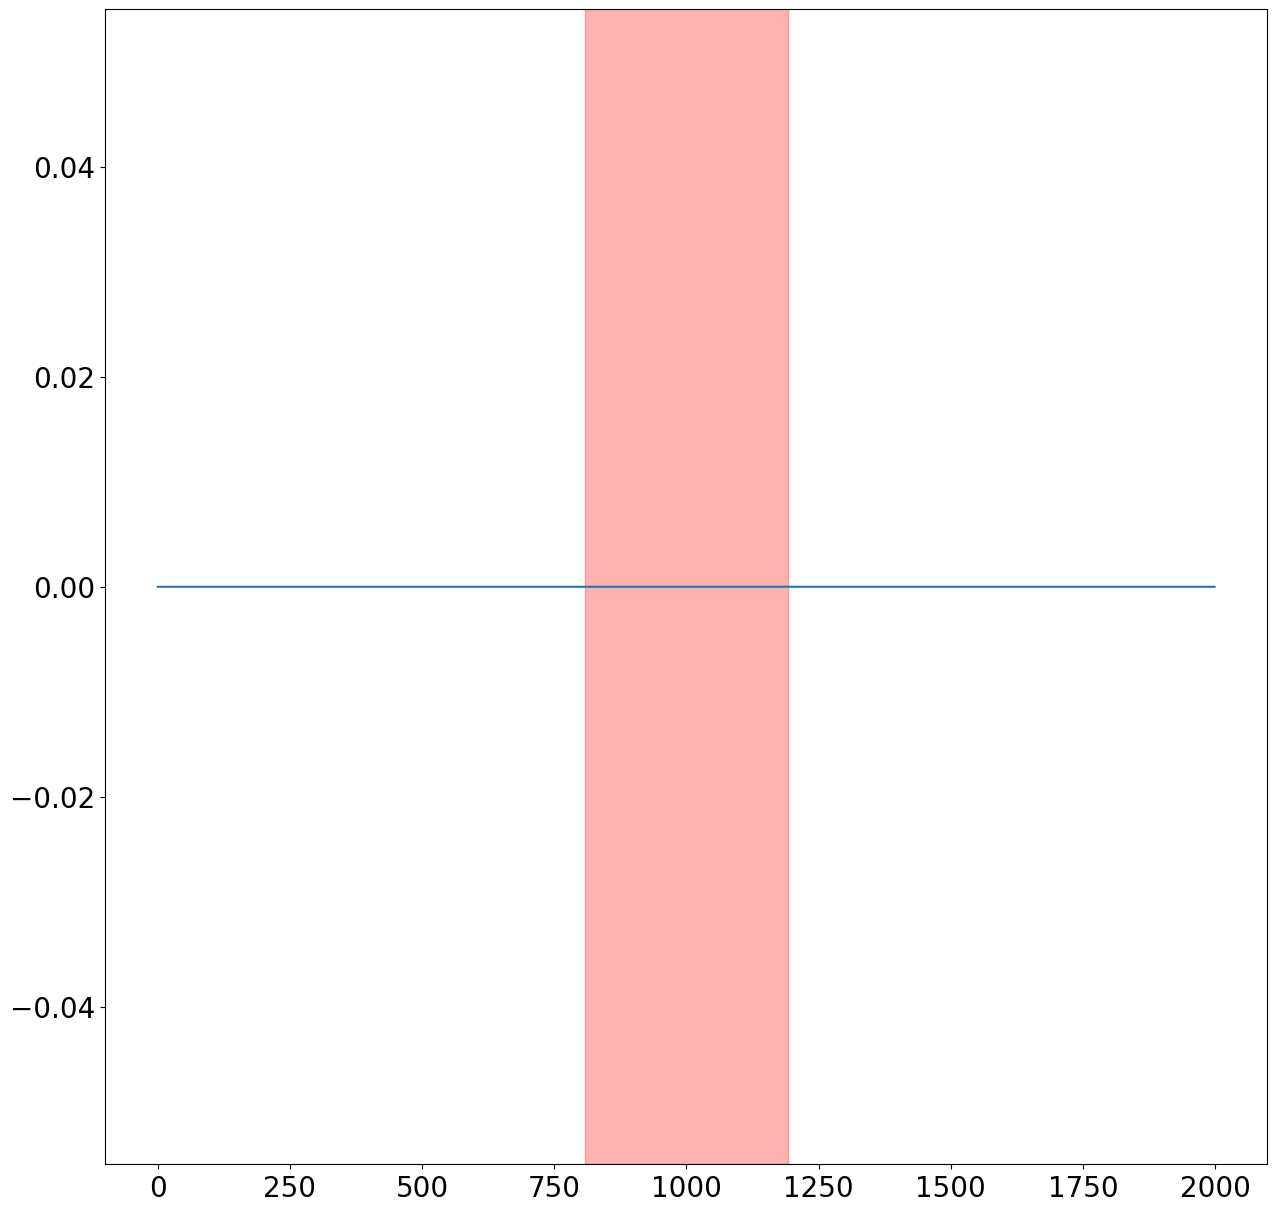

ENSG00000135638
Pred: 1.8934821
Actual: 1.8934288


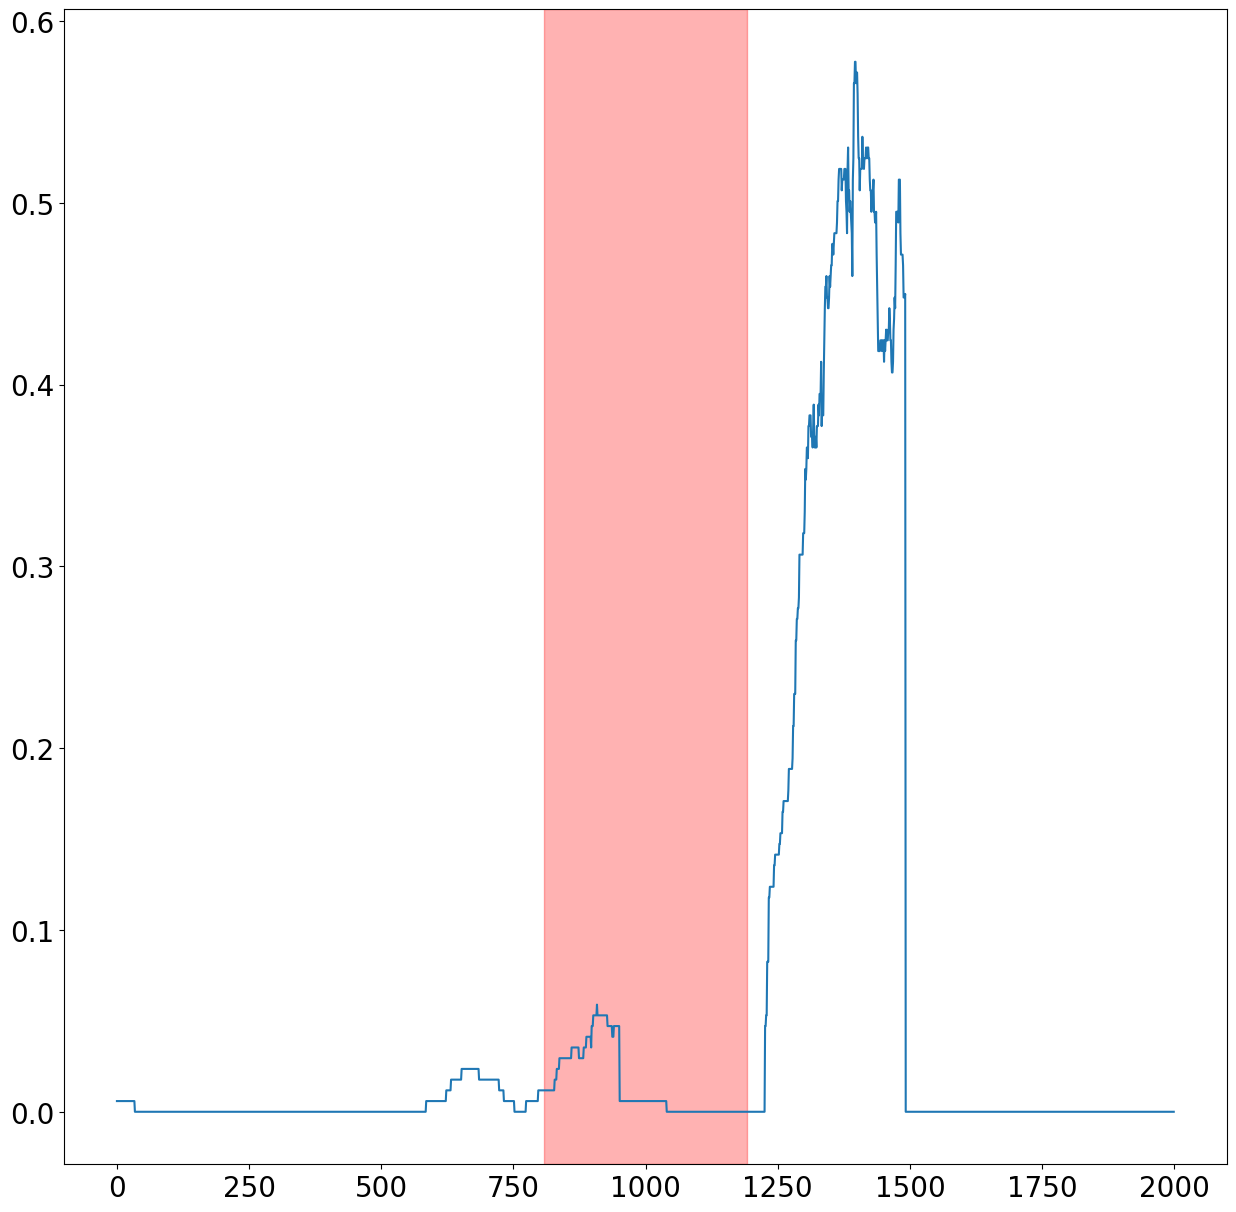

ENSG00000071967
Pred: 2.280791
Actual: 2.2808197


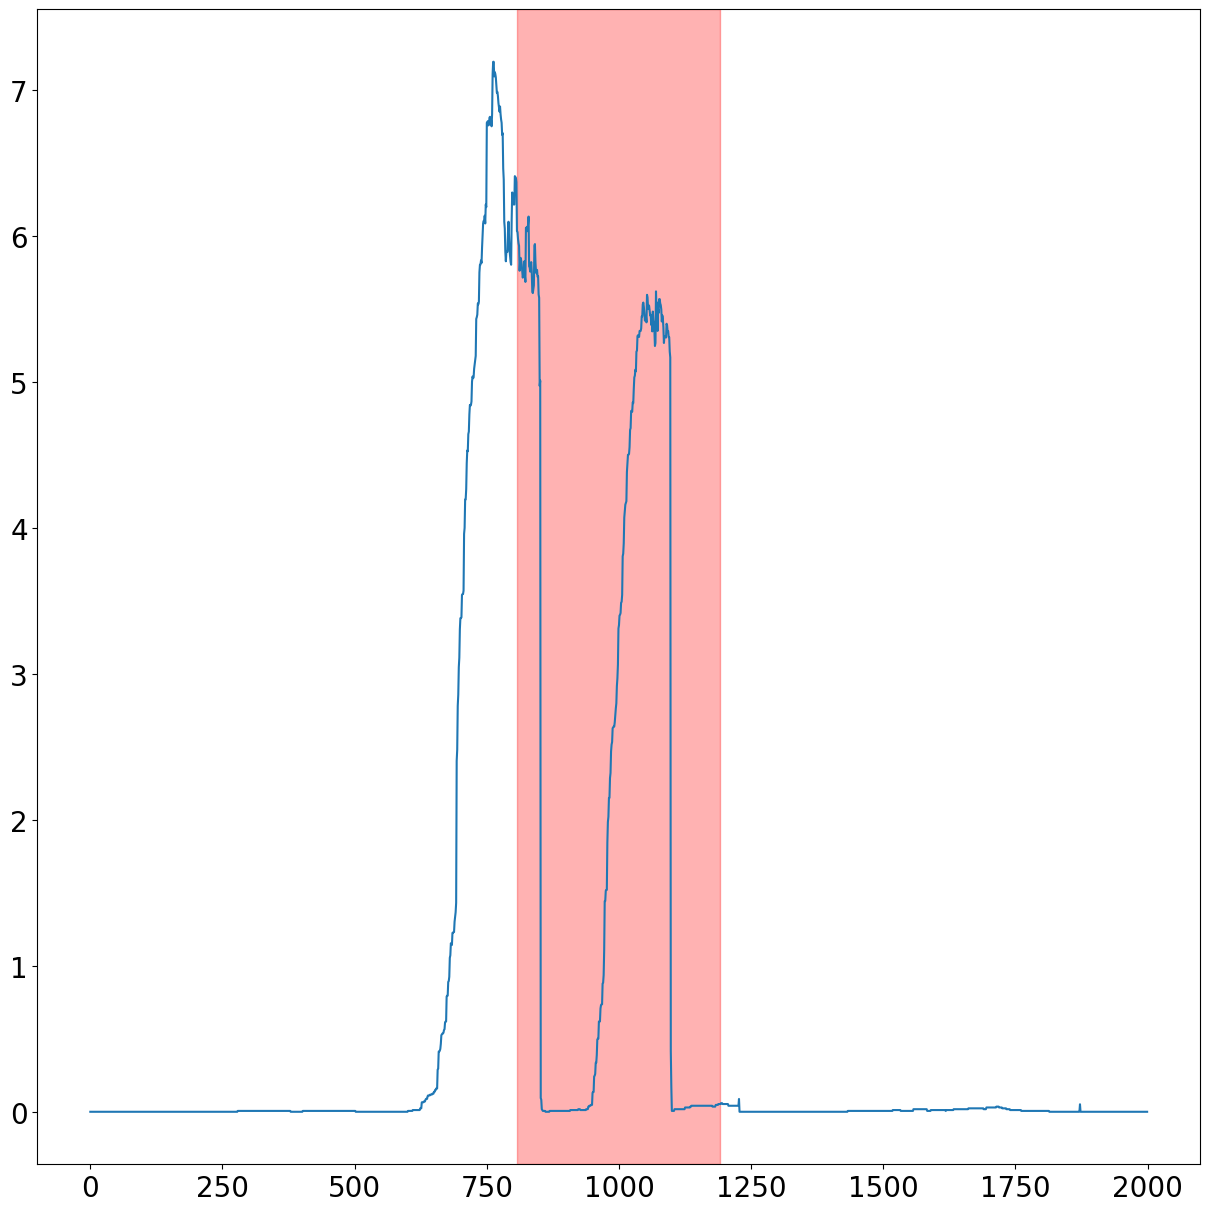

ENSG00000077380_1
Pred: 2.5444367
Actual: 2.5443993


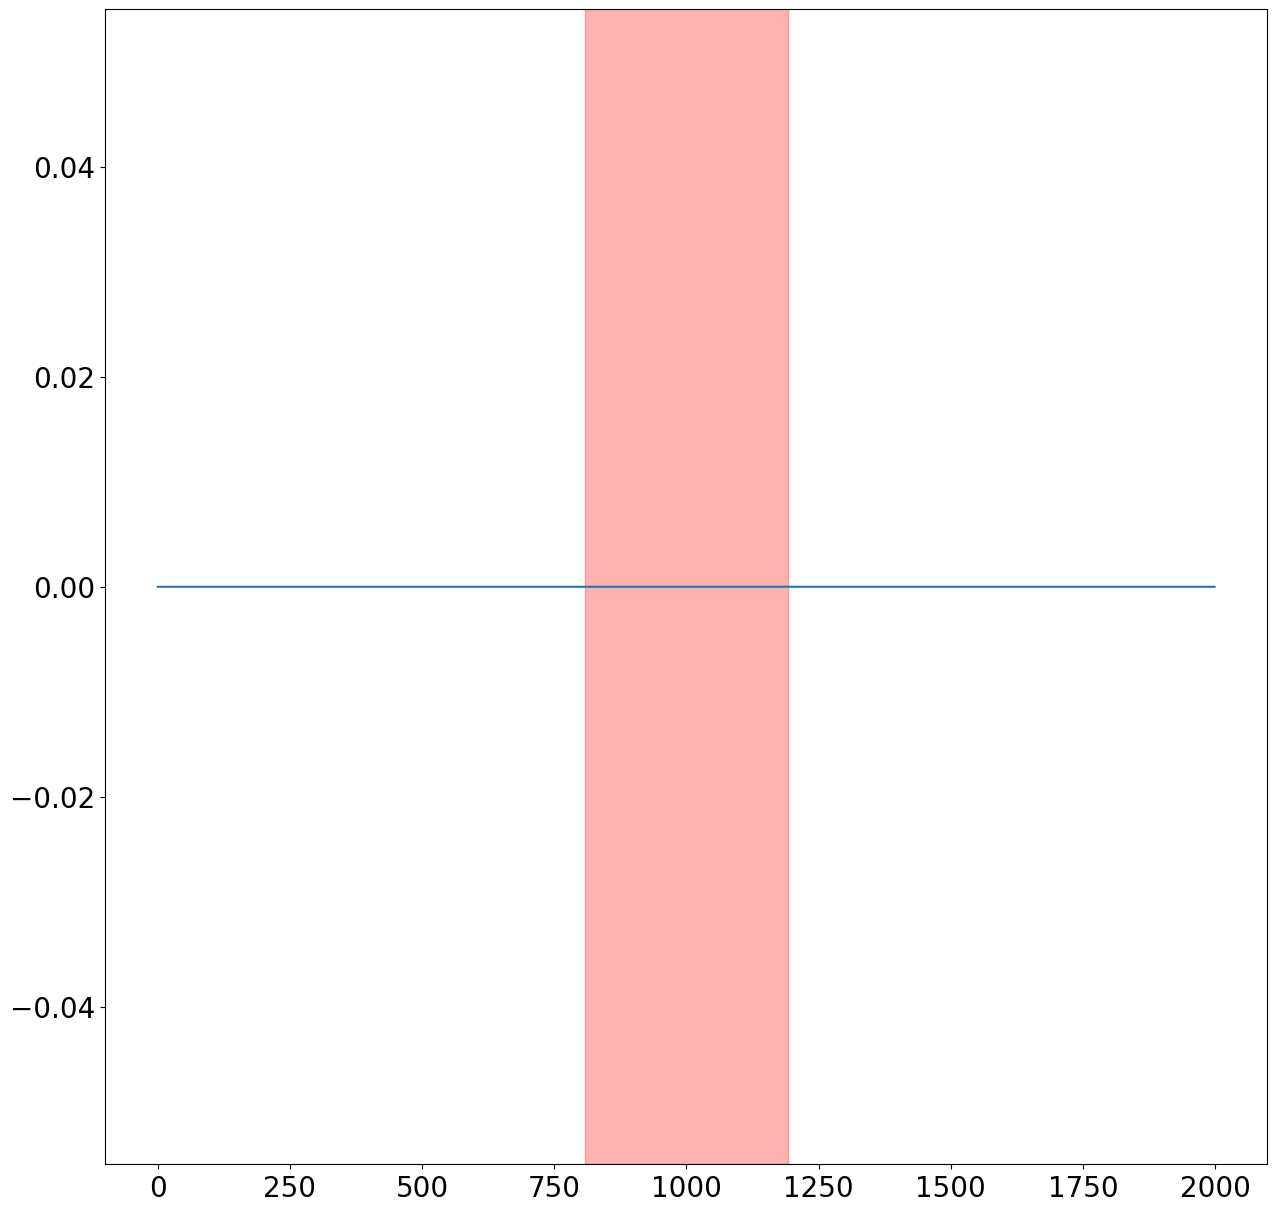

ENSG00000138379
Pred: 0.00032097846
Actual: 0.0


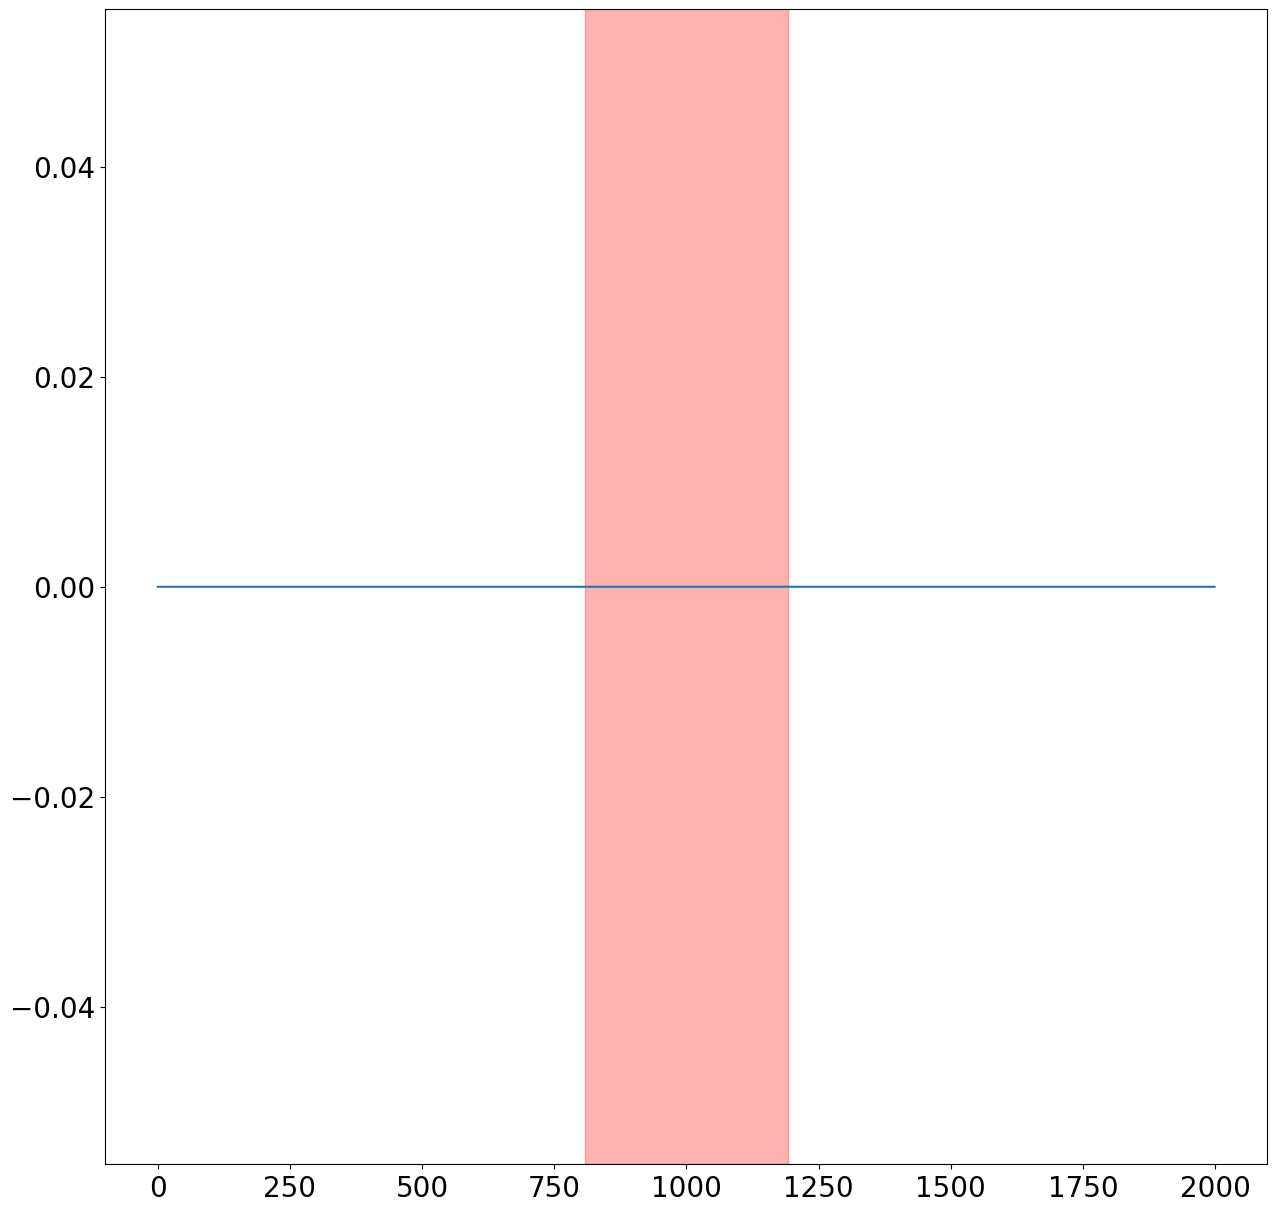

ENSG00000178562
Pred: -3.2417476e-05
Actual: 0.0


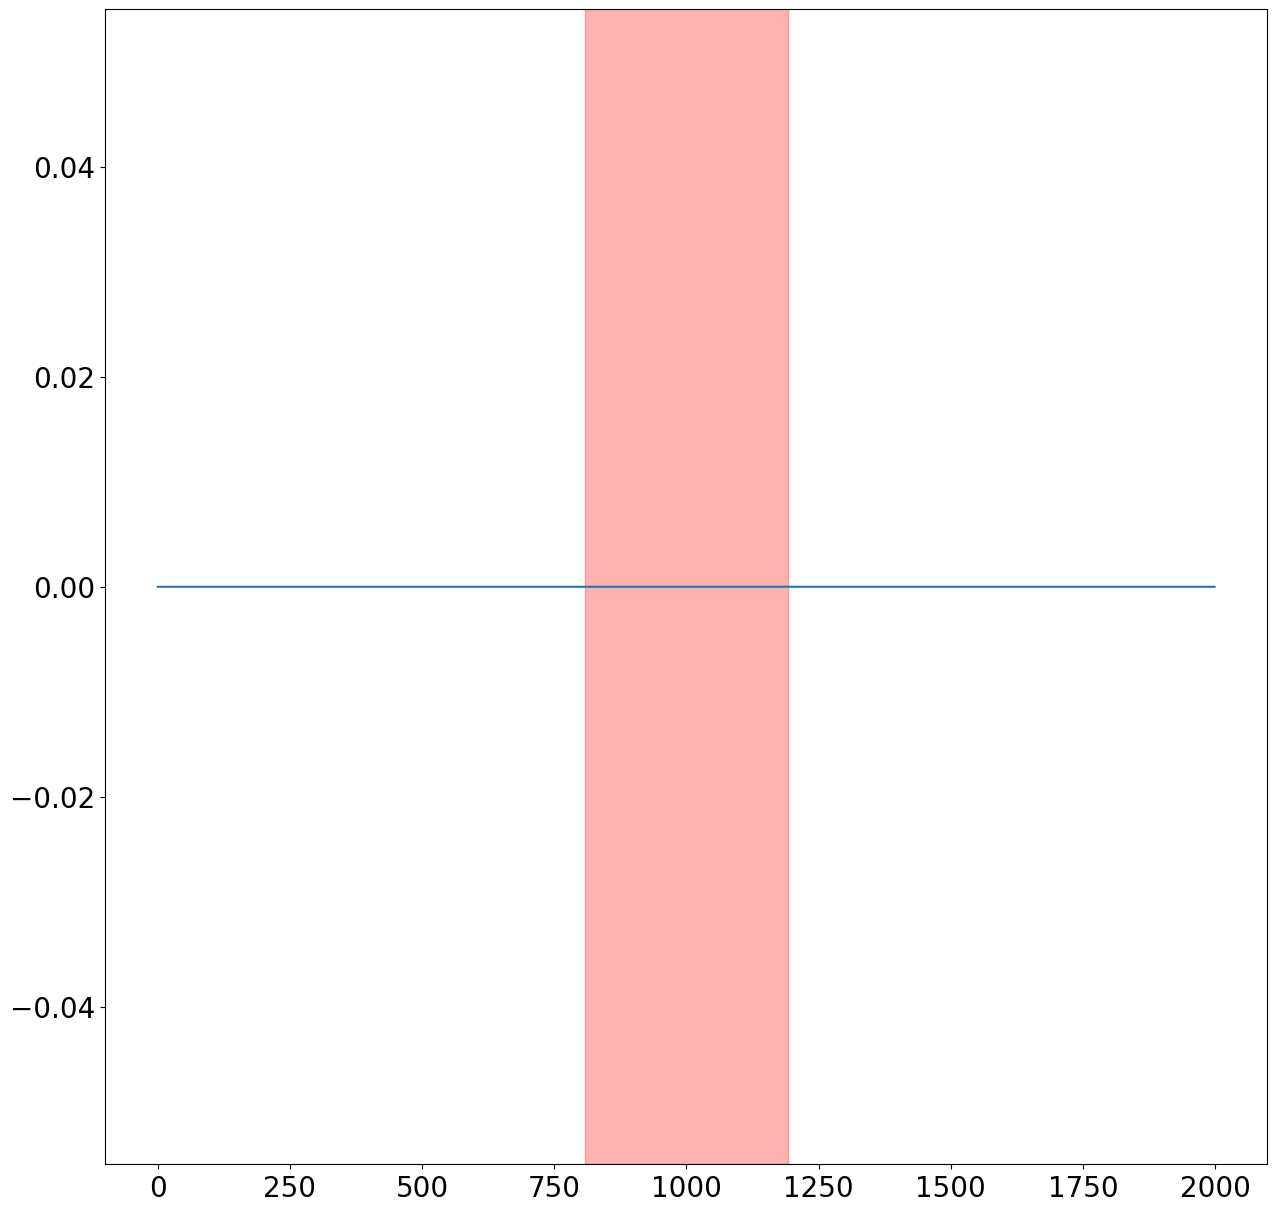

ENSG00000115474
Pred: 0.00024561584
Actual: 0.0


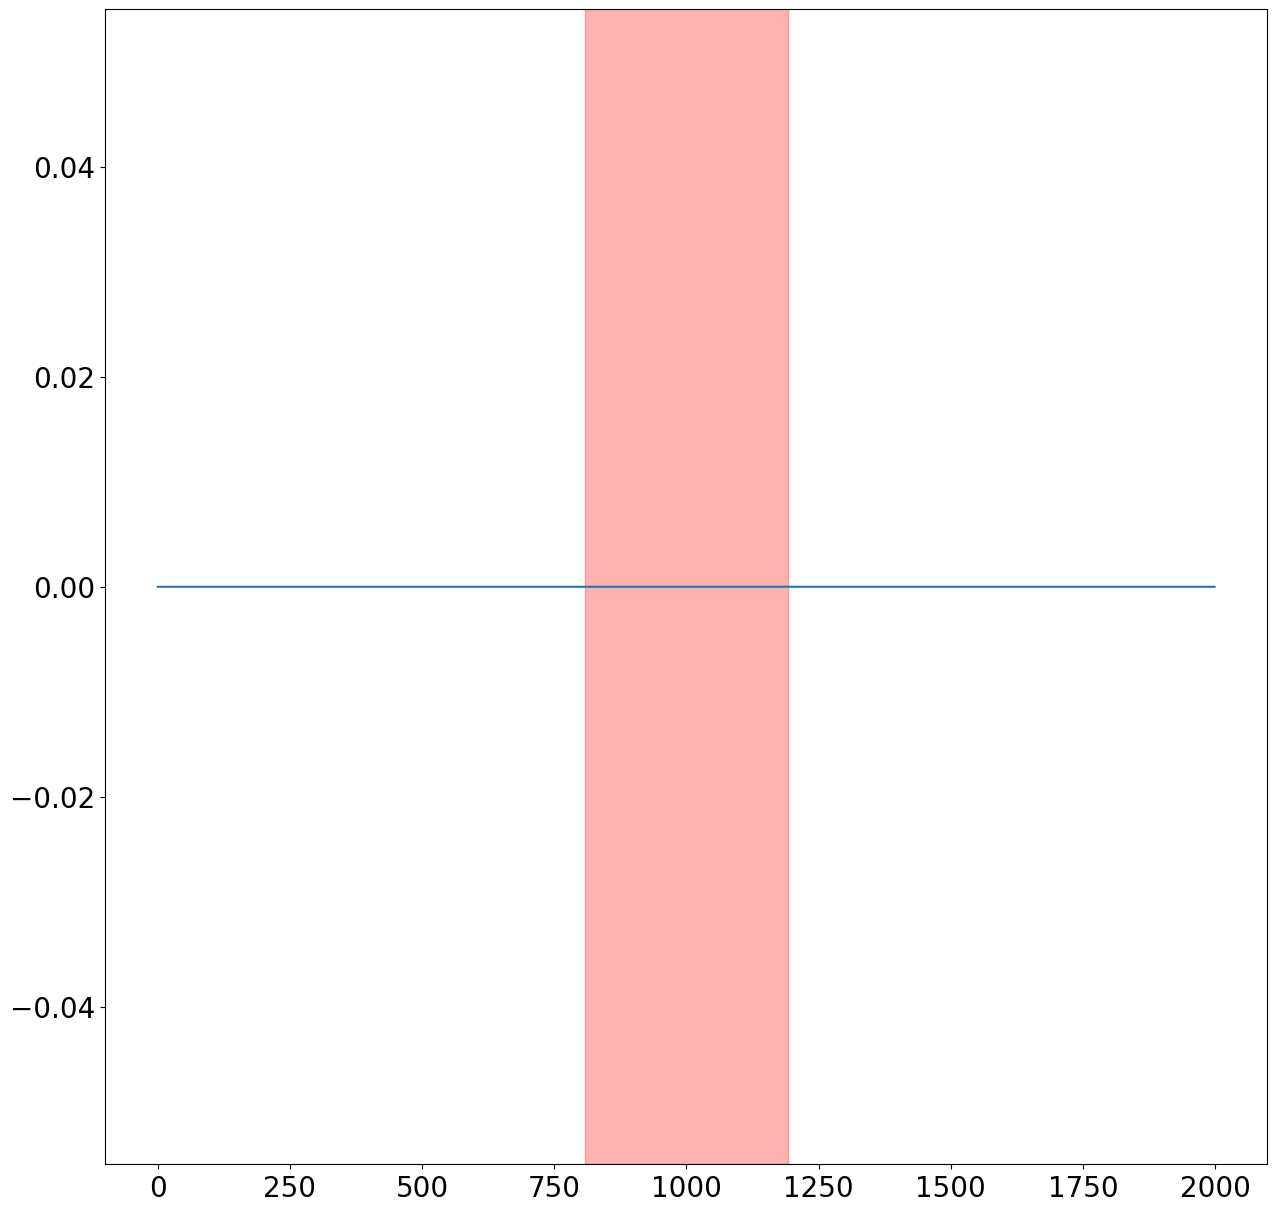

ENSG00000158445_1
Pred: 1.6994836
Actual: 1.69897


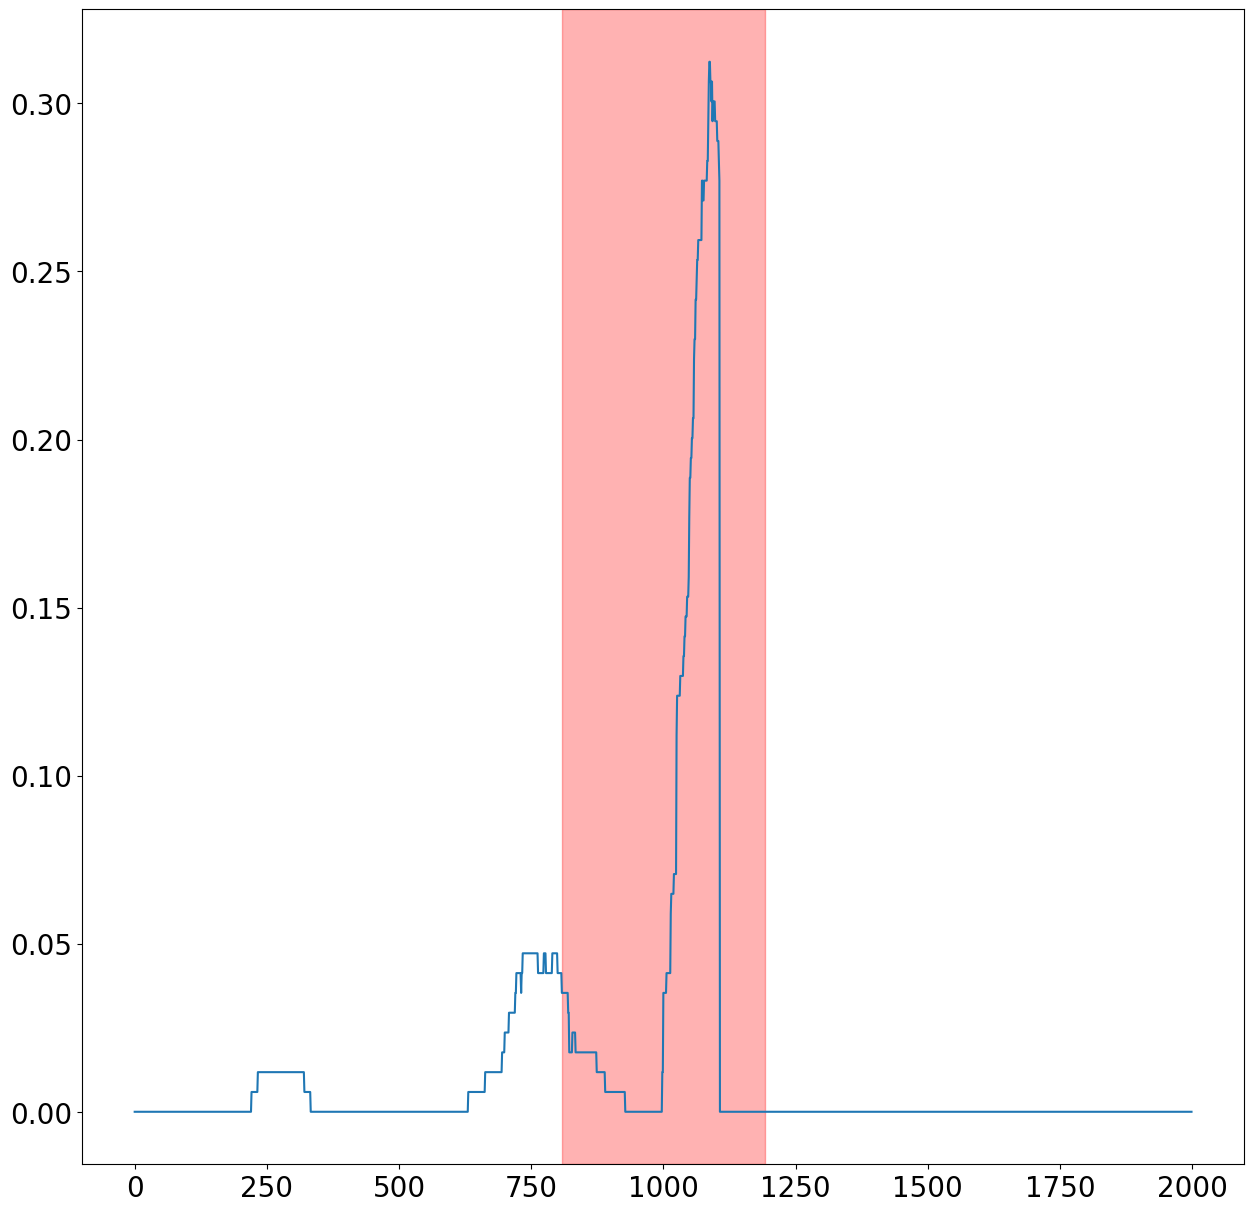

ENSG00000159256
Pred: 2.8457057
Actual: 2.8459306


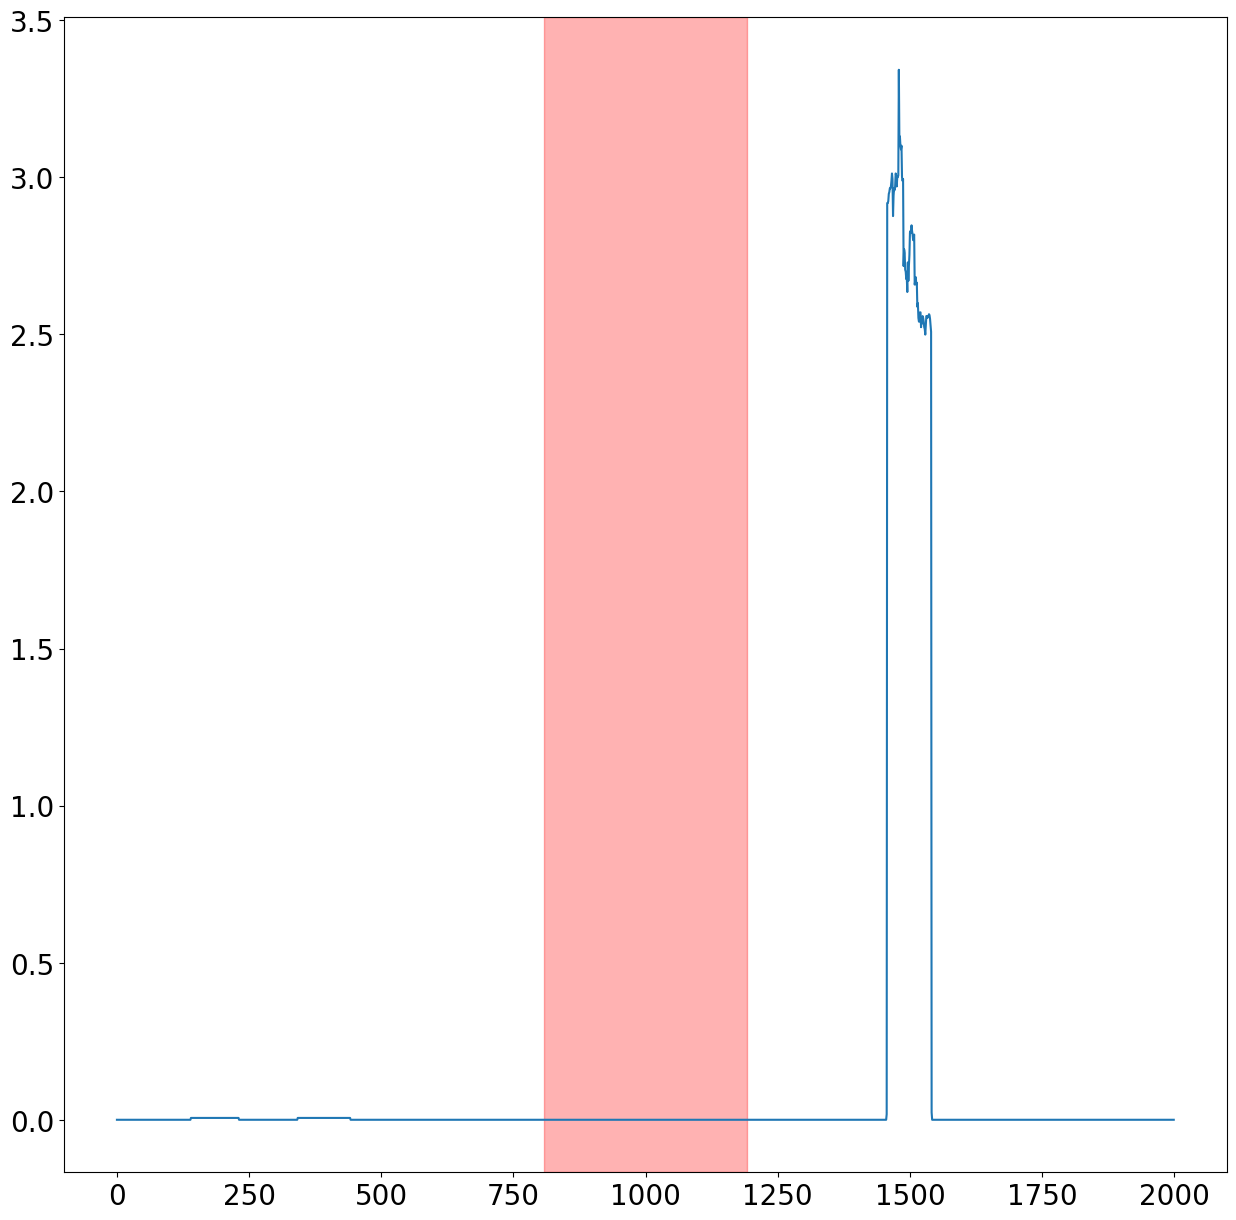

ENSG00000100225_2
Pred: 0.00040121004
Actual: 0.0


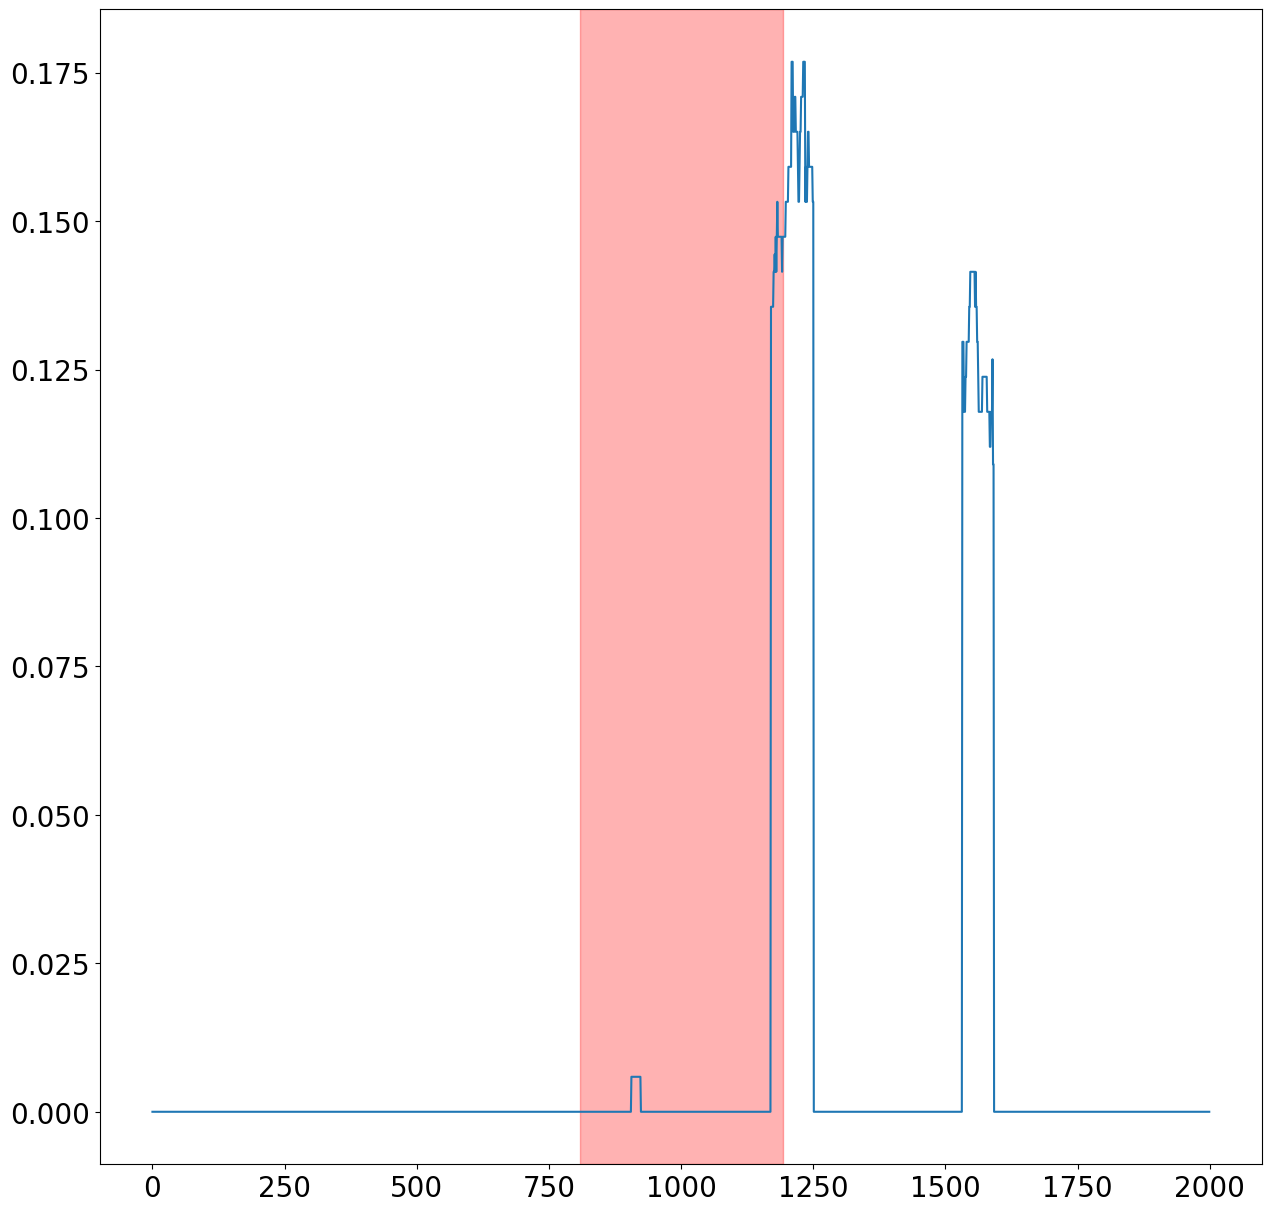

ENSG00000163681_3
Pred: -0.00056821853
Actual: 0.0


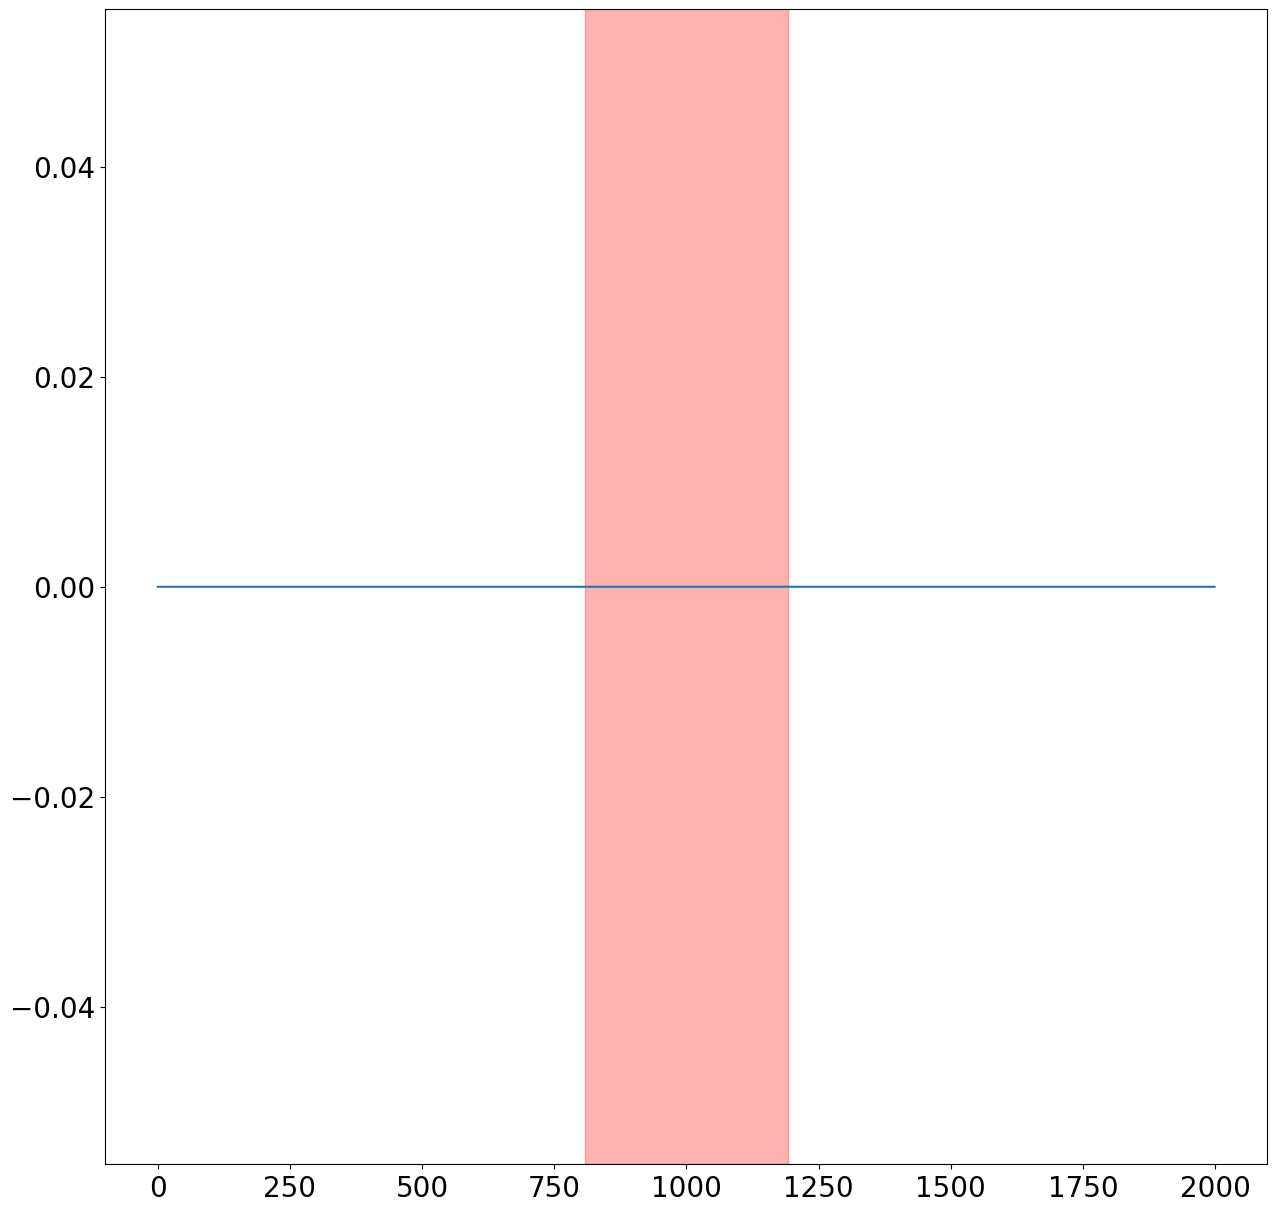

ENSG00000187527
Pred: 0.0007323902
Actual: 0.0


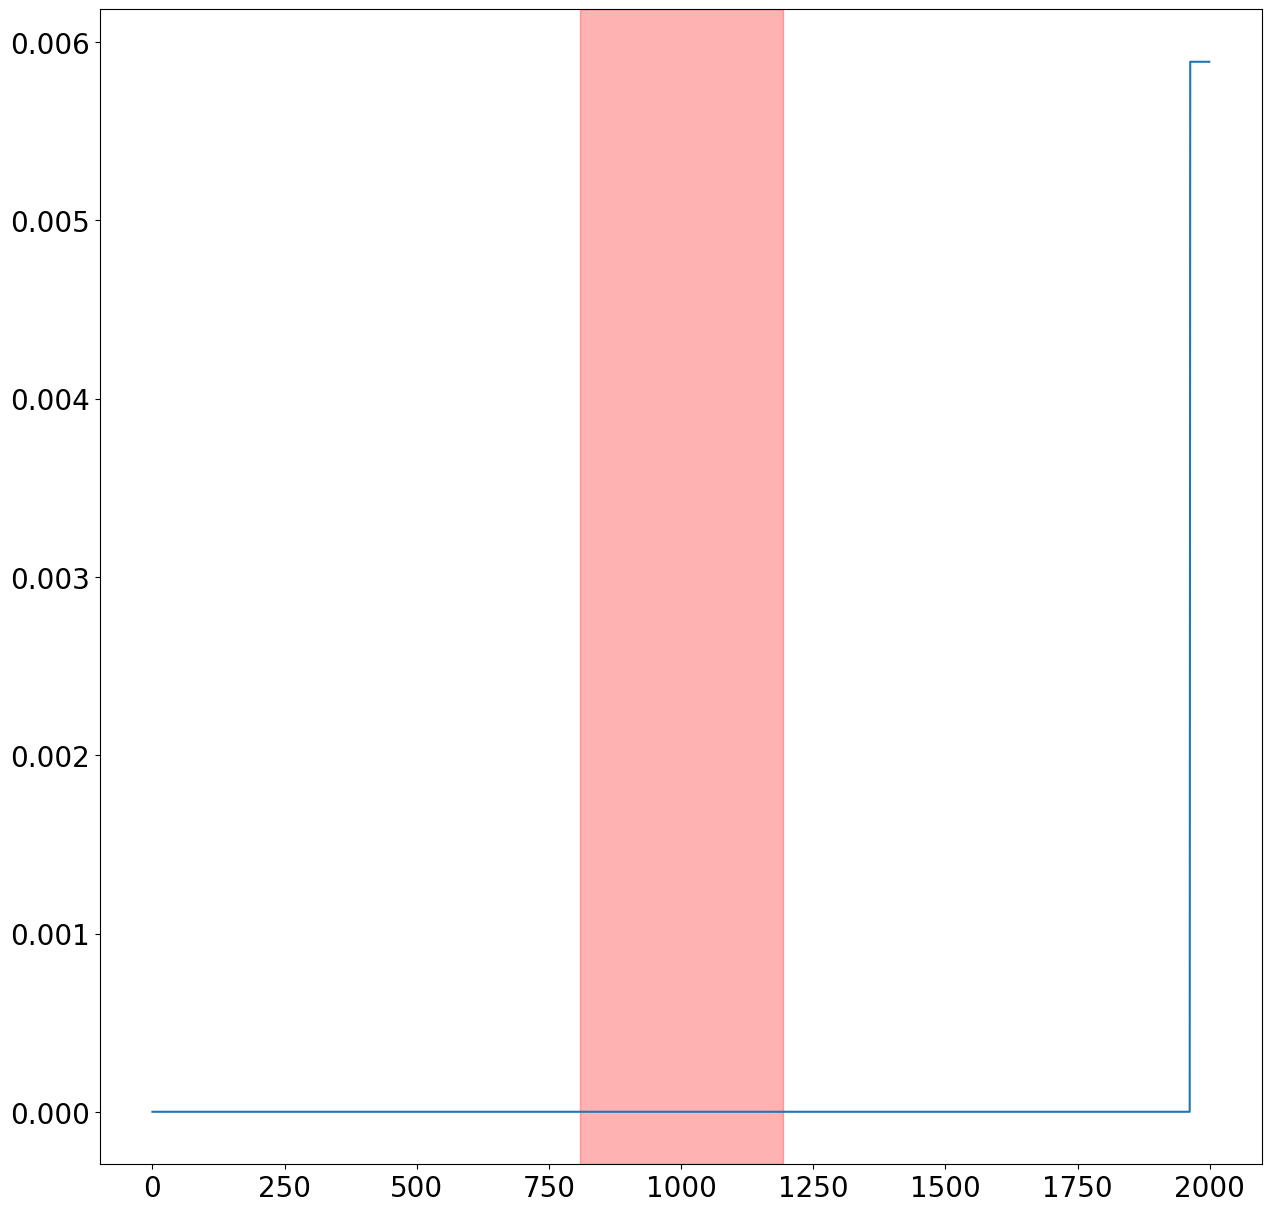

ENSG00000163453_1
Pred: 1.5355393
Actual: 1.5362554


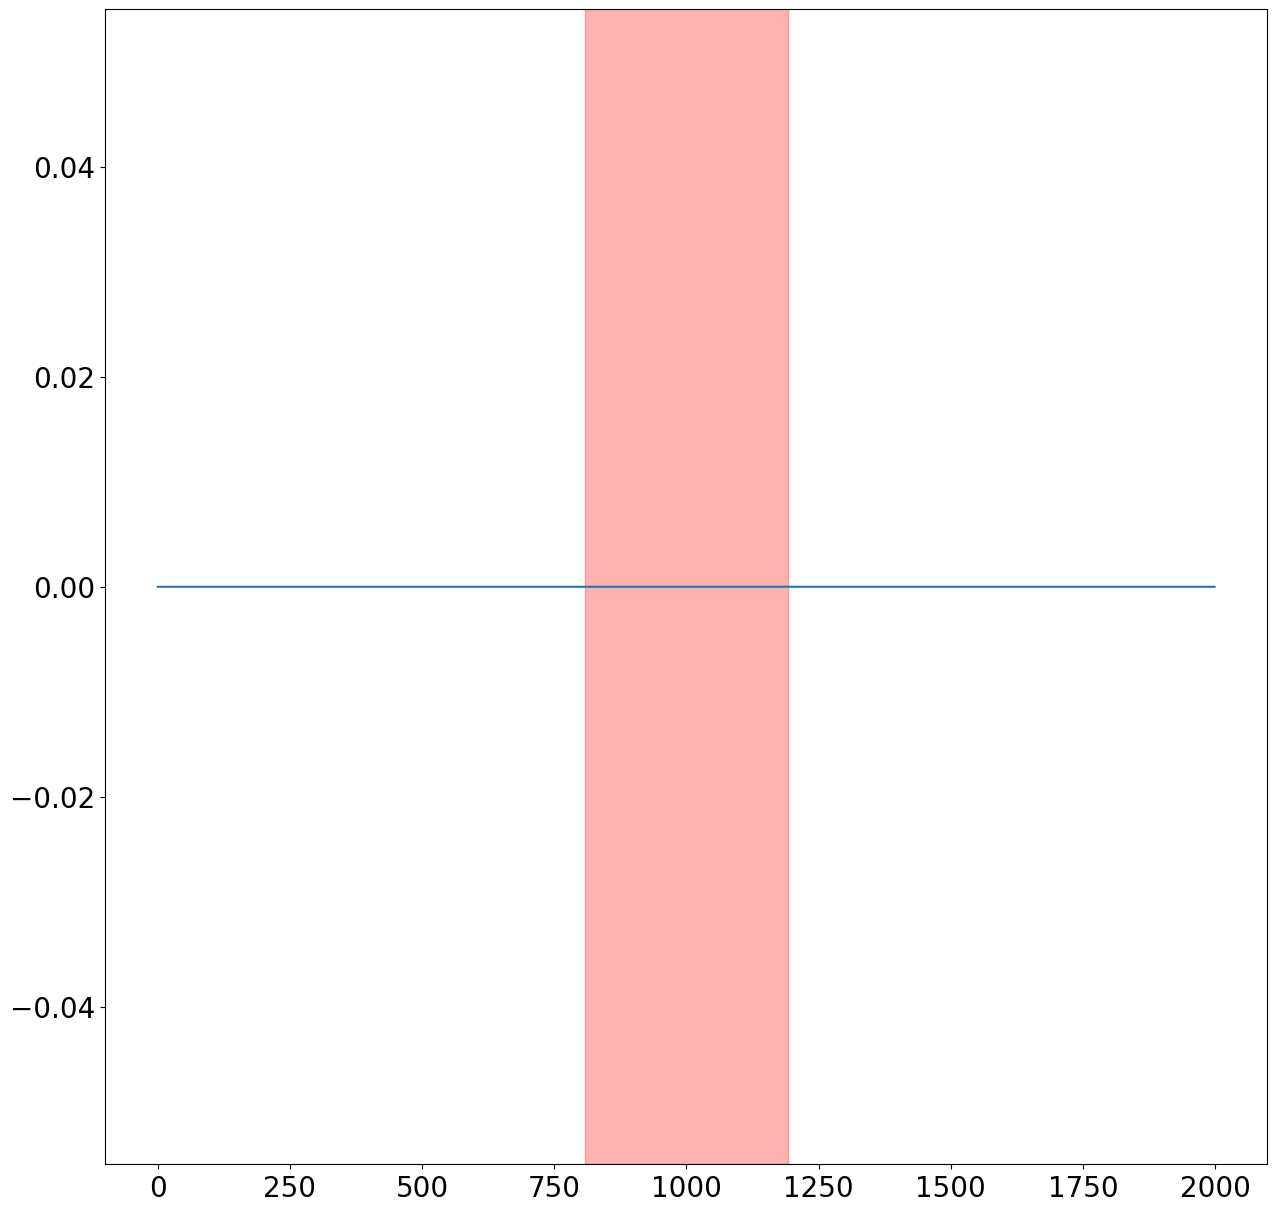

ENSG00000145321
Pred: -0.00020624697
Actual: 0.0


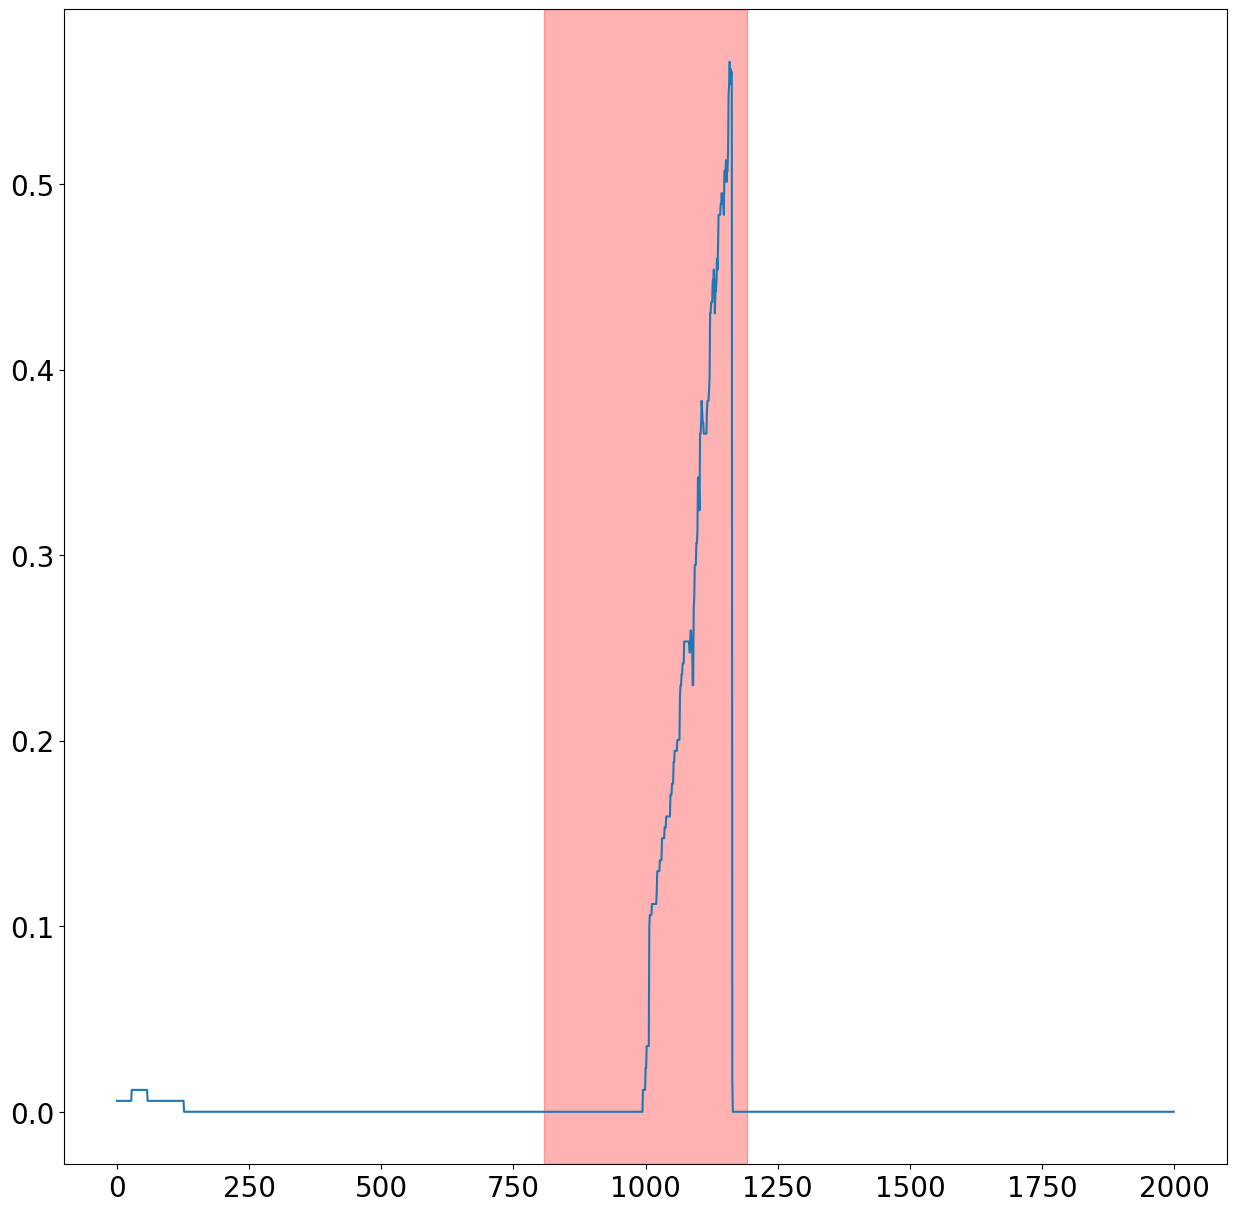

ENSG00000163738_2
Pred: 2.3040242
Actual: 2.30426


In [421]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    plt.figure(figsize=(15, 15))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    # plt.xlabel("Base Pair")
    # plt.ylabel("Number of RNA Molecules (Log10)")
    # plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    # plt.savefig(f"predictions/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

# print("\nK562: ")
# for i, v in enumerate(ensid_5_best_under_k5):
#     plt.plot(signal_5_best_under_k5[i])
#     plt.xlabel("Base Pair")
#     plt.ylabel("Number of RNA Molecules (Log10)")
#     plt.title(v.decode())
#     plt.axvspan(808, 1192, color="red", alpha=0.3)
#     # plt.savefig(f"predictions/underestimates/best/K562.{v.decode()}.png")
#     plt.show()

#     print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
#     print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 3487
2: 3132
3: 2566
4: 2161
5: 2953
6: 2341
7: 2376
8: 3031
9: 3037
10: 3383
11: 2304
12: 2478
Total Number of Matches: 13951
Total Matches with >= 1 Non-Zero Value: 7306
Percentage of TSSs with No Signal: 47.63%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000162576', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000067606', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000157933', 'ENSG000

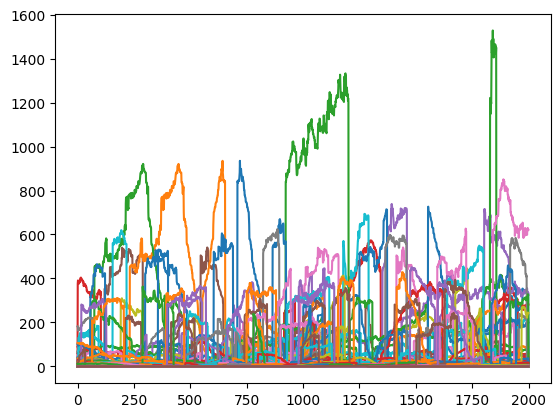

K562: 
Threshold: 0
Genes per Fold: 
1: 6974
2: 6264
3: 5132
4: 4322
5: 5906
6: 4682
7: 4752
8: 6062
9: 6074
10: 6766
11: 4608
12: 5598
Total Number of Matches: 13951
Total Matches with >= 1 Non-Zero Value: 7361
Percentage of TSSs with No Signal: 47.24%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187642', 'ENSG00000304119', 'ENSG00000186891', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000205116', 'ENSG00000197530', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000157933', 'ENSG00000157933_1', 'ENSG00000116151', 'ENSG00000157911', 'ENSG000001

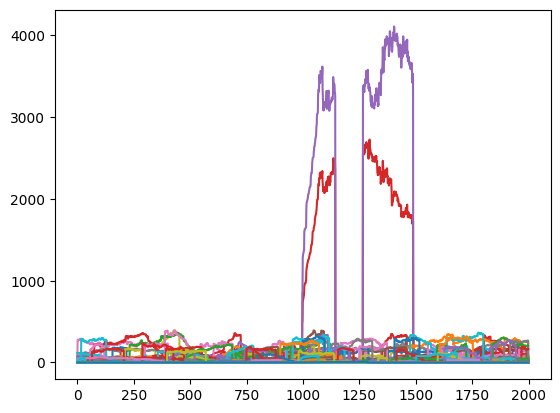

<Figure size 640x480 with 0 Axes>

In [413]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/zero", "K562")